In [16]:
### Application: ECG-Modeling
# Work in progress

In [17]:
import numpy as np
import math
import scipy
from scipy import integrate, ndimage, signal
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import os, sys
import copy
sys.path.append(os.path.abspath(os.path.join('../../..')))
import pandas as pd
import datetime
from functools import partial
import tensorflow as tf
import pickle
import glob
import re
import time
import shutil
import ast
from IPython.display import Image
from IPython.core.display import HTML 

In [18]:
from bayesflow.helper_functions import generate_lr_adjustment_dict

In [19]:
from bayesflow.forward_inference import GenerativeModel, Prior, Simulator
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortized_inference import AmortizedPosterior
from bayesflow.trainers import Trainer
import bayesflow.diagnostics as diag

### Introduction: Synthetically Modeling ECG with BayesFlow

This notebook serves as an introduction to the BayesFlow library by applying it to a mathematical model capable of producing a synthetic electrocardiogram (ECG). The goal is to learn to predict the distribution of various model parameters from a simulated ECG signal. 

Our tutorial begins with a very brief introduction to the ECG signal, a time series of frequencies representing the depolarization and repolarization of various portions of the heart in the course of each heartbeat, and the way in which the simulation model attempts to reproduce its properties. We then turn to an implementation of this model, which is in turn fed into an appropriate BayesFlow architecture in order to learn the parameter distributions. We conclude by evaluating the performance of our BayesFlow.

Here is a segment of ECG representing a single heartbeat:

In [20]:
Image(url= "https://upload.wikimedia.org/wikipedia/commons/9/9e/SinusRhythmLabels.svg", width=500, height=500)
# (Created by Agateller (Anthony Atkielski), converted to svg by atom., Public domain, via Wikimedia Commons)

In [21]:
def single_gaussian(t,a=1,b=1,c=2*np.pi,theta=0):
    return (1/c)*(a*b*b)*np.exp(-(c*t-theta)**2/(2*b*b))

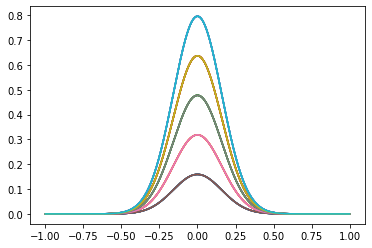

In [22]:
T = np.linspace(-1,1,1000)
for A in 10*[1,2,3,4,5]:
    y = single_gaussian(T,a=A)
    plt.plot(T,y)

The local maxima and minima of the signal characterize five waves labelled P,Q,R,S and T. Their relative shape and size can be used by clinicians to draw conclusions about the cardiac health of a patient.

In their 2003 paper, McSherry et al. proposed a model for generating a synthetic ECG signal using a system of ordinary differential equations (ODEs). A brief explanation of this system is given below, with a focus on its connection to the generated ECG signal (i.e. how it works), whereas the motivation behind the system (i.e. why it works) is largely ignored.

The solution $z$ of the third differential equation in the system represents the actual ECG signal as a function of time, whereas the solutions $x$ and $y$ of the first two equations have to do with the duration of each heartbeat (note that we are omitting the argument $t$ throughout, writing e.g. $x$ for $x(t)$):

$$\begin{cases}
\dot{x} = \alpha(x,y) x - \omega y\\
\dot{y} = \alpha(x,y) y + \omega x\\
\dot{z} = -\sum_{i \in \{P,Q,R,S,T\}} a_i \Delta \theta_i(y,x) \exp \left( \frac{-(\Delta \theta_i(y,x))^2}{2b_i^2} \right)-(z-z_0)
\end{cases}$$

where

$$ \alpha(x(t),y(t)) = 1 - \sqrt{x^2(t)+y^2(t)} \qquad \Delta \theta_i(y(t),x(t)) = (\text{atan2}(y(t),x(t))-\theta_i) \mod 2\pi \qquad z_0(t) = 0.005 \sin(2 \pi t f_2)$$

The parameters $a=(a_P, a_Q, a_R, a_S, a_T), b=(b_P, b_Q, b_R, b_S, b_T)$ and $\theta = (\theta_P, \theta_Q, \theta_R, \theta_S, \theta_T)$ are time-independent five-dimensional vectors which primarily determine the structure of the waves comprising the ECG signal, which is why their entries are indexed with the names of the waves. $a$ determines the amplitude of each wave (i.e. how low/high its minimum/maximum is), $b$ determines the width of each wave, and $\theta$ determines the position of each wave within a heartbeat.

$\omega$ is a time-dependent function responsible for modelling changes in duration between two heartbeats. The biological processes which it models and its mathematical construction exceed the scope of this tutorial, however. Here, it is treated as a time-independent constant. Thus, the simplified model below generates a sequence of largely identical heartbeats.

Changes between heartbeats only result from a wandering baseline frequency (implemented via $z_0$, which contains the (constant) respiratory frequency $f_2$) and noise added to the simulated ECG signal in order to simulate measurement errors.

Constant omega ($\forall t: \omega(t) = c$ for some $c \in [0, 2\pi)$) means that $x(t) = cos(ct)$ and $y(t) = sin(ct)$ and as such $\Delta \theta_i(y,x) = ct$, so we could limit ourselves to the last differential equation in order to simulate our ECG.

Things simplify even further if we omit the baseline-wander-related error term $z-z_0$. $z$ can then be explictly computed as the antiderivative of $z'$:

$$ z(t) = \sum_{i \in \{P,Q,R,S,T\}} a_i \frac{2 b_i^2}{2c} \exp \left( -\frac{(ct - \theta_i)^2}{2b_i^2}\right) = \frac{1}{c}\sum_{i \in \{P,Q,R,S,T\}} a_ib_i^2 \exp \left( -\frac{(ct - \theta_i)^2}{2b_i^2}\right)$$

In order to specify the model, $\theta$, $a$ and $b$ are given default values which will then be varied in order to generate different simulations. They are grouped together in the params_ODE dictionary below, along with the (unvarying) respiratory frequency $f_2=0.25$.

The simulation itself requires a variety of internal parameters. Some (e.g. the initial value pos_0) pertain to the numerical solution of the ODE system (which employs a standard Runge-Kutta method, the socalled Dormand-Prince method), others have to do with the specific nature of modeling a signal corresponding to measurements over time (e.g. the model-internal sampling frequency, sf_int, and the sampling frequency of the synthetic ECG output, sf_ecg), and a few correspond to biological quantities (e.g. the mean heartrate, heartrate_mean). All simulation-related parameters are compiled into a dictionary (params_sim) below.

Of these, the signal duration and the sampling frequencies are kept fixed in this tutorial, because this ensures a signal of constant length in each run of the simulator, which is a prerequisite for the chosen (convolutional) neural architecture to function. The mean heartrate, by contrast, is varied alongside the ODE parameters. A specific mean heartrate requires a rescaling of the positional and width parameters $\theta$ and $b$, so these parameters, at least, are not independent.

We next turn to the implementation of our ECG simulation model, which begins by initializing our parameters.

### 1: Implementing the ECG Model

Much of the implementation below is inspired by McSharry et al.'s (2003) own work ( https://github.com/neuropsychology/NeuroKit ). Several changes were made with readability in mind, however: our code is packaged into a greater number of individual functions, and our variable names are often a bit more explicit than their counterparts in NeuroKit. Where possible, vectorized implementations were chosen over loops in order to speed up computation.

In [23]:
# Function to initialize the various model parameters.
# Details on the role of each parameter are given below.

def initialize_model_parameters(
    theta = np.pi*np.asarray([-1/3,-1/12,0,1/12,0.5]), \
    a = np.asarray([1.2,-5.0,30.0,-7.5, 0.75]), \
    b = np.asarray([0.25, 0.1, 0.1, 0.1, 0.4]), \
    f_2 = 0.25, \
    Nt = 5000, pos_0 = np.asarray([1,0,0.04]), \
    sf_int = 1000, sf_ecg = 250, \
    noise_amp = 0.01, noise_freq = 100, noise_type = 'laplace', \
    heartrate_mean = None, heartrate_std = 1, \
    duration = 30, N_heartbeats = None, \
    phase_offset = None, reparametrize=False
):

    ## ODE system parameters

    # theta: PQRST positions (as specified in the paper)
    # The original Matlab and later NeuroKit implementations use an approximation instead:
    # theta = np.array([-70, -15, 0, 15, 100])/180*np.pi

    # a: PQRST height modifiers
    
    # b: PQRST width modifiers
    
    # f_2: Respiratory frequency
    if reparametrize:
        params_ODE = {'d': a*b*b, 'b': b, 'theta': theta, 'f_2': f_2}
    else:
        params_ODE = {'a': a, 'b': b, 'theta': theta, 'f_2': f_2}

    ## Parameters for numeric integration of ODE system

    # Nt: No of samples / times t at which to integrate
    
    # pos_0: Initial value for initial value problem to be solved
    # (other candidate: pos_0 = np.asarray([1, 0, 0]))

    # sf_int: Internal sampling frequency
    
    # sf_ecg: Sampling frequency of ecg; in practice, ECGs can be measured with a 
    # variety of sampling frequencies. 250 and 360 are typical choices, and the
    # lower frequency was selected here to keep the size of simulated data samples
    # as manageable as possible.
    
    # noise_amp, noise_freq, noise_type: Parameters of additive noise (amplitude, frequency, type)
    
    # heartrate_mean, heartrate_std: Mean and standard deviation of heart rate 
    # (take precedent over number of samples if both are given)
    
    # duration, N_heartbeats: if heartrate_mean and heartrate_std are provided, the duration of the ecg signal
    # or an approximate number of heartbeats must be specified
    # If both are given, duration takes precedent over the approximate number of heartbeats.
    
    # phase_offset: a fraction (between 0 and 1) by which the start of the signal is shifted right
    # from the first R-peak (equivalently: the fraction of the first heartbeat generated which is removed
    # from the output). If None is given, this parameter is chosen randomly during signal generation.

    # The dependent parameters used by the numerical method used to solve the system of ODEs
    # are based around max_t, the latest time point t at which the approximate solution is computed:
    # t_span is a list of the first and list t (i.e. 0 and max_t), and t_eval is an array of Nt time points
    # within this range. Note that all of these parameters are always recomputed below, since we systematically
    # supply a mean heartrate.
    max_t = (Nt-1)*(1/sf_int)
    t_span = [0, max_t]
    t_eval = np.linspace(0, max_t, Nt)

    params_sim = {'sf_int': sf_int, 'sf_ecg': sf_ecg, 'Nt': Nt, 'max_t': max_t, \
                  'pos_0': pos_0, 't_span': t_span, 't_eval': t_eval, \
                  'noise_amplitude': noise_amp, 'noise_frequency': noise_freq, 'noise_type': noise_type, \
                  'heartrate_mean': heartrate_mean, 'heartrate_std': heartrate_std, \
                  'duration': duration, 'N_heartbeats': N_heartbeats, 'phase_offset': phase_offset}

    print("\n Params ODE:")
    print(params_ODE)
    print("\n Params simulation:")
    print(params_sim)
    
    return(params_ODE, params_sim)

### Implementation of the FMM_ecg model (Rueda et al. 2021)
def initialize_FMM(M_FMM = 0.03, \
                   A_FMM = (1/1164)*np.asarray([-10.0,5.0,-30.0,7.0, -15.0]), 
                   #A_FMM = (1/1050)*np.asarray([-9.0,4,-27.0,8, -13.5]), \
                   alpha_FMM= np.pi*np.asarray([-1/3,-1/12,0,1/12,0.5]), 
                   beta_FMM=np.zeros(5), \
                   omega_FMM=np.asarray([0.21,0.06,0.045,0.06,0.27]), \
                   f2_FMM = 0.25, \
                   sigma_FMM=0.05):
    

    params_FMM = {'M_FMM': M_FMM, 'A_FMM': A_FMM, 'alpha_FMM': alpha_FMM, 'beta_FMM': beta_FMM, \
                  'omega_FMM': omega_FMM, 'f2_FMM': f2_FMM, 'sigma_FMM': sigma_FMM}
    
    # M_FMM is a vertical offset
    # A_FMM determines the amplitude of the five ECG waves
    # alpha_FMM determines the location of the five ECG waves
    # beta_FMM determines the skewness/asymmetry of the five ECG
    # omega_FMM determines the width of the five ECG waves
    
    print("\nFMM parameters:")
    print(params_FMM)
    
    return params_FMM

In [24]:
# params_FMM = initialize_FMM()
# params_GM, params_sim = initialize_model_parameters()
# params_sim['duration'] = 1
# params_sim['heartrate_mean'] = 60
# xdata_GM, ydata_GM, zdata_GM = generate_ECG(params_GM, params_sim, baseline_wander=True)
# xdata_FMM, ydata_FMM, zdata_FMM = generate_ECG(params_FMM, params_sim, baseline_wander=True)

# fig_2d = plt.figure(figsize=(10,8))
# ax_2d = plt.axes()
# plt.xlabel("Time (s)")
# plt.ylabel("Frequency (Hz)")
# ax_2d.plot(np.arange(len(zdata_FMM)), zdata_FMM, label='FMM')
# ax_2d.plot(np.arange(len(zdata_FMM)), zdata_GM, label='GM')
# ax_2d.legend()
# plot_ecg_segment(zdata_FMM, params_sim['sf_ecg'])
# plot_ecg_segment(zdata_GM, params_sim['sf_ecg'])

In [25]:
# For the sake of convenience, several parameters to do with training are currently
# read from an options file, ecg_options.txt.
sf_ecg = 250
model_par_list = ['a', 'b', 'theta']
sim_par_list = []
variation_mean = np.zeros(5)
stdn = np.ones(5)
trunc_low = -np.ones(5)
trunc_high = 0.005*np.ones(5)
summary_net_type = 'CNN'
patience = 10
coupling_block_size = 64
spectral_normalization = False
train_epochwise = False
default_priors = True

with open("ecg_options.txt") as opt_file:
    for line in opt_file.readlines():
        if line.find("Duration") != -1:
            duration = int(re.search(r'\"(.*?)\"', line).group(1))
        elif line.find("ECG sampling frequency") != -1:
            sf_ecg = int(re.search(r'\"(.*?)\"', line).group(1))
        elif line.find("Model Parameters to Vary") != -1 or line.find("ODE Parameters to Vary") != -1:
            model_par_list = ast.literal_eval(re.search(r'\"(.*?)\"', line).group(1))
        elif line.find("Use default priors") != -1:
            default_priors = ast.literal_eval(re.search(r'\"(.*?)\"', line).group(1))
        elif line.find("Variation mean") != -1:
            variation_mean = ast.literal_eval(re.search(r'\"(.*?)\"', line).group(1))
        elif line.find("Variation Standard Deviation") != -1:
            stdn = ast.literal_eval(re.search(r'\"(.*?)\"', line).group(1))
        elif line.find("Variation lower bound") != -1:
            trunc_low = ast.literal_eval(re.search(r'\"(.*?)\"', line).group(1))
        elif line.find("Variation upper bound") != -1:
            trunc_high = ast.literal_eval(re.search(r'\"(.*?)\"', line).group(1))
        elif line.find("Simulation Parameters to Vary") != -1:
            sim_par_list = ast.literal_eval(re.search(r'\"(.*?)\"', line).group(1))
        elif line.find("Baseline wander") != -1:
            baseline_wander = ast.literal_eval(re.search(r'\"(.*?)\"', line).group(1))
        elif line.find("Summary Net") != -1:
            summary_net_type = re.search(r'\"(.*?)\"', line).group(1)
        elif line.find("n_summary") != -1:
            n_summary = int(re.search(r'\"(.*?)\"', line).group(1))   
        elif line.find("Depth INN") != -1:
            depth_INN = int(re.search(r'\"(.*?)\"', line).group(1))
        elif line.find("Coupling block size") != -1:
            coupling_block_size = int(re.search(r'\"(.*?)\"', line).group(1))
        elif line.find("Spectral normalization") != -1:
            spectral_normalization = ast.literal_eval(re.search(r'\"(.*?)\"', line).group(1))
        elif line.find("Presimulation path") != -1:
            presimulation_path = re.search(r'\"(.*?)\"', line).group(1)
        elif line.find("Checkpoint path") != -1:
            checkpoint_path = re.search(r'\"(.*?)\"', line).group(1)
        elif line.find("Number of epochs") != -1:
            epochs = int(re.search(r'\"(.*?)\"', line).group(1))
        elif line.find("Train epoch-wise") != -1:
            train_epochwise = ast.literal_eval(re.search(r'\"(.*?)\"', line).group(1))
        elif line.find("Patience") != -1:
            patience = int(re.search(r'\"(.*?)\"', line).group(1))
        elif line.find("Initial learning rate") != -1:
            initial_lr = float(re.search(r'\"(.*?)\"', line).group(1))
        elif line.find("Learning rate change points") != -1:
            lr_changepoints = ast.literal_eval(re.search(r'\"(.*?)\"', line).group(1))
        elif line.find("Learning rates") != -1:
            learning_rates = ast.literal_eval(re.search(r'\"(.*?)\"', line).group(1))
        elif line.find("Iterations per epoch") != -1:
            iterations_per_epoch = int(re.search(r'\"(.*?)\"', line).group(1))
        elif line.find("Batch size") != -1:
            batch_size = int(re.search(r'\"(.*?)\"', line).group(1))   
#checkpoint_path = 'checkpoints_Oct26_2'
#checkpoint_path = 'checkpoints_Oct31'
checkpoint_path = re.search('tutorial_notebooks\/(.*)', checkpoint_path).group(1)

#Signs of learning: Sep26, Sep27, Sep28
#'/home/rene/Bf_ecg/BayesFlow/docs/source/tutorial_notebooks/checkpoints_Aug31'

if 'd' in model_par_list:
    params_ODE, params_sim = initialize_model_parameters(reparametrize=True)
else:
    params_ODE, params_sim = initialize_model_parameters()

# If the model parameter list intersects with the parameter list for the FMM model, that model is chosen.
if bool(set(model_par_list) & set(['A_FMM','alpha_FMM', 'beta_FMM', 'omega_FMM', 'M_FMM'])):
    params_model = initialize_FMM()
else:
    params_model = params_ODE
#params_sim['duration'] = 1
params_sim['duration'] = duration


 Params ODE:
{'d': array([ 0.075, -0.05 ,  0.3  , -0.075,  0.12 ]), 'b': array([0.25, 0.1 , 0.1 , 0.1 , 0.4 ]), 'theta': array([-1.04719755, -0.26179939,  0.        ,  0.26179939,  1.57079633]), 'f_2': 0.25}

 Params simulation:
{'sf_int': 1000, 'sf_ecg': 250, 'Nt': 5000, 'max_t': 4.999, 'pos_0': array([1.  , 0.  , 0.04]), 't_span': [0, 4.999], 't_eval': array([0.000e+00, 1.000e-03, 2.000e-03, ..., 4.997e+00, 4.998e+00,
       4.999e+00]), 'noise_amplitude': 0.01, 'noise_frequency': 100, 'noise_type': 'laplace', 'heartrate_mean': None, 'heartrate_std': 1, 'duration': 30, 'N_heartbeats': None, 'phase_offset': None}


Below, the model is implemented in the spirit of functional programming: the differential equations are organized as combinations of simpler functions. 

Once the ODE system has been defined (ECG_model), an infrastructure for numerically solving it is created, which involves potentially rescaling various parameters based on the mean heartrate. Postprocessing of the signal includes rescaling the signal to lie between $-0.4$ and $+1.2$ Hz and adding noise.

Simulations are run via the generate_ECG function. At its core is the solution of the ODE system, which has to be given an initial value (in the form of the variable pos_0) in order to be uniquely solvable. A standard numerical method for solving systems of ODEs is used here: the Dormand-Prince method ( https://en.wikipedia.org/wiki/Dormand%E2%80%93Prince_method ), which is the default choice for scipy's integrate.solve_ivp method. 

We also provide a function for visualizing a segment of ECG.

In [26]:
## Implementation of the system of ODEs used in the model

# Helper functions
def alpha(x,y):
    return(1-((x**2 + y**2)** .5))

def delta_theta(x,y,theta):
    return(np.fmod(np.arctan2(y,x)-theta,2*np.pi))

def delta_alpha(x,y,alpha_FMM):
    return(np.fmod(np.arctan2(y,x)-alpha_FMM+np.pi,2*np.pi))
    
def gauss_sum(x,y,a,b,theta):
    d_p = delta_theta(x,y,theta)
    gauss_summands = a*d_p*np.exp(-0.5*((d_p/b)**2))
    return(-np.sum(gauss_summands))

def FMM_sum(x,y,A_FMM,alpha_FMM,beta_FMM,omega_FMM):
    tan_p = np.tan(delta_alpha(x,y,alpha_FMM)/2)
    FMM_summands = A_FMM*omega_FMM*np.sin(beta_FMM + \
                    2*np.arctan(omega_FMM*tan_p))*(1+tan_p**2)/(1+omega_FMM*omega_FMM*tan_p*tan_p)
    return(-np.sum(FMM_summands))

# Note that the paper specifies A = 0.15, but this distorts the entire signal
# rather than just creating baseline wander.
def z_0(t,f_2, A=0.0005):#A=0.005):
    return(A*np.sin(2*np.pi*f_2*t))

# Handles the logic of whether baseline wander is applied or not
def get_z_zero(baseline_wander):
    if baseline_wander:
        z_zero = z_0
    else:
        z_zero = lambda t, f_2: 0
    return(z_zero)

# Actual system of ODEs
def ECG_model(t, p, T_om, params_ODE, params_sim, omega, z_zero, baseline_wander=False):
    alpha_yx = alpha(p[0],p[1])
    omega_T = omega(t, T_om, params_sim['sf_int'], params_sim['Nt'])
    
    position = [alpha_yx*p[0]-omega_T*p[1], alpha_yx*p[1]+omega_T*p[0], \
                gauss_sum(p[0],p[1],params_ODE['a'],params_ODE['b'],params_ODE['theta']) \
                - p[2]+z_zero(t,params_ODE['f_2'])]
    
    return(position)

def ECG_model_FMM(t, p, T_om, params_model, params_sim, omega, z_zero, baseline_wander=False):
    alpha_yx = alpha(p[0],p[1])
    omega_T = omega(t, T_om, params_sim['sf_int'], params_sim['Nt'])
    
    position = [alpha_yx*p[0]-omega_T*p[1], alpha_yx*p[1]+omega_T*p[0], \
                omega_T*FMM_sum(p[0],p[1],params_model['A_FMM'],params_model['alpha_FMM'],params_model['beta_FMM'], \
                       params_model['omega_FMM'])- p[2]+z_zero(t,params_model['f2_FMM'])]
    
    return(position)

# Explicit solution in case there is no baseline wander
def Explicit_ECG(params_model, params_sim, omega):
    t_eval = params_sim['t_eval']
    Nt = params_sim['Nt']
    x = np.cos(omega*t_eval)
    y = np.sin(omega*t_eval)
    z = np.zeros(Nt)
    
    if bool(set(params_model.keys()) & set(['a','b','theta'])):
        b = params_model['b']
        theta = params_model['theta']
        
        if 'd' in params_model.keys():
            d = params_model['d'] 
            for i in range(5):
                z += d[i]*np.exp(-(delta_theta(x,y,theta[i]))**2 / (2*b[i]*b[i]))
        else:
            a = params_model['a'] 
            for i in range(5):
                z += (a[i]*b[i]*b[i])*np.exp(-(delta_theta(x,y,theta[i]))**2 / (2*b[i]*b[i]))
        
        z *= (1/omega)
    else:
        omega_FMM = params_model['omega_FMM']
        alpha_FMM = params_model['alpha_FMM']
        beta_FMM = params_model['beta_FMM']
        A_FMM = params_model['A_FMM']
        M_FMM = params_model['M_FMM']
        #Start at R like GM: T_FMM = np.fmod(t_eval*omega+np.pi, 2*np.pi)
        #Start before P unlike GM: T_FMM = np.fmod(t_eval*omega, 2*np.pi)
        
        for i in range(5):
            #z += A_FMM[i]*np.cos(beta_FMM[i]+2*np.arctan(omega_FMM[i]*np.tan((T_FMM-alpha_FMM[i])/2)))
            z += A_FMM[i]*np.cos(beta_FMM[i]+2*np.arctan(omega_FMM[i]*np.tan(delta_alpha(x,y,alpha_FMM[i])/2)))
        z += M_FMM
    
    return(x, y, z)

## Functions used to rescale the parameters depending on the inputs given

# If a mean heartrate is specified, the PQRS locations and widths have to be adapted.
def rescale_ODE_params(params_ODE, heartrate_mean):
    hr_fact = (heartrate_mean/60)**0.5
    hr_fact2 = hr_fact**0.5
    
    params_ODE_rescaled = copy.deepcopy(params_ODE)
    params_ODE_rescaled['theta'] *= np.array([hr_fact2, hr_fact, 1, hr_fact, hr_fact2])
    params_ODE_rescaled['b'] *= hr_fact
    return(params_ODE_rescaled)

def rescale_FMM_params(params_model, heartrate_mean):
    hr_fact = (heartrate_mean/60)**0.5
    hr_fact2 = hr_fact**0.5
    
    params_FMM_rescaled = copy.deepcopy(params_model)
    params_FMM_rescaled['alpha_FMM'] *= np.array([hr_fact2, hr_fact, 1, hr_fact, hr_fact2])
    params_FMM_rescaled['omega_FMM'] *= hr_fact
    return(params_FMM_rescaled)

# In conjunction with the mean heartrate, either a desired duration or
# an approximate number of desired heartbeats (N_heartbeats) must be specified. 
# The unknown quantity is computed from the one given (e.g. unknown N_heartbeats from known duration)
def rescale_simulation_params(params_sim, heartrate_mean):
    params_sim_rescaled = copy.deepcopy(params_sim)
    
    # Ensure that all parameters which have to be integers are in fact integers
    # (Note that several parameters, e.g. the mean heartrate, may be defined as integers by the user,
    # but this is not a conceptual or numerical requirement at any point.)
    for int_param in ['sf_int', 'sf_ecg', 'Nt', 'noise_frequency', 'N_heartbeats']:
        val = params_sim[int_param]
        if val is not None:
            params_sim_rescaled[int_param] = int(val)
    
    d = params_sim['duration']
    N = params_sim['N_heartbeats']
    
    if d is not None:    
        # Determine approximate number of heartbeats
        N = int(np.round(params_sim['duration'] * (heartrate_mean / 60)))
        params_sim_rescaled['N_heartbeats'] = N
        #print(N)
    else:
        if N is None:
            print("Please specify either a duration or an approximate number of heartbeats.")
        else:
            # Determine duration
            d = N*60/heartrate_mean
            params_sim_rescaled['duration'] = d
             
    # Determine number of samples needed and latest time point
    # Add a buffer of 1 second (i.e. 1 x sf_int) which will be trimmed off at the end
    Nt = int(d*params_sim['sf_int'])+params_sim['sf_int']
    params_sim_rescaled = rescale_Nt(params_sim_rescaled, Nt)
    
    return(params_sim_rescaled)

def rescale_Nt(params_sim, Nt):
    params_sim_res = copy.deepcopy(params_sim)
    
    max_t = (Nt-1)*(1/params_sim['sf_int'])
    
    params_sim_res['Nt'] = Nt
    params_sim_res['max_t'] = max_t
    params_sim_res['t_eval'] = np.linspace(0,max_t,Nt)
    params_sim_res['t_span'] = [0, max_t]
    
    return(params_sim_res)

# Handles the logic behind rescaling the parameters (rescaling occurs if a mean heartrate is given)
def rescale_if_needed(params_model, params_sim):
    hr_mean = params_sim['heartrate_mean']
    if hr_mean is not None:
        if hasattr(hr_mean, "__len__"):
            hr_mean = hr_mean[0]
        # Rescale location and width of PQRST signals to match mean heart rate
        if 'theta' in params_model.keys():
            params_model_r = rescale_ODE_params(params_model, hr_mean)
        else:
            params_model_r = rescale_FMM_params(params_model, hr_mean)
        # Rescale simulation parameters (time points for evaluation etc) to match mean heart rate
        params_sim_r = rescale_simulation_params(params_sim, hr_mean)
    else:
        params_model_r = copy.deepcopy(params_model)
        # Set Nt to match the user-specified duration, plus a buffer of sf_int (the equivalent of
        # 1s of signal) which will be trimmed off at the end of the simulation process.
        Nt = int(params_sim['duration']*params_sim['sf_int'])+params_sim['sf_int']
        params_sim_r = rescale_Nt(params_sim, Nt)
    return params_model_r, params_sim_r

# Trims 1 x sf_int (the equivalent of 1s of signal) off the signal
# A random portion is trimmed off the left, the rest is trimmed off the right
def trim_signal(x_int, y_int, z_int, params_sim_r):
    sf_int = params_sim_r['sf_int']
    offset = params_sim_r['phase_offset']
    if offset is None:
        l = np.random.randint(low=0, high=int(sf_int/2))
    else:
        l = int(offset*sf_int)
    h = sf_int-l
    return(x_int[l:-h],y_int[l:-h],z_int[l:-h])

## Functions used to downsample should the target ecg sampling frequency (sf_ecg) not correspond
## to the internal sampling frequency (sf_int)

# q is the ratio between the internal and the ecg sampling rate.
def get_downsampling_stepsize(params_sim):
    sf_int = params_sim['sf_int']
    sf_ecg = params_sim['sf_ecg']
    q = np.round(sf_int/sf_ecg)
    qd = sf_int/sf_ecg
    if q != qd:
        raise ValueError(
            "Internal sampling frequency (sfint) must be an integer multiple of the ECG sampling frequency"
            " (sfecg). Your current choices are: sfecg = "
            + str(sf_ecg)
            + " and sfint = "
            + str(sf_int)
            + "."
        )
    return(int(q))

# Handles the logic behind downsampling (downsampling occurs if q is greater than one)
def downsample_if_needed(q, x_int, y_int, z_int):
    # Downsample the signal to sf_ecg (via q = round(sf_int/sf_ecg) )
    if q != 1:
        x = x_int[np.arange(0, len(x_int), step=q).astype(int)]
        y = y_int[np.arange(0, len(y_int), step=q).astype(int)]
        z = z_int[np.arange(0, len(z_int), step=q).astype(int)]
    else:
        x = x_int
        y = y_int
        z = z_int
    return(x,y,z)

## Post-processing of the ecg signal

# Rescale signal to the range (target_min, target_max)
def rescale_signal(z, target_min, target_max):
    zmin = np.min(z)
    zmax = np.max(z)
    z_diff = zmax-zmin
    if np.isnan(z_diff):
        z = np.zeros(len(z))
    elif z_diff > 0.0005:
        z = (z - zmin) * (target_max-target_min) / (zmax - zmin) + target_min
    else:
        z += -np.mean(z)+(target_max-target_min)/2
    return(z)

# Add additive noise to the signal (typically with a frequency below the sampling frequency)
def add_distortion(signal, noise_amplitude, noise_frequency=100, signal_sampling_rate=1000, \
                   noise_type="laplace", random_state=42):
    #For reproducibility  
    #np.random.seed(random_state)
    
    n_samples = len(signal)
    signal_sd = np.std(signal, ddof=1)
    
    if signal_sd != 0:
        noise_amplitude *= signal_sd
    
    noise = np.zeros(n_samples)
    duration = n_samples / signal_sampling_rate
    # Apply a very conservative Nyquist criterion in order to ensure
    # sufficiently sampled signals.
    nyquist = signal_sampling_rate * 0.1
    if noise_frequency > nyquist:
        if not silent:
            warn(
                f"Skipping requested noise frequency "
                f" of {noise_frequency} Hz since it cannot be resolved at "
                f" the sampling rate of {signal_sampling_rate} Hz. Please increase "
                f" sampling rate to {noise_frequency * 10} Hz or choose "
                f" frequencies smaller than or equal to {nyquist} Hz.",
                category=NeuroKitWarning,
            )
        return noise
    # Also make sure that at least one period of the frequency can be
    # captured over the duration of the signal.

    if (1 / noise_frequency) > duration:
        if not silent:
            warn(
                f"Skipping requested noise frequency "
                f" of {noise_frequency} Hz since its period of {1 / noise_frequency} "
                f" seconds exceeds the signal duration of {duration} seconds. "
                f" Please choose noise frequencies larger than "
                f" {1 / duration} Hz or increase the duration of the "
                f" signal above {1 / noise_frequency} seconds.",
                category=NeuroKitWarning,
            )
        return noise

    noise_duration = int(duration * noise_frequency)

    if noise_type.find('aplace') != -1 or noise_type.find('efault') != -1:
        noise = np.random.laplace(0, noise_amplitude, noise_duration)
    elif noise_type.find('aussian') != -1 or noise_type.find('ormal') != -1:
        noise = np.random.normal(0, noise_amplitude, noise_duration)
    elif noise_type.find('niform') != -1:
        bound = noise_amplitude/2
        noise = np.random.uniform(bound,-bound, noise_duration)
    
    # Resample via interpolation
    n_noise = len(noise)
    if n_noise != n_samples:
        # Use third order splines to interpolate
        noise = ndimage.zoom(noise, n_samples / n_noise)
    
    return signal+noise


## Generating the simulated ecg
def generate_ECG(params_model, params_sim, baseline_wander=True, og_flavor=False, pcw_cst=False):
    # Rescale parameters to fit mean heartrate
    params_model_r, params_sim_r = rescale_if_needed(params_model, params_sim)
    
    # Set the angular velocity to a constant matching the mean heartrate
    if params_sim_r['heartrate_mean'] is not None:
        omega_constant = 2*np.pi/60*params_sim_r['heartrate_mean']
    else:
        omega_constant = 2*np.pi
    T_om = 0
    om = lambda t, T, sf_int, Nt: omega_constant

    # Determine extent of baseline wander
    z_zero = get_z_zero(baseline_wander)
    
    # Generate the signal, either...
    # ...by solving the IVP if there is baseline wander or...
    if baseline_wander:
        if 'A_FMM' in params_model_r.keys():
            x_int, y_int, z_int = integrate.solve_ivp(lambda t, y: \
                                                    ECG_model_FMM(t, y, T_om, params_model_r, \
                                                                  params_sim_r, om, z_zero, \
                                                                  baseline_wander,), \
                                                    params_sim_r['t_span'], params_sim['pos_0'], \
                                                    t_eval=params_sim_r['t_eval']).y
        else:
            x_int, y_int, z_int = integrate.solve_ivp(lambda t, y: \
                                                            ECG_model(t, y, T_om, params_model_r, params_sim_r, \
                                                                      om, z_zero, baseline_wander,), \
                                                            params_sim_r['t_span'], params_sim['pos_0'], \
                                                            t_eval=params_sim_r['t_eval']).y
    # ...by using the explicit solution if there is no baseline wander
    else:
        x_int, y_int, z_int = Explicit_ECG(params_model_r, params_sim_r, omega_constant)
    # Trim signal by 1 x sf_int
    x_int, y_int, z_int = trim_signal(x_int, y_int, z_int, params_sim_r)
    
    # Downsample the signal if needed
    q = get_downsampling_stepsize(params_sim)
    x, y, z = downsample_if_needed(q, x_int, y_int, z_int)
    
    # Rescale the signal to the interval [-0.4, 1.2]
    z = rescale_signal(z,-0.4,1.2)
    
    # Add noise if necessary
    if params_sim['noise_type'] is not None:
        z = add_distortion(z, params_sim['noise_amplitude'], noise_type=params_sim['noise_type'], \
                          signal_sampling_rate= params_sim['sf_int'])  
    
    return(x,y,z)

# Plots a section from an ecg_signal whose sampling frequency is ecg_frequency.
# desired_range is a list of two indices which delimit the section of the signal to plot.
def plot_ecg_segment(ecg_signal, ecg_frequency, figsize=(16,8), desired_range=None):
    # If no desired_range is supplied, the entire signal is plotted.
    if desired_range==None:
        desired_range = [0,len(ecg_signal)]
    
    y = ecg_signal[desired_range[0]:desired_range[1]]
    x_min = desired_range[0]/ecg_frequency
    x_max = desired_range[1]/ecg_frequency
    desired_length = desired_range[1]-desired_range[0]
    x = np.linspace(x_min,x_max,desired_length)
    fig_2d = plt.figure(figsize=figsize)
    ax_2d = plt.axes()
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    ax_2d.plot(x, y)

 $$X(t_i) = \mu(t_i,M,\alpha,\beta,\omega)+e(t_i)$$
 
 for
 
 $$\mu(t,M,\alpha, \beta, \omega) = M + \sum_{J \in \{P,Q,R,S,T\}}A_J \cos\left(\beta_J+2\arctan\left(\omega_J \tan\left(\frac{t-\alpha_J}{2}\right)\right)\right)$$
 
 with $M \in \mathbb{R}$,  $A \in \mathbb{R}_{>0}^{5}$, $\alpha, \beta \in [0,2\pi]^5$, $\alpha_P \leq \alpha_Q \leq \alpha_R \leq \alpha_S \leq \alpha_T$ and $\omega \in [0,1]^5$ as well as
 
 $$(e(t_i), ..., (e(t_n))' \sim N_n(0, \sigma^2I)$$
 
 In order to model the same level of biological complexity as McSharry et al. 2003, we can replace the Gaussian mixing component of the latter model with the derivative of $\mu$, i.e. 
 
$$\begin{cases}
\dot{x} = \alpha(x,y) x - \omega y\\
\dot{y} = \alpha(x,y) y + \omega x\\
\dot{z} = \mu'(x,y)-(z-z_0)
\end{cases}$$
 
Also incorporating adaptable manipulation of time via a constant factor $c$, by the chain rule, the derivative in question is

 $$\mu_c'(t, \alpha, \beta, \omega) = \frac{d}{dt} \sum_{J \in \{P,Q,R,S,T\}}A_J \cos\left(\beta_J+2\arctan\left(\omega_J \tan\left(\frac{ct-\alpha_J}{2}\right)\right)\right) \\
 =  -\sum_{J \in \{P,Q,R,S,T\}} A_J \sin\left(\beta_J+2\arctan\left(\omega_J \tan\left(\frac{ct-\alpha_J}{2}\right)\right)\right) \cdot \frac{1}{1+\omega_J^2 \tan^2\left(\frac{t-\alpha_J}{2}\right)} \cdot 2 \omega_J \left(1+\tan^2\left(\frac{t-\alpha_J}{2}\right)\right) \cdot \frac{c}{2} \\ = -c\sum_{J \in \{P,Q,R,S,T\}} \frac{A_J\omega_J \sin\left(\beta_J+2\arctan\left(\omega_J \tan\left(\frac{t-\alpha_J}{2}\right)\right)\right) \left(1+\tan^2\left(\frac{t-\alpha_J}{2}\right)\right)}{1+\omega_J^2 \tan^2\left(\frac{t-\alpha_J}{2}\right)} $$
 

In [27]:
# params_FMM = initialize_FMM()
# params_GM, params_sim = initialize_model_parameters()
# params_sim['duration'] = 1

In [28]:
#xdata_FMM, ydata_FMM, zdata_FMM = generate_ECG(params_FMM, params_sim, baseline_wander=True)

In [29]:
#plot_ecg_segment(zdata_FMM, params_sim['sf_ecg'])

In [30]:
#xdata_GM, ydata_GM, zdata_GM = generate_ECG(params_GM, params_sim, baseline_wander=True)

In [31]:
#plot_ecg_segment(zdata_GM, params_sim['sf_ecg'])

Here is an example of what a signal generated with our model looks like:

In [32]:
#%timeit xdata, ydata, zdata = generate_ECG(params_ODE, params_sim, baseline_wander=True)

In [33]:
#%timeit xdata, ydata, zdata = generate_ECG(params_ODE, params_sim, baseline_wander=False)

In [34]:
#%timeit xdata, ydata, zdata = generate_ECG(params_model, params_sim, baseline_wander=False)

In [35]:
#params_sim['heartrate_mean'] = 60
#params_sim['duration'] = 10
#params_sim['noise_type'] = 'Laplace'
xdata, ydata, zdata = generate_ECG(params_model, params_sim, baseline_wander=False)
#_, _, z_data = Explicit_ECG(params_ODE, params_sim, omega=2*np.pi, params_FMM=params_FMM)

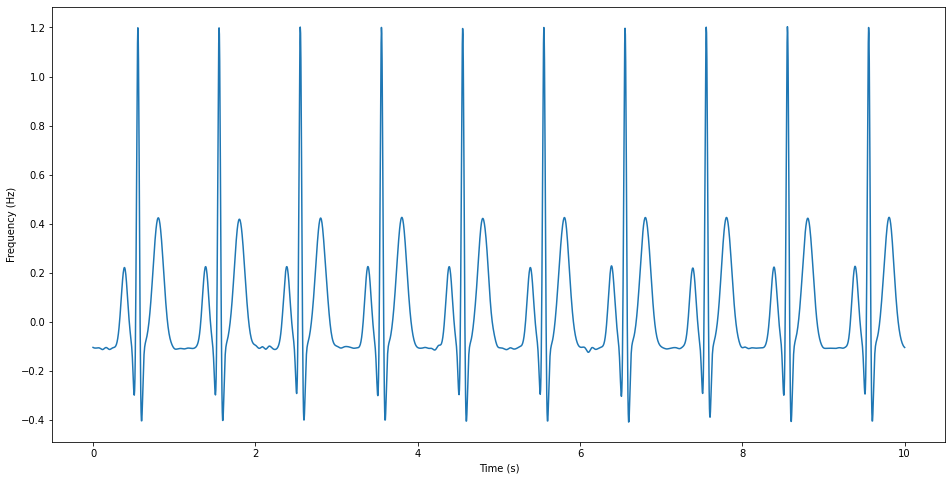

In [36]:
#%matplotlib notebook
plot_ecg_segment(zdata, params_sim['sf_ecg'])
#plt.plot(z_data)

### 2: Building a Generative Model from the Simulator

One of the ways in which BayesFlow can be used is to define a GenerativeModel, a custom class essentially created from two functions: one which generates parameters according to certain distributions (i.e. a prior), and one which generates simulated signals from those parameters (i.e. a simulator). Since our simulator is essentially the generate_ECG function above, the code below focuses primarily on parameter generation and on simulating on batches of parameters (as opposed to a single set of parameters as above).

In [37]:
## Internal utility functions for prior generation

# Retrieves the dimension of a parameter
def get_param_dim(param_name, index_set=None, params_sim=None):
    if index_set is not None:
        return len(index_set)
    else:
        if param_name in ['a', 'd', 'b', 'theta', 'A_FMM', 'alpha_FMM', 'beta_FMM', 'omega_FMM']:
            return 5
        elif param_name == 'pos_0':
            return 3
        elif param_name == 't_span':
            return 2
        elif param_name == 't_eval':
            return len(params_sim['t_eval'])
        else:
            return 1

# Separates parameters related to the ODE system itself from those related to simulation,
# creating dictionaries with the parameter names as keys and lists of indexes (by default: all the indexes
# of the parameter in question) as values
def split_param_list(param_list, params_sim):
    if isinstance(param_list, list):
        param_dict = {i: np.arange(get_param_dim(i)) for i in param_list}
    else:
        param_dict = copy.deepcopy(param_list)
    
    param_dict_sim = {}
    param_dict_model = {}
    for p in param_dict.keys():
        if p in params_sim.keys():
            param_dict_sim[p] = param_dict[p]
        else:
            param_dict_model[p] = param_dict[p] 
    
    return(param_dict_model, param_dict_sim)


# Creates a dictionary containing all necessary information to vary the default parameters.
# Variation occurs via normal distributions with the (potentially multi-dimensional) mean
# and standard deviations provided (by default, entrywise independently) and applied to the default values,
# i.e. if the default is 5, mean=0 and standard_deviation = 0.2, then we draw a value x from a normal
# distribution with mean zero and standard deviation 0.2 and multiply that by 5, adding the result to 5.
# It is possible to truncate these distributions via trunc_low and trunc_high arguments.
# Values close to zero are replaced with 0.005.
def make_variation_dict(param_name, indexes=None, mean=None, standard_deviation=None, trunc_low=None, \
                        trunc_high=None, rejection_sampling = False, entrywise=True, \
                        zero_threshold=0.005, zero_replacement=0.005, distribution=None):
    
    param_dim = get_param_dim(param_name, indexes)
    
    if indexes is None:
        indexes = np.arange(param_dim)
    if mean is None:
        mean = np.zeros(param_dim)
    if standard_deviation is None:
        standard_deviation = 0.05*np.ones(param_dim)
    if trunc_low is None:
        trunc_low = -np.ones(param_dim)
    if trunc_high is None:
        trunc_high = zero_replacement*np.ones(param_dim)

    return {'indexes': indexes, 'mean': np.asarray(mean), \
            'standard_deviation': np.asarray(standard_deviation), \
            'trunc_low': np.asarray(trunc_low), 'trunc_high': np.asarray(trunc_high), \
            'rejection_sampling': rejection_sampling, 'entrywise': entrywise, \
            'zero_threshold': zero_threshold, 'zero_replacement': zero_replacement, \
            'distribution': distribution}    

#     if hasattr(mean, "__len__"):
#         return {'indexes': indexes, 'mean': np.asarray(mean), \
#                 'standard_deviation': np.asarray(standard_deviation), \
#                 'trunc_low': np.asarray(trunc_low), 'trunc_high': np.asarray(trunc_high), \
#                 'rejection_sampling': rejection_sampling, 'entrywise': entrywise, \
#                 'zero_threshold': zero_threshold, 'zero_replacement': zero_replacement, \
#                 'distribution': distribution}    
#     else:
#         return {'indexes': indexes, 'mean': mean, 'standard_deviation': standard_deviation,\
#                 'trunc_low': trunc_low, 'trunc_high': trunc_high, 'rejection_sampling': rejection_sampling,\
#                 'entrywise': entrywise, 'zero_threshold': zero_threshold,\
#                 'zero_replacement': zero_replacement, 'distribution': distribution}

    
## Prior generation

def generate_single_param_prior_nondefault(p_name, variation_dict, hr_factor=None):
    if p_name == 'heartrate_mean':
        output_p = 205
        while output_p > 200:
            output_p = scipy.stats.lognorm.rvs(s=1, loc=0, scale=3, size=1)*20 + 40
        return np.asarray([output_p])

    n = get_param_dim(p_name, variation_dict['indexes'])
    
    distribution = variation_dict['distribution']
    deviation_mean = variation_dict['mean']
    deviation_std = variation_dict['standard_deviation']
    trunc_low = variation_dict['trunc_low']
    trunc_high = variation_dict['trunc_high']
    
    if distribution == 'normal':
        if trunc_low is not False:
            output_p = trunc_low-1
            while (output_p < trunc_low).any() or (output_p > trunc_high).any():
                output_p = np.random.normal(deviation_mean, deviation_std, n)
        else:
            output_p = np.random.normal(deviation_mean, deviation_std, n)
    elif distribution == 'uniform':
        if trunc_low is False:
            print("Must supply a lower and upper bound (trunc_low and trunc_high) when sampling from \
                  uniform distribution.")
            return None
        output_p = np.random.uniform(trunc_low, trunc_high, n)
    else:
        print(f"{distribution} is not a known distribution. Choose between normal and uniform.")
        return None
    
    if p_name in ['theta', 'alpha']:
        output_p = np.sort(output_p)
        
    # Ensure that the output is an array of arrays (as opposed to an array of floats)
    if np.ndim(output_p[0]) == 0:
        output_p = np.asarray([[output_p[i]] for i in range(len(output_p))])
    
    if np.ndim(output_p) == 0:
        output_p = np.array([output_p])
    
    return(output_p)
        

def generate_single_param_prior_nondefault_batch(p_name, batch_size, variation_dict, hr_factors=None):
    if p_name == 'heartrate_mean':
        output_p = 20*scipy.stats.lognorm.rvs(s=1, loc=0, scale=3, size=batch_size)+40
        for i in range(batch_size):
            while output_p[i] > 200:
                output_p[i] = 20*scipy.stats.lognorm.rvs(s=1, loc=0, scale=3, size=1)+40         
        output_p = output_p[:batch_size, np.newaxis]
        return(output_p)    
    
    n = get_param_dim(p_name, variation_dict['indexes'])
    
    distribution = variation_dict['distribution']
    deviation_mean = variation_dict['mean']
    deviation_std = variation_dict['standard_deviation']
    trunc_low = variation_dict['trunc_low']
    trunc_high = variation_dict['trunc_high']
    
    
    if distribution == 'normal':
        output_p = np.random.normal(deviation_mean, deviation_std, (batch_size,n))
        if trunc_low is not False:
            for i in range(batch_size):
                    output_row = output_p[i,:]
                    while (output_row < trunc_low).any() or (output_row > trunc_high).any():
                        output_p[i,:] = np.random.normal(deviation_mean, deviation_std)
                        output_row = output_p[i,:]
    elif distribution == 'uniform':
        if trunc_low is False:
            print("Must supply a lower and upper bound (trunc_low and trunc_high) when sampling from \
                  uniform distribution.")
            return None
        output_p = np.random.uniform(trunc_low, trunc_high, (batch_size,n))
    else:
        print(f"{distribution} is not a known distribution. Choose between normal and uniform.")
        return None
    
    if p_name in ['theta', 'alpha']:
        for i in range(batch_size):
            output_p[i,:] = np.sort(output_p[i,:])
    
    # Ensure that the output is an array of arrays (as opposed to an array of floats)
    if np.ndim(output_p[0]) == 0:
        output_p = np.asarray([[output_p[i]] for i in range(len(output_p))])
    
    return(output_p)


# Draws from the prior distribution of a single parameter (scalar or vector)
# The distribution in question is either 
# 1) a family of independent normal distributions centered around the default value of 
# each of the parameter's entries with a standard deviation 0.05 if entrywise is True, or
# 2) induced by muliplying the parameter with a random number with mean 0 and std 0.05 and adding
# the result to the original parameter (i.e. varying each entry by the same percentage between -5% and +5%)
# Approach 1) is the default, since approach 2) creates a degenerate prior which renders learning impossible.
# Approach 2) is only shown here to exemplify a potential caveat for priors used with BayesFlow, see below.
def generate_single_param_prior(parameter, p_name, variation_dict, hr_factor=None):
    
    # The mean heartrate is varied according to a log normal distribution shifted right by 40
    # and truncated at 200
    if p_name == 'heartrate_mean':
        output_p = 205
        while output_p > 200:
            output_p = scipy.stats.lognorm.rvs(s=1, loc=0, scale=3, size=1)*20 + 40
        return np.asarray(output_p)
    
    if isinstance(parameter, int):
        parameter = float(parameter)
    
    # Differentiate between one-dimensional and multi-dimensional parameters
    # and replace values close (or identical) to zero with a small number (the variable zero_replacement)
    zero_replaced = False
    zero_threshold = variation_dict['zero_threshold']
    zero_replacement = variation_dict['zero_replacement']
    deviation_mean = variation_dict['mean']
    if hasattr(parameter, "__len__"):
        parameter_backup = copy.deepcopy(parameter)
        parameter = parameter[variation_dict['indexes']]
        n = len(parameter)
        zero_indexes = np.where(np.absolute(parameter) < zero_threshold)[0]
        if len(zero_indexes) > 0:
            parameter[np.absolute(parameter) < zero_threshold] = zero_replacement
            zero_replaced = True
    else:
        n = 1
        if np.absolute(parameter) < zero_threshold:
            parameter = zero_replacement
            deviation_mean -= zero_replacement          
    
    entrywise = variation_dict['entrywise']
    deviation_std = variation_dict['standard_deviation']
    trunc_low = variation_dict['trunc_low']
    trunc_high = variation_dict['trunc_high']

    if entrywise:
        variation_coefficient = np.random.normal(deviation_mean, deviation_std, n)
        if trunc_low is not False:
            # Rejecting and re-rolling samples with the intended standard deviation (0.66)
            # and bounds (-1 and 0) slows prior generation down immensely.
            # As such, re-rolling was replaced by deterministic alterations: values that are too high
            # have their sign switched, and values that are too low are raised to the lower
            # truncation bound. The former change essentially mirrors the right half of the normal
            # distribution onto the left, whereas the latter change increases the probability of the
            # lower bound. In practice, this is acceptable.
            variation_coefficient[variation_coefficient > trunc_high] *= -1.0
            low_indexes = (variation_coefficient < trunc_low)
            variation_coefficient[low_indexes] = trunc_low[low_indexes]
    else:
        variation_coefficient = np.random.normal(deviation_mean, deviation_std)
        if trunc_low is not False:
            while variation_coefficient < trunc_low or variation_coefficient > trunc_high:
                variation_coefficient = np.random.normal(deviation_mean, deviation_std)
        
    output_p = parameter + parameter*variation_coefficient
    
    if zero_replaced:
        output_p[zero_indexes] -= zero_replacement
    
    # Reject prior samples that are blatantly physiologically impossible:
    # This includes samples in which the PQRST peaks are not an alternating series of local
    # maxima and minima (in that order) and those in which the R peak is not the most pronounced peak
    if variation_dict['rejection_sampling']:
        if p_name == 'a':
            correct_signs = np.sign(parameter)
            scaled_out = [hr_factor**0.5, hr_factor, 1, hr_factor, hr_factor**0.5]*output_p
            max_non_R = max(max(np.absolute(scaled_out[:2])), max(np.absolute(scaled_out[3:])))
            sign_misalignment = (np.sign(output_p) != correct_signs).any()
            if sign_misalignment or max_non_R > 0.5*output_p[2]:
                   output_p = parameter
    
    # It also includes samples in which the PQRST waves do not appear in order.
    # The latter cannot be opted out of, since the results would not simply be medically absurd,
    # but also (and perhaps more importantly) uninterpretable.
    if p_name in ['theta', 'alpha']:
        output_p = np.sort(output_p)
        finished_parameter = copy.deepcopy(parameter_backup)
        finished_parameter[variation_dict['indexes']] = np.sort(output_p)
        if np.sort(finished_parameter) != finished_parameter:
            output_p = parameter_backup[variation_dict['indexes']]
            
    # Ensure that the output is an array (as opposed to a float)  
    if np.ndim(output_p) == 0:
        output_p = np.array([output_p])
    
    return(output_p)


# Batched version of the above function
def generate_single_param_prior_batch(parameter, p_name, batch_size, variation_dict, hr_factors=None):
    if p_name == 'heartrate_mean':
        output_p = 20*scipy.stats.lognorm.rvs(s=1, loc=0, scale=3, size=batch_size)+40
        for i in range(batch_size):
            while output_p[i] > 200:
                output_p[i] = 20*scipy.stats.lognorm.rvs(s=1, loc=0, scale=3, size=1)+40         
        output_p = output_p[:batch_size, np.newaxis]
        return(output_p)    
    
    if isinstance(parameter, int):
        parameter = float(parameter)
    
    indices = variation_dict['indexes']
    
    zero_replaced = False
    zero_threshold = variation_dict['zero_threshold']
    zero_replacement = variation_dict['zero_replacement']
    deviation_mean = variation_dict['mean']
    if hasattr(parameter, "__len__"):
        parameter = parameter[indices]
        n = len(parameter)
        zero_indices = np.where(np.absolute(parameter) < zero_threshold)[0]
        if len(zero_indices) > 0:
            parameter[np.absolute(parameter) < zero_threshold] = zero_replacement
            zero_replaced = True
    else:
        n = 1
        if np.absolute(parameter) < zero_threshold:
            parameter = zero_replacement
            deviation_mean -= zero_replacement         
    
    output_p = np.tile(parameter, (batch_size,1))
    
    entrywise = variation_dict['entrywise']
    deviation_std = variation_dict['standard_deviation']
    trunc_low = variation_dict['trunc_low']
    trunc_high = variation_dict['trunc_high']
    
    if entrywise:
        variation_coefficients = np.random.normal(deviation_mean, deviation_std, (batch_size, n))
        if trunc_low is not False:
            for i in range(batch_size):
                coefficient_row = variation_coefficients[i]
                coefficient_row[coefficient_row > trunc_high] *= -1.0
                low_indexes = (coefficient_row < trunc_low)
                coefficient_row[low_indexes] = trunc_low[low_indexes]
                variation_coefficients[i,:] = coefficient_row
        output_p = output_p + output_p*variation_coefficients
    else:
        variation_coefficients = np.random.normal(deviation_mean, deviation_std, batch_size)
        if trunc_low is not False:
            for i in range(batch_size):
                coefficient = variation_coefficients[i]
                while coefficient < trunc_low or coefficient > trunc_high:
                    variation_coefficients[i] = np.random.normal(deviation_mean, deviation_std)
                    coefficient_row = variation_coefficients[i]
        output_p = output_p + output_p*variation_coefficients[:, np.newaxis]
    
    if zero_replaced:
        M = len(zero_indices)
        for i in range(M):
            ind_tuple = (np.arange(batch_size), zero_indices[i]*np.ones(batch_size, dtype=int))
            output_p[ind_tuple] -= zero_replacement
    
    if variation_dict['rejection_sampling']:
        if p_name == 'a':
            correct_signs = np.sign(parameter)
            scaling_1 = hr_factors**0.5
            scaling_2 = hr_factors
            scaling_3 = np.ones(len(hr_factors))
            scaling_factor = np.column_stack((scaling_1, scaling_2, scaling_3, scaling_2, scaling_1))
            scaled_out = scaling_factor*output_p
            for i in range(batch_size):
                max_non_R = max(max(np.absolute(scaled_out[i,:2])), max(np.absolute(scaled_out[i,3:])))
                sign_misalignment = (np.sign(output_p[i,:]) != correct_signs).any()
                if sign_misalignment or max_non_R > 0.5*output_p[i,2]:
                    output_p[i,:] = parameter
    
    if p_name in ['theta', 'alpha']:
        for i in range(batch_size):
            output_p[i,:] = np.sort(output_p[i,:])

    # Ensure that the output is an array of arrays (as opposed to an array of floats)
    if np.ndim(output_p[0]) == 0:
        output_p = np.asarray([[output_p[i]] for i in range(len(output_p))])
    
    return(output_p)

# Generates a concatenation of prior draws for all parameters being varied
def generate_ecg_parameter_prior(params_model, model_params_to_vary=None, \
                                 params_sim=None, sim_params_to_vary=None):
    
    if model_params_to_vary is None and sim_params_to_vary is None:
        if 'alpha_FMM' in params_model.keys():
            model_params_to_vary = {'A_FMM': make_variation_dict('A_FMM'),\
                                    'alpha_FMM': make_variation_dict('alpha_FMM'), \
                                    'beta_FMM': make_variation_dict('beta_FMM'),\
                                    'omega_FMM': make_variation_dict('omega_FMM')}
        else:
            model_params_to_vary = {'a': make_variation_dict('a'), 'b': make_variation_dict('b'),\
                                    'theta': make_varation_dict('theta')}
        sim_params_to_vary = {'heartrate_mean': {}}
    
    sim_parameter_names = list(sim_params_to_vary.keys())
    model_parameter_names = list(model_params_to_vary.keys())
    
    sim_output_list = []
    model_output_list = []
    
    hr_mean = params_sim['heartrate_mean']
    if hr_mean is not None:
        if hasattr(hr_mean, "__len__"):
            hr_mean = hr_mean[0]
        hr_factor= (hr_mean/60)**0.5
    else:
        hr_factor = 1
    
    for p_name in sim_parameter_names:
        dist_is_None = True
        if 'distribution' in sim_params_to_vary[p_name].keys():
            dist_is_None = (sim_params_to_vary[p_name]['distribution'] is None)
        if dist_is_None:
            original_p = copy.deepcopy(params_sim[p_name])
            output_p = generate_single_param_prior(original_p, p_name, \
                                                   variation_dict = sim_params_to_vary[p_name])
        else:
            output_p = generate_single_param_prior_nondefault(p_name, \
                                                              variation_dict = sim_params_to_vary[p_name])

        sim_output_list += [output_p]
        if p_name == 'heartrate_mean':
            if hasattr(output_p, "__len__"):
                hr_factor = (output_p[0]/60)**0.5
            else:
                hr_factor = (output_p/60)**0.5
    
    for p_name in model_parameter_names:
        if model_params_to_vary[p_name]['distribution'] is None:
                original_p = copy.deepcopy(params_model[p_name])
                output_p = generate_single_param_prior(original_p, p_name, \
                                                       variation_dict=model_params_to_vary[p_name], \
                                                       hr_factor=hr_factor)
        else:
            output_p = generate_single_param_prior_nondefault(p_name, \
                                                   variation_dict=model_params_to_vary[p_name], \
                                                   hr_factor=hr_factor)
        model_output_list += [output_p]
    
    output_list = model_output_list + sim_output_list
    output_array=np.concatenate(output_list)
    
    #print(f"Prior generated for {parameter_list}")
    
    return(output_array)

# Batched version of the above function
def generate_ecg_parameter_prior_batch(batch_size, params_model, model_params_to_vary=None, \
                                       params_sim=None, sim_params_to_vary=None):
    
    if model_params_to_vary is None and sim_params_to_vary is None:
        if 'alpha_FMM' in params_model.keys():
            model_params_to_vary = {'A_FMM': make_variaction_dict('A_FMM'),\
                                    'alpha_FMM': make_variation_dict('alpha_FMM'), \
                                    'beta_FMM': make_variation_dict('beta_FMM'),\
                                    'omega_FMM': make_variation_dict('omega_FMM')}
        else:
            model_params_to_vary = {'a': make_variation_dict('a'), 'b': make_variation_dict('b'),\
                                    'theta': make_varation_dict('theta')}
        sim_params_to_vary = {'heartrate_mean': {}}
    
    sim_parameter_names = list(sim_params_to_vary.keys())
    model_parameter_names = list(model_params_to_vary.keys())
    
    sim_output_list = []
    model_output_list = []
    
    hr_mean = params_sim['heartrate_mean']
    if hr_mean is not None:
        if hasattr(hr_mean, "__len__"):
            hr_mean = hr_mean[0]
        hr_fact= (hr_mean/60)**0.5
        hr_factors = hr_fact*np.ones(batch_size)
    else:
        hr_fact = 1
        hr_factors = np.ones(batch_size)
    
    for p_name in sim_parameter_names:
        dist_is_None = True
        if 'distribution' in sim_params_to_vary[p_name].keys():
            dist_is_None = (sim_params_to_vary[p_name]['distribution'] is None)
        if dist_is_None:
            original_p = copy.deepcopy(params_sim[p_name])
            output_p = generate_single_param_prior_batch(original_p, p_name, batch_size, \
                                                     variation_dict = sim_params_to_vary[p_name])
        else:
            output_p = generate_single_param_prior_nondefault_batch(p_name, batch_size, \
                                                     variation_dict = sim_params_to_vary[p_name])
        sim_output_list += [output_p]
        if p_name == 'heartrate_mean':
            hr_factors = (output_p/60)**0.5

    for p_name in model_parameter_names:
        if 'distribution' in model_params_to_vary[p_name].keys() \
        and model_params_to_vary[p_name]['distribution'] is None:
            original_p = copy.deepcopy(params_model[p_name])
            output_p = generate_single_param_prior_batch(original_p, p_name, batch_size, \
                                                         hr_factors=hr_factors, \
                                                         variation_dict = model_params_to_vary[p_name])
        else:
            output_p = generate_single_param_prior_nondefault_batch(p_name, batch_size, hr_factors=hr_factors, \
                                                         variation_dict = model_params_to_vary[p_name])
        model_output_list += [output_p]
    
    #print(f"Prior batch of size {batch_size} generated for {parameter_list}")
    
    output_list = model_output_list + sim_output_list                                                             
    
    return(np.concatenate(output_list, axis=1))

# Simulates data from a single prior sample
def simulate_one(prior_sample, params_model, params_sim, param_list, baseline_wander=True): 
    
    param_list_model, param_list_sim = split_param_list(param_list, params_sim)
    
    output_model = {}
    current_index = 0
    for p in param_list_model.keys():
        if hasattr(param_list_model[p], "__len__"):
            next_index = current_index + len(param_list_model[p])
        else:
            next_index = current_index+1
        output_model[p] = prior_sample[current_index:next_index]
        current_index = next_index

    if param_list_sim is not None:
        sim_param_change = True
        output_sim = {}
        for q in param_list_sim.keys():
            if hasattr(param_list_sim[q], "__len__"):
                next_index = current_index + len(param_list_sim[q])
                output_sim[q] = prior_sample[current_index:next_index]
            else:
                output_sim[q] = prior_sample[current_index]
            current_index = next_index
    
    current_params_model = copy.deepcopy(params_model)
    current_params_sim = copy.deepcopy(params_sim)

    
    for p in param_list_model.keys():
        if get_param_dim(p) > 1: 
            current_params_model[p][param_list_model[p]] = output_model[p]
        else:
            current_params_model[p] = output_model[p]

        if sim_param_change:
            for q in param_list_sim.keys():
                if current_params_sim[q] is not None:
                    current_params_sim[q][param_list_sim[q]] = output_sim[q]
                else:
                    current_params_sim[q] = output_sim[q]

    _, _, z = generate_ECG(current_params_model, current_params_sim, baseline_wander=baseline_wander)
    
    return z

    

# Batched version of the above function
def simulate_batch(prior_sample, params_model, params_sim, param_list, baseline_wander=True): 
    
    param_list_model, param_list_sim = split_param_list(param_list, params_sim)
    
    output_model = {}
    current_index = 0
    for p in param_list_model.keys():
        if hasattr(param_list_model[p], "__len__"):
            next_index = current_index + len(param_list_model[p])
        else:
            next_index = current_index+1
        output_model[p] = prior_sample[:,current_index:next_index]
        current_index = next_index
    
    if param_list_sim is not None:
        sim_param_change = True
        output_sim = {}
        for q in param_list_sim.keys():
            if hasattr(param_list_sim[q], "__len__"):
                next_index = current_index + len(param_list_sim[q])
                output_sim[q] = prior_sample[:,current_index:next_index]
            else:
                output_sim[q] = prior_sample[:,current_index]
            current_index = next_index
    else:
        output_sim = None
    
    current_params_model = copy.deepcopy(params_model)
    current_params_sim = copy.deepcopy(params_sim)
    
    n = prior_sample.shape[0]
    
#     if len(param_list_model) > 0:
#         n = output_model[param_list_model[0]].shape[0]
#     else:
#         n = output_sim[param_list_sim[0]].shape[0]
    
    batch = []
    
    for i in range(n):
        for p in param_list_model.keys():
            if get_param_dim(p) > 1:
                current_params_model[p][param_list_model[p]] = output_model[p][i]
            else:
                current_params_model[p] = output_model[p][i]
        if sim_param_change:
            for q in param_list_sim.keys():
                if current_params_sim[q] is not None and get_param_dim(q) > 1:
                    current_params_sim[q][param_list_sim[q]] = output_sim[q][i]
                else:
                    current_params_sim[q] = output_sim[q][i]
        _, _, z = generate_ECG(current_params_model, current_params_sim, baseline_wander=baseline_wander)
        batch += [z]
    
    batch = np.asarray(batch)
    
    return batch

# def simulate_multiple_batches(prior_samples, no_cores, params_ODE, params_sim, param_list, parallel=False):
#     if parallel:
#         pool = mp.Pool(no_cores)
#         batch_list = [pool.apply(simulate_batch, args=(prior_samples[i], params_ODE, params_sim, param_list, False)) for i in range(no_cores)]
#         pool.close()
#     else:
#         batch_list = [simulate_batch(prior_samples[i], params_ODE, params_sim, param_list, False) for i in range(no_cores)]
#     return(batch_list)



In [38]:
# single_pr = generate_ecg_parameter_prior_batch(batch_size=10, params_model=params_model, model_params_to_vary=model_params_to_vary, \
#                                  params_sim=params_sim, sim_params_to_vary=sim_params_to_vary)
# single_pr[:,10]
# single_sm = simulate_batch(single_pr, params_model=params_model, params_sim=params_sim,\
#                          param_list=param_list, baseline_wander=False) 

The above implementation can in principle be used to define and draw from priors for any of the model parameters initialized with initialize_model_parameters(). However, not all choices make sense.

Certain parameters depend on each other (e.g. specifying duration and the internal sampling frequency sf_int specify the total number of time steps Nt), and certain others can be assumed to be constant for the time frames under consideration (e.g. $f_2$). 

The most obvious candidates for parameters to predict, then, are those characterizing the IVP, i.e. $a, b$ and $\theta$, along with the simulation parameter with the greatest impact on the signal, the mean heartrate. Counted entrywise, this amounts to 16 parameters whose distribution we want BayesFlow to learn:

In [39]:
# deviation_mean=np.zeros(5)
# deviation_std = 0.66*np.ones(5)
# trunc_high = 0.005*np.ones(5)
# trunc_low = -np.ones(5)
# batch_size = 64
# n = 5
# variation_coefficients = np.random.normal(deviation_mean, deviation_std, (batch_size, n))

In [40]:
model_params_to_vary = {}
for p in model_par_list:
    param_dim = get_param_dim(p)
    mean_p = variation_mean[:param_dim]
    std_p = stdn[:param_dim]
    trunc_low_p = trunc_low[:param_dim]
    trunc_high_p = trunc_high[:param_dim]
    model_params_to_vary[p] = make_variation_dict(p, mean=mean_p, standard_deviation=std_p,\
                                                  trunc_low=trunc_low_p, trunc_high=trunc_high_p, entrywise=True)

if 'beta_FMM' in model_params_to_vary.keys():
        model_params_to_vary['beta_FMM']['indexes'] = [4]
        model_params_to_vary['beta_FMM']['mean'] = 0
        #model_params_to_vary['beta_FMM']['standard_deviation'] = 0.66
        model_params_to_vary['beta_FMM']['trunc_high'] = 2*np.pi
        model_params_to_vary['beta_FMM']['trunc_low'] = 0
        model_params_to_vary['beta_FMM']['distribution'] = 'uniform'  

# if 'M_FMM' in model_params_to_vary.keys():
#     model_params_to_vary['M_FMM']['trunc_high'] = 5
#     model_params_to_vary['M_FMM']['trunc_low'] = 0
#     model_params_to_vary['M_FMM']['distribution'] = 'uniform'

# if 'alpha_FMM' in model_params_to_vary.keys():
#     model_params_to_vary['alpha_FMM']['mean'] = copy.deepcopy(params_model['alpha_FMM'])
#     model_params_to_vary['alpha_FMM']['standard_deviation'] = 0.75*np.pi*np.ones(5)
#     model_params_to_vary['alpha_FMM']['trunc_low'] = np.zeros(5)
#     model_params_to_vary['alpha_FMM']['trunc_high'] = 2*np.pi*np.ones(5)
#     model_params_to_vary['alpha_FMM']['distribution'] = 'normal'

sim_params_to_vary = {}
for q in sim_par_list:
    param_dim = get_param_dim(q)
    mean_q = variation_mean[:param_dim]
    std_q = stdn[:param_dim]
    trunc_low_q = trunc_low[:param_dim]
    trunc_high_q = trunc_high[:param_dim]
    sim_params_to_vary[q] = make_variation_dict(q, mean=mean_q, standard_deviation=std_q,\
                                                trunc_low=trunc_low_q, trunc_high=trunc_high_q, entrywise=True)

if 'phase_offset' in sim_params_to_vary.keys():
        sim_params_to_vary['phase_offset']['trunc_high'] = 0.5
        sim_params_to_vary['phase_offset']['trunc_low'] = 0
        sim_params_to_vary['phase_offset']['distribution'] = 'uniform'

# stdn = 0.66
# mean = 0
# model_params_to_vary = {}
# for p in model_par_list:
#     param_dim = get_param_dim(p)
#     model_params_to_vary[p] = make_variation_dict(p, mean=mean, standard_deviation=stdn, entrywise=True)
# sim_params_to_vary = {}
# for q in sim_par_list:
#     param_dim = get_param_dim(q)
#     sim_params_to_vary[q] = make_variation_dict(q, mean=mean, standard_deviation=stdn, entrywise=True)

default_priors = True
if not default_priors:
    if 'A_FMM' in model_params_to_vary.keys():
        model_params_to_vary['A_FMM'] = make_variation_dict('A_FMM', mean=np.asarray([-10.0,4.0,-30.0,8.0,-15.0]),
                                                            #standard_deviation=np.asarray([10,4,30,8,15]), 
                                                            standard_deviation=np.sqrt(np.asarray([10,4,30,8,15])),
                                                            #trunc_low=False, 
                                                            trunc_low = np.asarray([-20,0,-60,0,-30]),
                                                            trunc_high=np.asarray([0,8,0, 16,0]), 
                                                            distribution='normal') #None)

    for p in ['alpha_FMM', 'beta_FMM']:
        if p in model_params_to_vary.keys():
            model_params_to_vary[p] = make_variation_dict(p, trunc_low=np.zeros(5), trunc_high=2*np.pi*np.ones(5), distribution='uniform') #None)

    if 'omega_FMM' in model_params_to_vary.keys():
        model_params_to_vary['omega_FMM'] = make_variation_dict('omega_FMM', trunc_low=np.zeros(5),\
                                                                trunc_high=np.ones(5), distribution='uniform') #None)
    if 'M_FMM' in model_params_to_vary.keys():
        model_params_to_vary['M_FMM'] = make_variation_dict('M_FMM', trunc_low=0.0,trunc_high=5.0,\
                                                        distribution='uniform') #None 
# ODE_params_to_vary = {'theta': make_variation_dict('theta', standard_deviation=stnd)}
# sim_params_to_vary = {'heartrate_mean': None}

# Combine the two dictionaries
param_dict = model_params_to_vary.copy()  
param_dict.update(sim_params_to_vary)
param_list = {p: param_dict[p]['indexes'] for p in(param_dict.keys())}#list(param_dict.keys())

# Generate parameter names
param_names = []
for param in param_dict.keys():
    inds = param_dict[param]['indexes']
    p_dim = get_param_dim(param, inds)
    if p_dim > 1 or inds[-1] != 0:
        param_names += [param+'_'+str(i+1) for i in inds]
    else:
        param_names += [param]

print(param_names)

# Determine the number of parameters (counting each n-dimensional parameter as n parameters)
n_params = len(param_names)
print(f"\nNumber of parameters: {n_params}")

['d_1', 'd_2', 'd_3', 'd_4', 'd_5', 'b_1', 'b_2', 'b_3', 'b_4', 'b_5', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'heartrate_mean', 'phase_offset']

Number of parameters: 17


In [41]:
# # Provide a dictionary containing the names of the parameters to vary as keys and the (entrywise) standard 
# # deviation(s) which to vary them as values
# stnd = np.ones(5)
# # model_params_to_vary = {'a': make_variation_dict('a', standard_deviation=stnd), 'b': make_variation_dict('b', standard_deviation=stnd),\
# #                       'theta': make_variation_dict('theta', standard_deviation=stnd)}
# # model_params_to_vary = {'b': make_variation_dict('b', standard_deviation=stnd)}
# # model_params_to_vary = {'a': make_variation_dict('a', standard_deviation=stnd)}
# ## Provide a dictionary containing the names of the parameters to vary as keys and the (entrywise) standard 
# ##    deviation(s) which to vary them as values
# model_params_to_vary = {'A_FMM': make_variation_dict('A_FMM'),\
#                         'alpha_FMM': make_variation_dict('alpha_FMM'), \
#                         'beta_FMM': make_variation_dict('beta_FMM'),\
#                         'omega_FMM': make_variation_dict('omega_FMM'),\
#                         'M_FMM': make_variation_dict('M_FMM')}


# # model_params_to_vary = {}
# # for p in model_par_list:
# #     param_dim = get_param_dim(p)
# #     std_p = stdn[:param_dim]
# #     model_params_to_vary[p] = make_variation_dict(p, standard_deviation=std_p)
# # sim_params_to_vary = {}
# # for q in sim_par_list:
# #     sim_params_to_vary[q] = make_variation_dict(q, standard_deviation=1.0)

# # # ODE_params_to_vary = {'theta': make_variation_dict('theta', standard_deviation=stnd)}
# sim_params_to_vary = {'heartrate_mean': {}}

# # Combine the two dictionaries
# param_dict = model_params_to_vary.copy()  
# param_dict.update(sim_params_to_vary)
# param_list = list(param_dict.keys())

# # Generate parameter names
# param_names = []
# for param in param_dict.keys():
#     p_dim = get_param_dim(param)
#     if p_dim > 1:
#         param_names += [param+'_'+str(i+1) for i in range(p_dim)]
#     else:
#         param_names += [param]

# print(param_names)

# # Determine the number of parameters (counting each n-dimensional parameter as n parameters)
# n_params = len(param_names)
# print(f"\nNumber of parameters: {n_params}")

In [42]:
# model_params_to_vary = {}
# model_params_to_vary['A_FMM'] = make_variation_dict('A_FMM', mean=np.asarray([-10.0,4.0,-30.0,8.0,-15.0]),\
#                                                     standard_deviation=np.asarray([10,4,30,8,15]), \
#                                                     trunc_low=False, \
#                                                     #trunc_low=np.asarray([-20,0,-60,0,-30]),\
#                                                     trunc_high=np.asarray([0,8,0, 16,0]), \
#                                                     distribution='normal')#None)
# for p in ['alpha_FMM', 'beta_FMM']:
#     model_params_to_vary[p] = make_variation_dict(p, trunc_low=np.zeros(5), trunc_high=2*np.pi*np.ones(5),\
#                                                   distribution='uniform')#None)

# model_params_to_vary['omega_FMM'] = make_variation_dict('omega_FMM', trunc_low=np.zeros(5),\
#                                                         trunc_high=np.ones(5), distribution='uniform')#None)
# model_params_to_vary['M_FMM'] = make_variation_dict('M_FMM', trunc_low=0.0,trunc_high=5.0,\
#                                                     distribution='uniform')#None                                                    
# sim_params_to_vary = {}
# sim_params_to_vary['heartrate_mean'] = {}

# # Combine the two dictionaries
# param_dict = model_params_to_vary.copy()  
# param_dict.update(sim_params_to_vary)
# param_list = list(param_dict.keys())

# # Generate parameter names
# param_names = []
# for param in param_dict.keys():
#     p_dim = get_param_dim(param)
#     if p_dim > 1:
#         param_names += [param+'_'+str(i+1) for i in range(p_dim)]
#     else:
#         param_names += [param]

# print(param_names)

# # Determine the number of parameters (counting each n-dimensional parameter as n parameters)
# n_params = len(param_names)
# print(f"\nNumber of parameters: {n_params}")

In [43]:
# for i in range(2500):
#     some_prior = generate_ecg_parameter_prior_batch(64, params_model=params_model, \
#                                                 params_sim=params_sim, model_params_to_vary=model_params_to_vary, \
#                                                 sim_params_to_vary=sim_params_to_vary)
#     if i % 50 == 0:
#         now = datetime.datetime.now()
#         current_time = now.strftime("%H:%M:%S")
#         print(f"Current Time after {i} iterations = {current_time}")
# # Time: 790 ms

In [44]:
#%whos

In [45]:
# timeit some_prior = generate_ecg_parameter_prior_batch(64, params_model=params_model, \
#                                             params_sim=params_sim, model_params_to_vary=model_params_to_vary, \
#                                             sim_params_to_vary=sim_params_to_vary)
# 790 ms
# prior_samples = [generate_ecg_parameter_prior_batch(128, params_model=params_model, \
#                                             params_sim=params_sim, model_params_to_vary=model_params_to_vary, \
#                                             sim_params_to_vary=sim_params_to_vary)\
#                  for i in range(4)]

In [46]:
# ODE_params_to_vary = {}
# for p in ['a','b','theta']:
#     param_dim = get_param_dim(p)
#     std_p = stdn[:param_dim]
#     ODE_params_to_vary[p] = make_variation_dict(p, standard_deviation=std_p)

In [47]:
# %timeit some_prior_ODE = generate_ecg_parameter_prior_batch(64, params_model=params_ODE, \
#                                             params_sim=params_sim, model_params_to_vary=ODE_params_to_vary, \
#                                             sim_params_to_vary=sim_params_to_vary)
# 610 ms

In [48]:
# some_prior = generate_ecg_parameter_prior_batch(64, params_model=params_model, \
#                                             params_sim=params_sim, model_params_to_vary=model_params_to_vary, \
#                                             sim_params_to_vary=sim_params_to_vary)
# some_prior_ODE = generate_ecg_parameter_prior_batch(64, params_model=params_ODE, \
#                                             params_sim=params_sim, model_params_to_vary=ODE_params_to_vary, \
#                                             sim_params_to_vary=sim_params_to_vary)

In [49]:
#%timeit simulate_batch(some_prior_ODE, params_ODE, params_sim, param_list=['a','b','theta','heartrate_mean'], baseline_wander=False) 
# 167 ms

In [50]:
# %timeit simulate_batch(some_prior, params_model, params_sim, param_list=param_list, baseline_wander=False) 
# 147 ms

Having chosen which parameters to vary, we prepare our above prior and simulator functions for use in BayesFlow by passing them to the appropriate wrappers, Prior and Simulator respectively. Both accept functions producing individual datasets (i.e. one value for each of our 16 parameters along with one ECG signal) or batches thereof (e.g. 64 sets of 16 parameters, 64 signals). 

This can be relevant for simulations which are computationally expensive, since parallelization may be possible. We do not explore this question here, however - providing unbatched versions in the next cell would produce the same result as the current, batched solution.

In [51]:
# Define the prior
prior_ecg = Prior(batch_prior_fun = partial(generate_ecg_parameter_prior_batch, params_model=params_model, \
                                            params_sim=params_sim, model_params_to_vary=model_params_to_vary, \
                                            sim_params_to_vary=sim_params_to_vary),\
                  param_names=param_names
)


# WARNING: Uncomment only to see pathological prior:
# for param in ['a', 'b', 'theta']:
#     model_params_to_vary[param]['mean'] = 0
#     model_params_to_vary[param]['standard_deviation'] = 0.05
#     model_params_to_vary[param]['trunc_low'] = False   
# prior_ecg = Prior(batch_prior_fun=partial(generate_ecg_parameter_prior_batch, params_model=params_model, \
#                                           params_sim=params_sim, model_params_to_vary=model_params_to_vary,
#                                           sim_params_to_vary=sim_params_to_vary, \
#                                           entrywise=False, rejection_sampling=False, zero_replacement=0),\
#           param_names=param_names
# )


# Define the simulator
simulator_ecg = Simulator(
    batch_simulator_fun=partial(simulate_batch, params_model=params_model, params_sim=params_sim,\
                      param_list=param_list, baseline_wander=False)
)


# Unbatched versions, should you wish to try them out:
# prior_ecg = Prior(prior_fun=partial(generate_ecg_parameter_prior, params_model=params_model, params_sim=params_sim, \
#                             model_params_to_vary=model_params_to_vary, \
#                             sim_params_to_vary=sim_params_to_vary, entrywise=False),\
#           param_names=param_names
# )
# simulator = Simulator(
#     simulator_fun=partial(simulate_one, params_model=params_model, params_sim=params_sim,\
#                           param_list=param_list, baseline_wander=False)
# )

We are now ready to combine our prior and simulator into a GenerativeModel. Instantiating this class also runs an initial test to ensure that the inputs we've made so far have been consistent:

In [52]:
model_ecg = GenerativeModel(prior_ecg, simulator_ecg, name='basic_ecg_simulator')

INFO:root:Performing 2 pilot runs with the basic_ecg_simulator model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 17)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 2500)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


Before training BayesFlow, it makes sense to inspect our prior by estimating joint density functions for all possible pairs of parameters. In the figure below, we can see that all is well.

Pathological priors which could be caught at this stage might, for instance, involve perfectly correlated pairs of parameters (i.e. with a correlation of 1 or -1), which would lead to prior distributions looking like straight diagonal lines in the plots below. Constant parameters would be equally problematic, and they would manifest as straight vertical lines in the plots below. Either occurrence (perfectly correlated / constant) renders kernel density estimation impossible, and since this process underlies the graphs in the lower triangle of the plot, this leads to a warning as a further clue to the user that something is wrong with the prior.

If you wish to see these situations, feel free to uncomment the appropriate lines in the cell defining prior_ecg above. Make sure to restore the normal configuration afterwards, however, since these pathologies render training impossible - in both cases, you would be asking BayesFlow to map a one-dimensional object (a straight line) onto a two-dimensional one (a 2D distribution), which it cannot do.

In [53]:
# model_ecg.presimulate_and_save(batch_size=64, folder_path='presim_test', total_iterations=None, memory_limit=None, 
#                              iterations_per_epoch = 2, epochs = 2, extend_from=0)

Before training BayesFlow, it makes sense to inspect our prior by estimating joint density functions for all possible pairs of parameters. In the figure below, we can see that all is well.

Pathological priors which could be caught at this stage might, for instance, involve perfectly correlated pairs of parameters (i.e. with a correlation of 1 or -1), which would lead to prior distributions looking like straight diagonal lines in the plots below. Constant parameters would be equally problematic, and they would manifest as straight vertical lines in the plots below. Either occurrence (perfectly correlated / constant) renders kernel density estimation impossible, and since this process underlies the graphs in the lower triangle of the plot, this leads to a warning as a further clue to the user that something is wrong with the prior.

If you wish to see these situations, feel free to uncomment the appropriate lines in the cell defining prior_ecg above. Make sure to restore the normal configuration afterwards, however, since these pathologies render training impossible - in both cases, you would be asking BayesFlow to map a one-dimensional object (a straight line) onto a two-dimensional one (a 2D distribution), which it cannot do.

In [54]:
#As per default, the plot_prior2d function will obtain 1000 draws from the joint prior.
#prior_plots = prior_ecg.plot_prior2d()

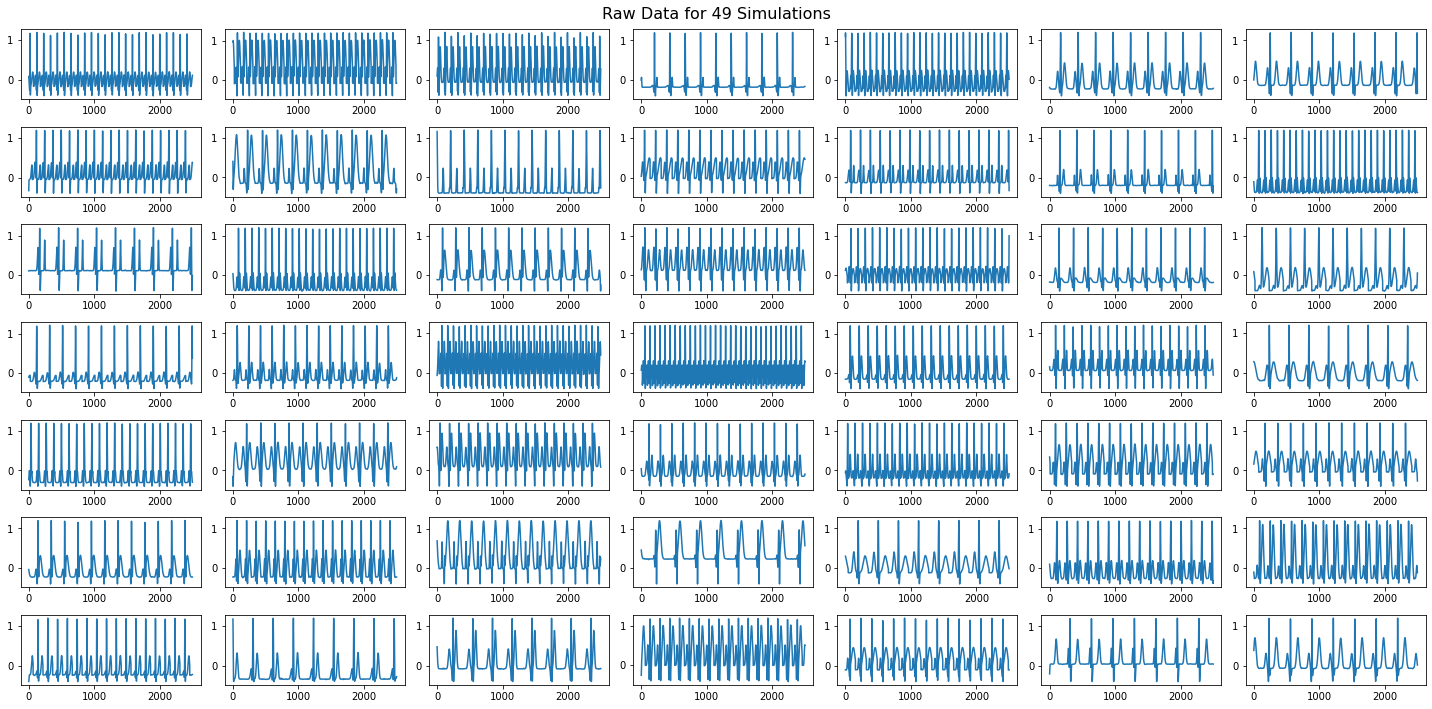

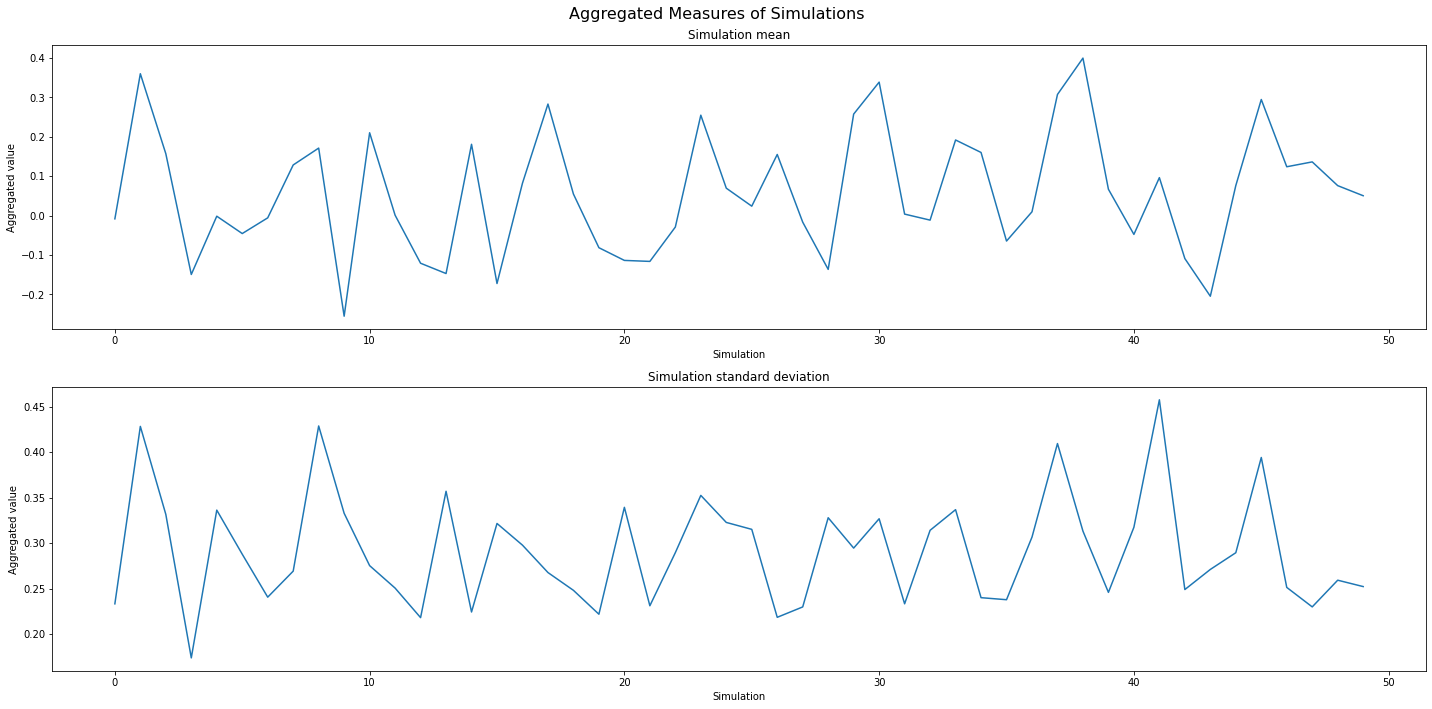

In [55]:
pushforward_dict = model_ecg.plot_pushforward(batch_size=50)

### 3. Setting up BayesFlow's Neural Architecture

The next step is to define a summary network. There are two primary considerations here:
1) What kind of architecture can capture as many important features of the simulated data as possible?
2) How small should the resulting summarized representation of the simulated data be?

Where the first of these questions is concerned, domain knowledge can often come in handy: it makes sense to choose a neural architecture which has been used successfully in a related task on similar data.

For instance, below, a variant of the convolutional neural network (CNN) used by Wu et al. (2021) ( https://www.frontiersin.org/articles/10.3389/fncom.2020.564015/full ) to classify ECG signals into classes corresponding to diagnoses is implemented.

Regarding the second question, in the absence of domain knowledge pointing to a specific number of latent parameters, four times the number of parameters is a sensible starting point; this is what was adopted below, i.e. n_summary = $4\cdot16 = 64$.

In [56]:
class LSTM_ecg(tf.keras.Model):
    def __init__(self, n_summary, sampling_frequency):
        super(LSTM_ecg, self).__init__()

        self.lstm = tf.keras.Sequential([
            tf.keras.layers.LSTM(n_summary*8, return_sequences=True),
            #tf.keras.layers.LSTM(n_summary*4, return_sequences=True),
            tf.keras.layers.LSTM(n_summary*2, return_sequences=True),
            tf.keras.layers.LSTM(n_summary)])

    def call(self, x, **args):
        """x is a 3D tensor of shape (batch_size, n_time_steps, n_time_series)"""

        out = self.lstm(x)
        return out

class CNN_ecg(tf.keras.Model):
    def __init__(self, n_summary, sampling_frequency):
        super(CNN_ecg, self).__init__()
        
        self.conv =  tf.keras.Sequential([
            tf.keras.layers.Conv1D(sampling_frequency, kernel_size=int(sampling_frequency/28), strides=1, 
                                   padding='causal', activation='relu'),
            tf.keras.layers.AveragePooling1D(pool_size=3, strides=2),
            tf.keras.layers.Conv1D(int(sampling_frequency/2-1), kernel_size=int(sampling_frequency/28+2), strides=1, 
                                   padding='causal', activation='relu'),
            tf.keras.layers.AveragePooling1D(pool_size=3, strides=2),
            tf.keras.layers.Conv1D(int(sampling_frequency/4-1), kernel_size=int(sampling_frequency/28+4), strides=1, 
                                   padding='causal', activation='relu'),
            tf.keras.layers.AveragePooling1D(pool_size=3, strides=2),
            tf.keras.layers.Conv1D(int(sampling_frequency/8-1), kernel_size=int(sampling_frequency/28+6), strides=1, 
                                   padding='causal', activation='relu'),
            tf.keras.layers.AveragePooling1D(pool_size=3, strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(n_summary) 
        ])
#        self.full = tf.keras.layers.Dense(n_summary)
#        self.lstm = tf.keras.layers.LSTM(n_summary)
#         self.conv = tf.keras.layers.Conv1D(n_summary, kernel_size=sampling_frequency, strides=1,
#                                    padding='causal', activation='relu', kernel_initializer='glorot_uniform')
#         self.lstm = tf.keras.Sequential([
#             tf.keras.layers.LSTM(n_summary, return_sequences=True),
#             tf.keras.layers.LSTM(n_summary, return_sequences=True),
#             tf.keras.layers.LSTM(n_summary)])

    def call(self, x, **args):
        """x is a 3D tensor of shape (batch_size, n_time_steps, n_time_series)"""

        out = self.conv(x)
        #out = self.full(out)
        #out = self.lstm(x)
        return out

In [57]:
# class NN_ecg(tf.keras.Model):
#     def __init__(self, n_summary, sampling_frequency):
#         super(NN_ecg, self).__init__()
        
#         self.conv =  tf.keras.Sequential([
#             tf.keras.layers.Conv1D(sampling_frequency, kernel_size=int(sampling_frequency/28), strides=1, 
#                                    padding='causal', activation='relu'),
#             tf.keras.layers.AveragePooling1D(pool_size=3, strides=2),
#             tf.keras.layers.Conv1D(int(sampling_frequency/2-1), kernel_size=int(sampling_frequency/28+2), strides=1, 
#                                    padding='causal', activation='relu'),
#             tf.keras.layers.AveragePooling1D(pool_size=3, strides=2),
#             tf.keras.layers.Conv1D(int(sampling_frequency/4-1), kernel_size=int(sampling_frequency/28+4), strides=1, 
#                                    padding='causal', activation='relu'),
#             tf.keras.layers.AveragePooling1D(pool_size=3, strides=2),
#             tf.keras.layers.Conv1D(int(sampling_frequency/8-1), kernel_size=int(sampling_frequency/28+6), strides=1, 
#                                    padding='causal', activation='relu'),
#             tf.keras.layers.AveragePooling1D(pool_size=3, strides=2),
#             tf.keras.layers.Flatten(),
#             tf.keras.layers.Dense(n_summary) 
#         ])
# #        self.full = tf.keras.layers.Dense(n_summary)
# #        self.lstm = tf.keras.layers.LSTM(n_summary)
# #         self.conv = tf.keras.layers.Conv1D(n_summary, kernel_size=sampling_frequency, strides=1,
# #                                    padding='causal', activation='relu', kernel_initializer='glorot_uniform')
# #         self.lstm = tf.keras.Sequential([
# #             tf.keras.layers.LSTM(n_summary, return_sequences=True),
# #             tf.keras.layers.LSTM(n_summary, return_sequences=True),
# #             tf.keras.layers.LSTM(n_summary)])

#     def call(self, x, **args):
#         """x is a 3D tensor of shape (batch_size, n_time_steps, n_time_series)"""

#         out = self.conv(x)
#         #out = self.full(out)
#         #out = self.lstm(x)
#         return out

In [58]:
class summary_predictor(tf.keras.Model):
    def __init__(self, n_summary, sampling_frequency, n_params):
        super(summary_predictor, self).__init__()
        
        self.conv =  tf.keras.Sequential([
            tf.keras.layers.Conv1D(sampling_frequency, kernel_size=int(sampling_frequency/28), strides=1, 
                                   padding='causal', activation='relu'),
            tf.keras.layers.AveragePooling1D(pool_size=3, strides=2),
            tf.keras.layers.Conv1D(int(sampling_frequency/2-1), kernel_size=int(sampling_frequency/28+2), strides=1, 
                                   padding='causal', activation='relu'),
            tf.keras.layers.AveragePooling1D(pool_size=3, strides=2),
            tf.keras.layers.Conv1D(int(sampling_frequency/4-1), kernel_size=int(sampling_frequency/28+4), strides=1, 
                                   padding='causal', activation='relu'),
            tf.keras.layers.AveragePooling1D(pool_size=3, strides=2),
            tf.keras.layers.Conv1D(int(sampling_frequency/8-1), kernel_size=int(sampling_frequency/28+6), strides=1, 
                                   padding='causal', activation='relu'),
            tf.keras.layers.AveragePooling1D(pool_size=3, strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(n_summary),
            tf.keras.layers.Dense(n_params)
        ])
#        self.full = tf.keras.layers.Dense(n_summary)
#        self.lstm = tf.keras.layers.LSTM(n_summary)
#         self.conv = tf.keras.layers.Conv1D(n_summary, kernel_size=sampling_frequency, strides=1,
#                                    padding='causal', activation='relu', kernel_initializer='glorot_uniform')
#         self.lstm = tf.keras.Sequential([
#             tf.keras.layers.LSTM(n_summary, return_sequences=True),
#             tf.keras.layers.LSTM(n_summary, return_sequences=True),
#             tf.keras.layers.LSTM(n_summary)])

    def call(self, x, **args):
        """x is a 3D tensor of shape (batch_size, n_time_steps, n_time_series)"""

        out = self.conv(x)
        #out = self.full(out)
        #out = self.lstm(x)
        return out

def _default_loader(self, file_path):
    with open(file_path, 'rb+') as f:
            loaded_file = pickle_load(f)
    return(loaded_file)
    
def adapt_learning_rate(epoch):
    if epoch < 10:
        return(0.001)
    elif epoch >= 10 and epoch < 20:
        return(0.0001)
    else:
        return(0.00001)

def save_model(folder_path, model_name, max_to_keep=3):
    saved_so_far = os.listdir(folder_path)
    if len(saved_so_far) == 3:
        oldest = 999
        for flname in saved_so_far:
            model_no = re.search(r'_([0-9]*)', flname).group(1)
            if int(model_no)  < oldest:
                file_to_delete = flname
                print(file_to_delete)
    
def summary_as_prediction(summary_network, presimulation_path, checkpoint_location, custom_loader=_default_loader):
    my_lr_scheduler = keras.callbacks.LearningRateScheduler(adapt_learning_rate)
    loss_history = []
    file_list = os.listdir(presimulation_path)
    for ep, current_filename in enumerate(file_list, start=1):

        # Read single file into memory as a dictionary or list
        file_path = presimulation_path + '/' + current_filename
        epoch_data = custom_loader(file_path)

        # For each epoch, the number of iterations is inferred from the presimulated dictionary or list used for that epoch
        if isinstance(epoch_data, dict): 
            index_list = list(epoch_data.keys())
        elif isinstance(epoch_data, list):
            index_list = np.arange(len(epoch_data))    
        else:
            raise ValueError(f"Loading a simulation file resulted in a {type(epoch_data)}. Must be a dictionary or a list.")

        with tqdm(total=len(index_list), desc=f'Training epoch {ep}') as p_bar:
            for it, index in enumerate(index_list, start=1):

                # Perform one training step and obtain current loss value
                input_dict = configurator_ecg(epoch_data[index])

                # Like the number of iterations, the batch size is inferred from presimulated dictionary or list
                #batch_size = len(input_dict[DEFAULT_KEYS['parameters']][0])

                batch_loss = summary_network.train_on_batch(input_dict['summary_conditions'], input_dict['parameters'])
                #loss = self._train_step(batch_size, input_dict, **kwargs)

                # Store returned loss
                loss_history += [batch_loss]

                # Format for display on progress bar
                #disp_str = format_loss_string(ep, it, loss, avg_dict, slope)

                # Update progress bar
                #p_bar.set_postfix_str(disp_str)
                p_bar.update(1)

                # Check optional stopping and end training
#                     if self._check_optional_stopping():
#                         self._save_trainer(save_checkpoint)
#                         return self.loss_history.get_plottable()

        # Store after each epoch, if specified
        summary_network.save(save_checkpoint)

    

In [59]:
#loss=tf.keras.losses.MeanSquaredError()

We specify the parameters of our summary network to match the desired latent summary dimensions (n_summary = 64) and, in our specific case, the ECG sampling frequency (sf_ecg = 250). 

The invertible neural network (INN) we will be combining with this summary network can be generated by BayesFlow with as little as two inputs - a number of parameters n_params and a number of desired coupling layers n_coupling_layers. This, too, is done below. 

In [60]:
coupling_settings = {
    't_args': {
        'dense_args': dict(units=coupling_block_size, kernel_initializer='glorot_uniform', activation='elu'),
        'n_dense': 2,
        'spec_norm': spectral_normalization
    },
    's_args': {
        'dense_args': dict(units=coupling_block_size, kernel_initializer='glorot_uniform', activation='elu'),
        'n_dense': 2,
        'spec_norm': spectral_normalization
    }
}

if summary_net_type == 'LSTM':
    NN_ecg = LSTM_ecg
    print("LSTM selected.")
else:
    NN_ecg = CNN_ecg
    print("CNN selected")

summary_net_ecg = NN_ecg(n_summary=n_summary, sampling_frequency=params_sim['sf_ecg'])
inference_net_ecg = InvertibleNetwork({
    'n_params': n_params, 
    'n_coupling_layers': depth_INN,
    'coupling_settings': coupling_settings
})

CNN selected


2022-11-02 10:42:23.758862: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-02 10:42:23.762974: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-02 10:42:25.753851: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-02 10:42:25.753882: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rene-LENOVO-Y520-15IKBN): /proc/driver/nvidia/version does not exist
2022-11-02 10:42:25.755516: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate com

It may make sense to test the summary network on its own to ensure that, if nothing else, the various layers are compatible with one another. If they are, the following cell will produce an output; otherwise, it will raise an error.

In [61]:
# The data must go through a configurator in order to be compatible with the summary network
# A more detailed explanation is given below
def simulator_configurator(simdata):
    simdata = np.expand_dims(simdata, axis=2)
    flt32data = simdata.astype(np.float32)
    return(flt32data)

mini_prior = generate_ecg_parameter_prior_batch(10, params_model=params_model, params_sim=params_sim, \
                                        model_params_to_vary = model_params_to_vary, \
                                        sim_params_to_vary= sim_params_to_vary)

mini_batch = simulate_batch(mini_prior, params_model, params_sim, param_list = param_list, baseline_wander=False)

mini_conf_batch = simulator_configurator(mini_batch)
summary_net_ecg(mini_conf_batch)

<tf.Tensor: shape=(10, 64), dtype=float32, numpy=
array([[ 7.54111912e-03, -1.44303087e-02, -9.42529459e-03,
         1.03596197e-02, -1.05368067e-02, -1.35674691e-02,
         3.21411267e-02, -1.43788243e-03,  1.21591147e-05,
        -1.50994221e-02,  9.54185799e-03,  5.77762490e-03,
         8.41738749e-03, -6.98629953e-03, -8.21780041e-03,
         1.80866066e-02, -6.96229469e-03,  2.66898051e-02,
         7.09945895e-03,  8.10039416e-03,  2.31067352e-02,
         9.17643216e-03,  4.71854769e-03,  7.70308310e-03,
         9.04494524e-03,  4.71251365e-03,  2.80075870e-03,
        -1.74462814e-02, -7.22648995e-03, -1.30451843e-02,
        -1.36433681e-02, -3.89818382e-03, -1.03607792e-02,
        -2.67672446e-02,  4.29361686e-03, -2.32739933e-02,
        -2.28885990e-02, -8.53670295e-04,  1.31003205e-02,
         1.43601885e-03,  1.06692016e-02,  1.11595308e-02,
         1.02799851e-04, -1.19943554e-02,  6.38167188e-03,
         1.13539547e-02, -1.06983092e-02,  1.72932167e-04,
      

Next, we combine our summary network and INN into a single amortizer network using BayesFlow's AmortizedPosterior class:

In [62]:
amortizer_ecg = AmortizedPosterior(inference_net_ecg, summary_net_ecg, name='ecg_amortizer')

The final bit of preparation before training is to configure prior draws and simulation data for training.

Up to three steps are typically required:
1) Reshaping the simulation data. CNNs require inputs of the shape (batch size, signal length, number of channels), i.e. (batch size, signal length, 1) in our case.
2) Casting to single-precision float. If a GPU is available, it will speed up training immensely, and GPUs typically have much more processing power for single-precision float numbers (float32).
3) Normalizing. Both passing through and updating a neural network repeatedly involves matrix-vector multiplication, and entries of vastly different size make this operation notoriously ill-conditioned. For the simulation data, this can lead to vanishing or exploding gradients during training, and for the parameters, it can cause much greater uncertainty in the predicted posterior distributions.

The first two steps are carried out below largely as-is.

Normalization is a little less obvious. Since our model already includes a normalizing step for the simulated data (constraining the simulated ECG signal to the range between -0.4 and +1.2 Hz), we do not need to add another one here. We do, however, need to normalize our priors so that they jointly have mean 0 and variance 1. To do so, we must first compute their unnormalized means and stds:

In [63]:
prior_means, prior_stds = prior_ecg.estimate_means_and_stds()

In [64]:
def configurator_ecg(forward_dict):
    # Prepare placeholder dict
    out_dict = {}
    
    # Reshape data to (batch size, signal length, 1) and cast data to float32
    # GPUs are optimized for float32 computations, and convolutional NN require
    # the number of channels as a third dimension - this is 1 for the ECG signal
    simdata = forward_dict['sim_data']
    simdata = np.expand_dims(simdata, axis=2)
    flt32data = simdata.astype(np.float32)
    
    # Cast parameters to float32
    ### (Extract prior draws and z-standardize with previously computed means)
    params = forward_dict['prior_draws'].astype(np.float32)
    params = (params - prior_means) / prior_stds
    
    # Add to keys
    out_dict['summary_conditions'] = flt32data#[idx_keep]
    out_dict['parameters'] = params#[idx_keep]
    
    return out_dict  

### 4. Training and Evaluation

With our AmortizedPosterior, GenerativeModel and Configurator, we are now ready to create a trainer instance. Doing so before starting the actual training results in a small test run to ensure that all components are consistent with one another:

In [65]:
trainer_ecg = Trainer(amortizer=amortizer_ecg, generative_model=model_ecg, configurator=configurator_ecg,
                     checkpoint_path = checkpoint_path)

INFO:root:Loaded loss history from checkpoints_Oct31_2/history_11.pkl
INFO:root:Loaded simulation memory from checkpoints_Oct31_2/memory_11.pkl
INFO:root:Networks loaded from checkpoints_Oct31_2/ckpt-11
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Instantiating the Trainer above caused the BayesFlow model to actually be built. We are now in a position to look at some statistics about our architecture:

In [66]:
amortizer_ecg.summary()

Model: "ecg_amortizer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
invertible_network (Invertib multiple                  305968    
_________________________________________________________________
cnn_ecg (CNN_ecg)            multiple                  726517    
Total params: 1,032,485
Trainable params: 1,028,117
Non-trainable params: 4,368
_________________________________________________________________


In [67]:
#trainer_ecg.train_online(epochs=40,batch_size=64,iterations_per_epoch=1000)

/home/rene/Bf_ecg/BayesFlow/bayesflow/diagnostics.py:434: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(n_row, 1, figsize=fig_size)


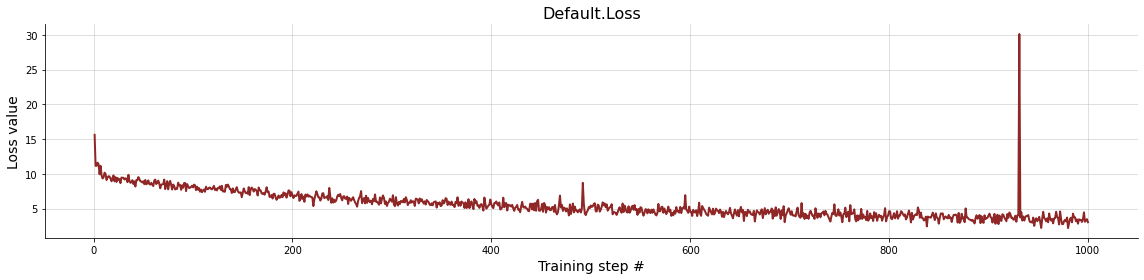

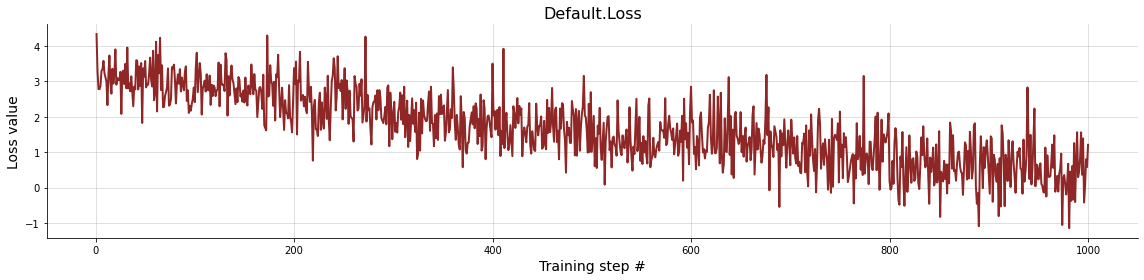

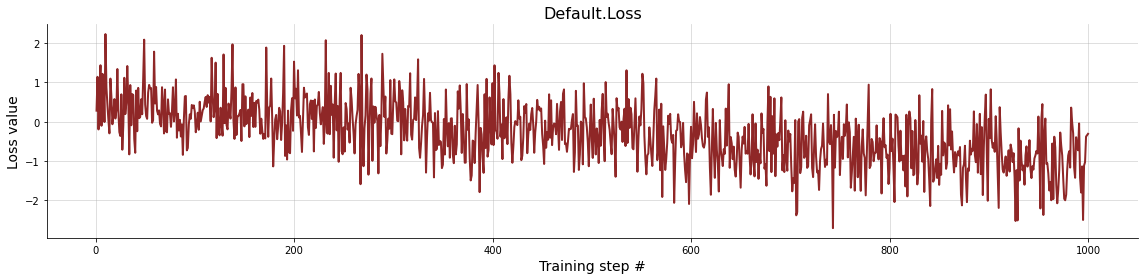

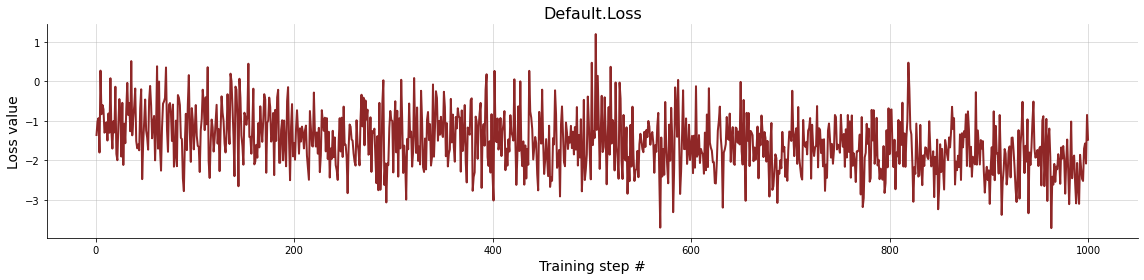

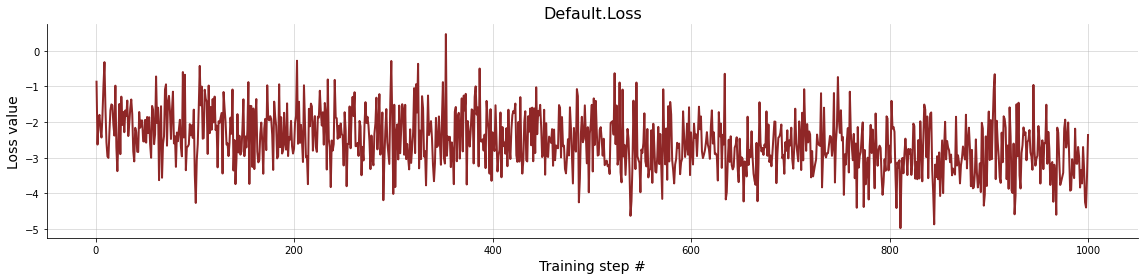

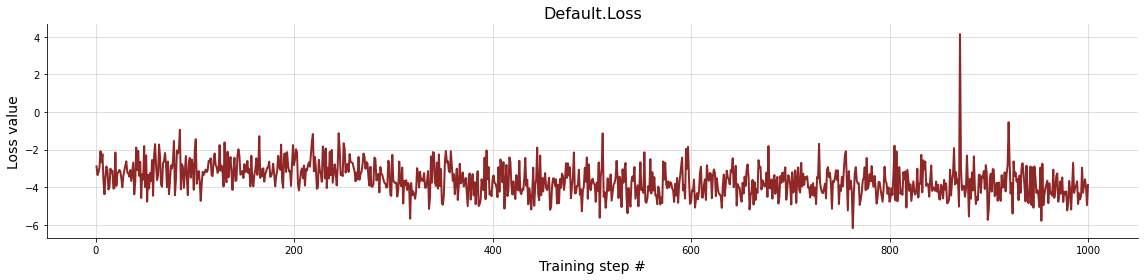

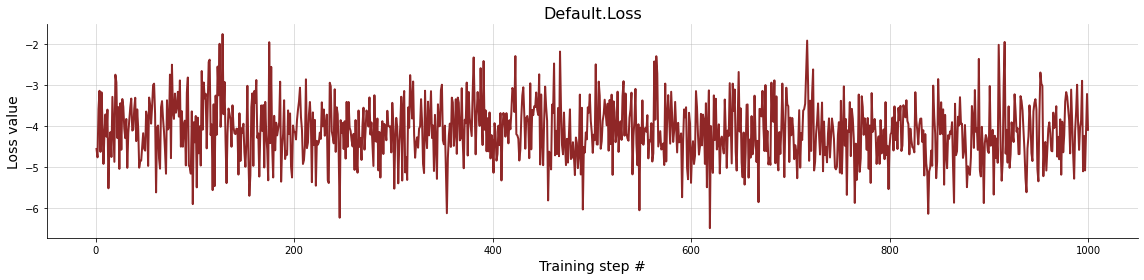

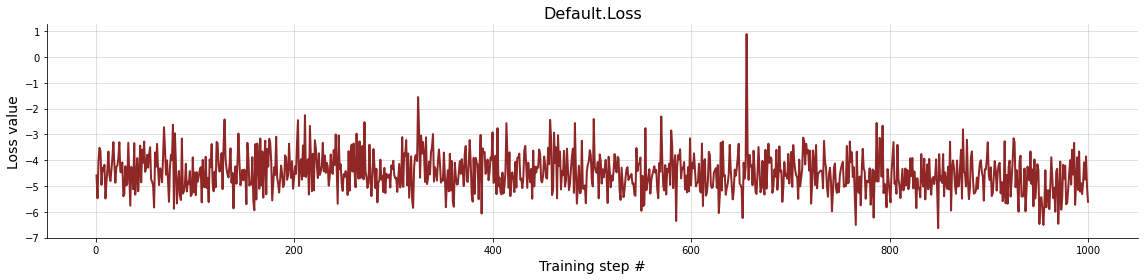

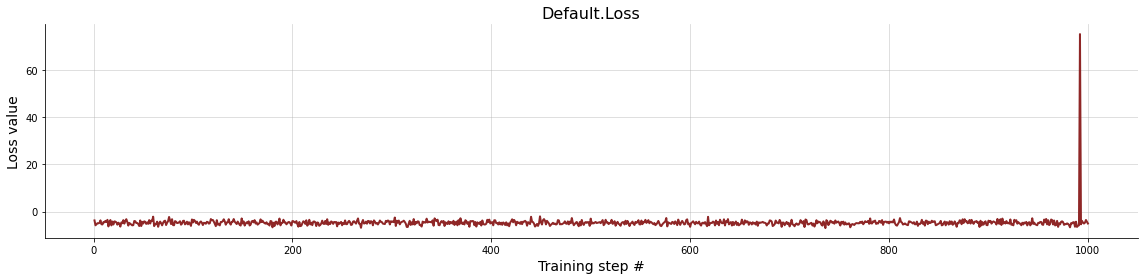

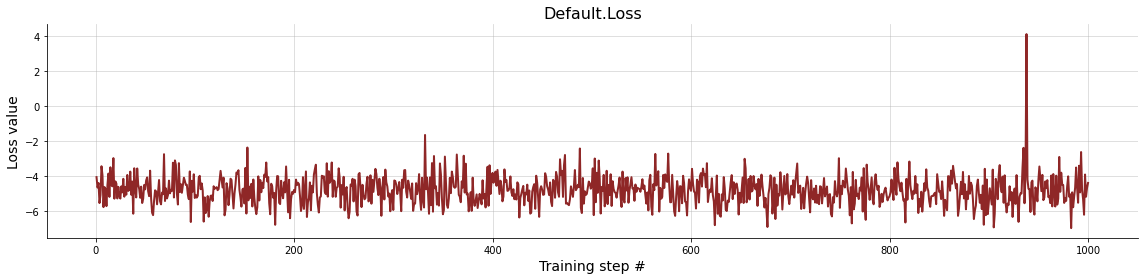

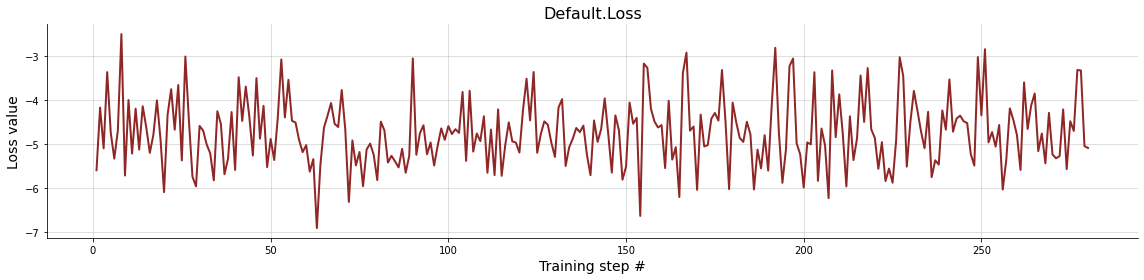

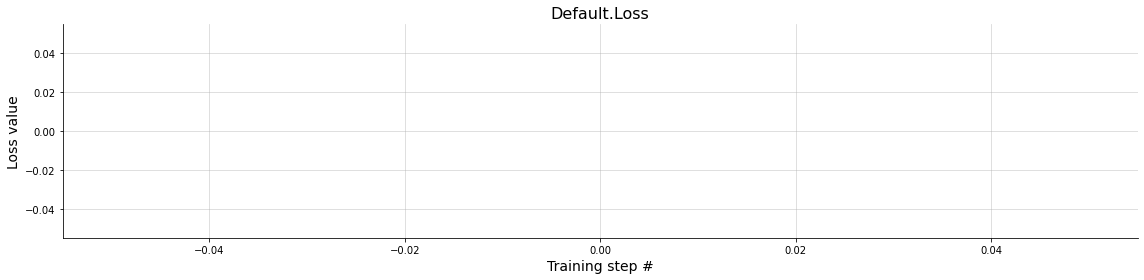

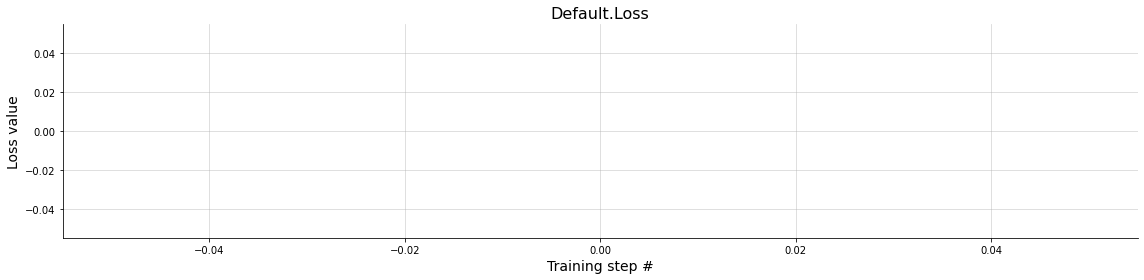

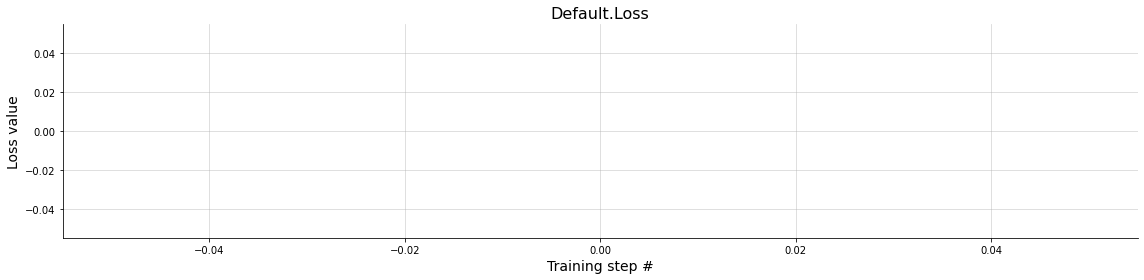

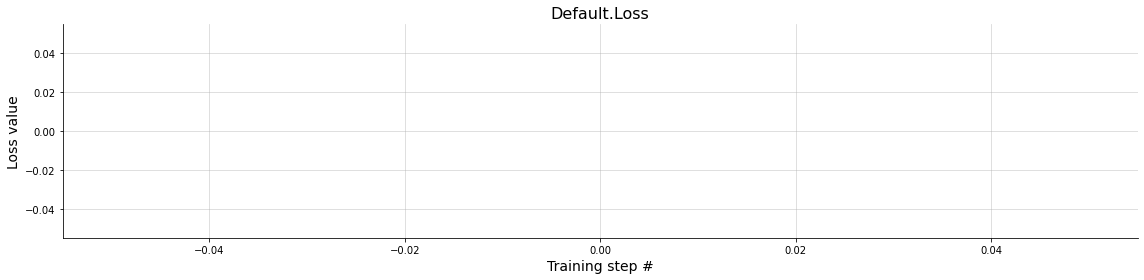

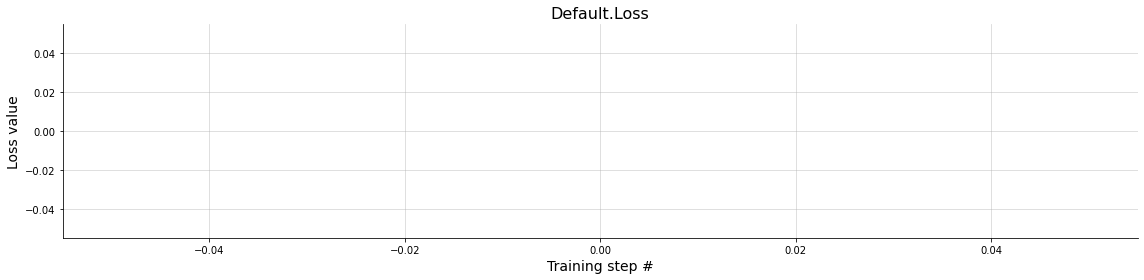

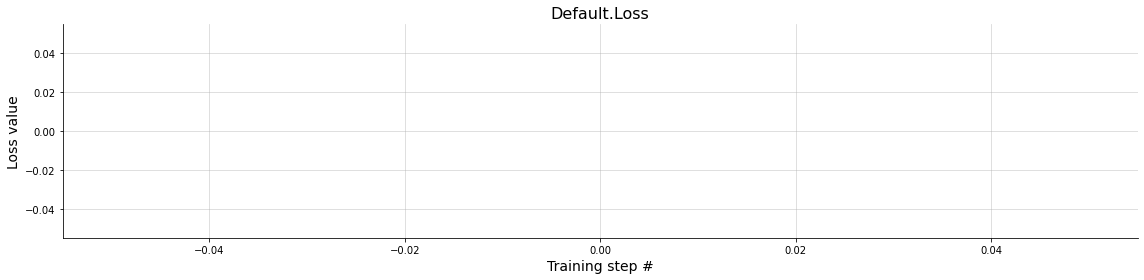

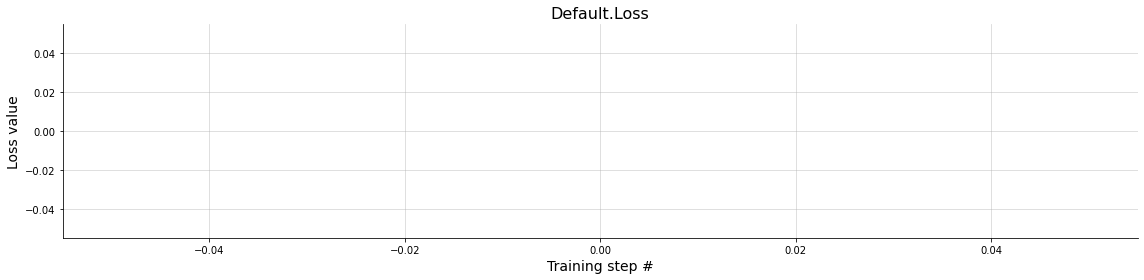

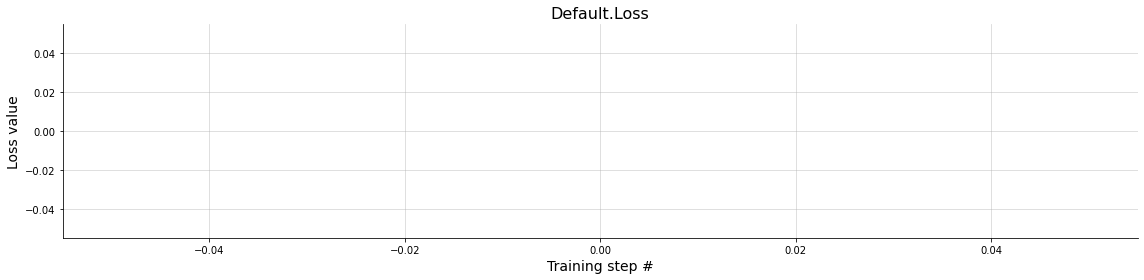

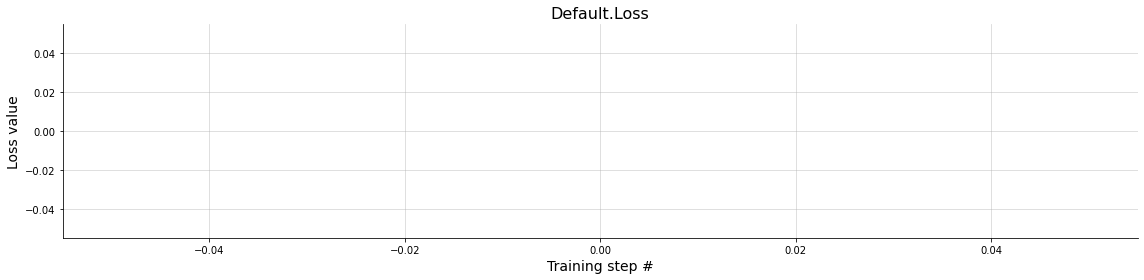

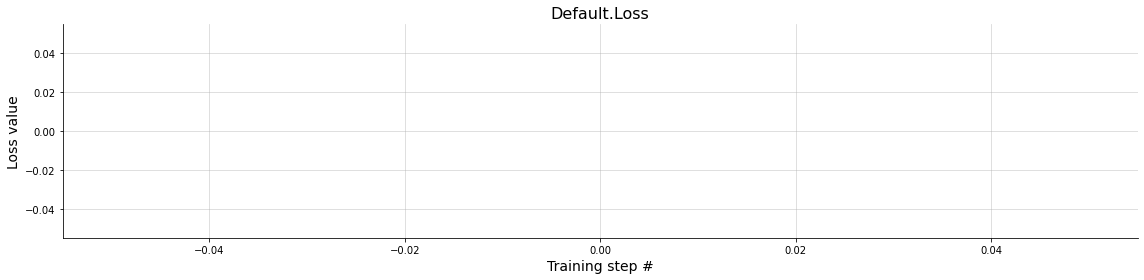

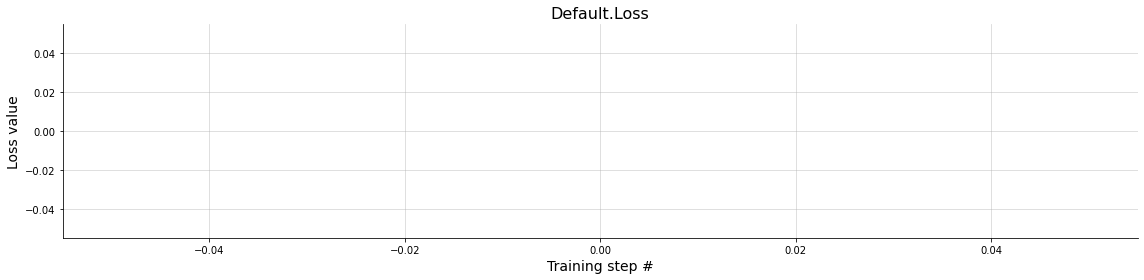

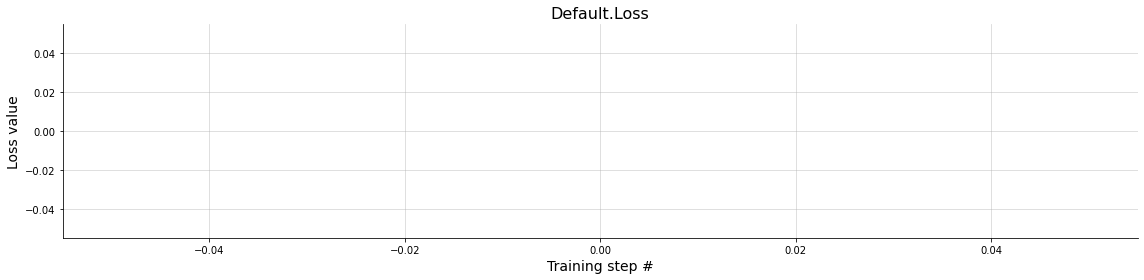

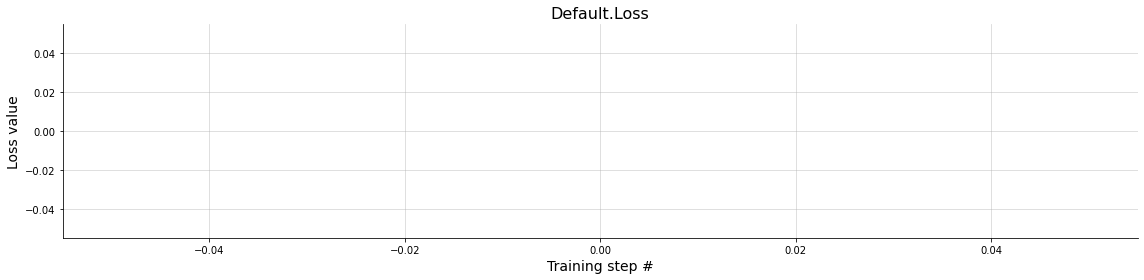

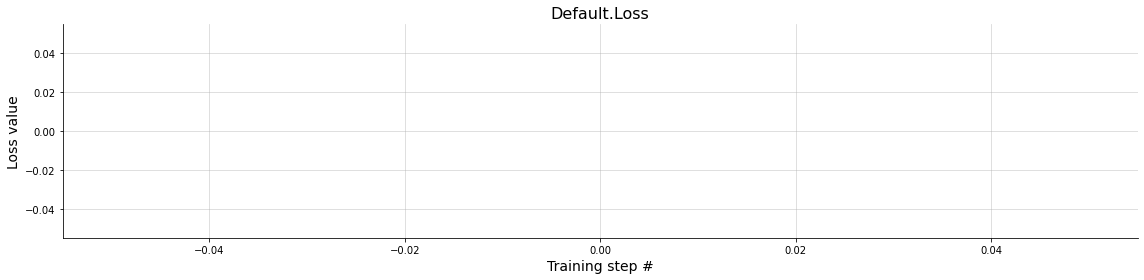

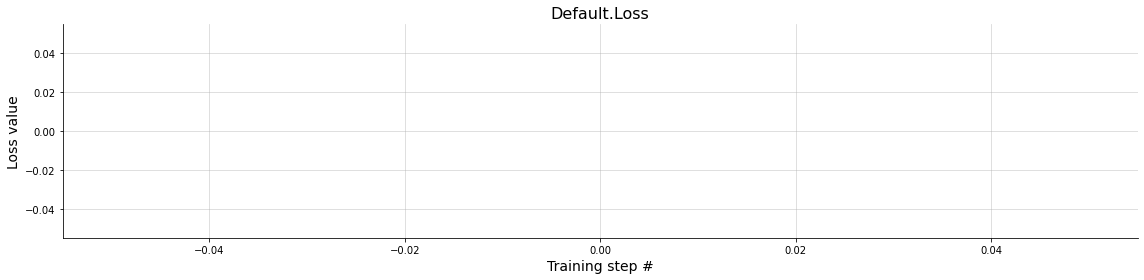

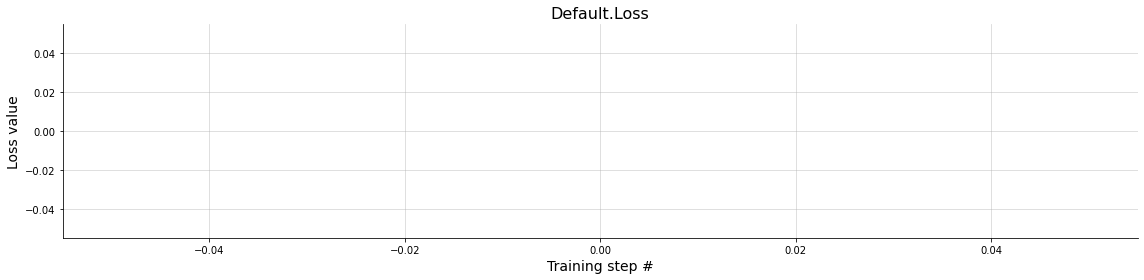

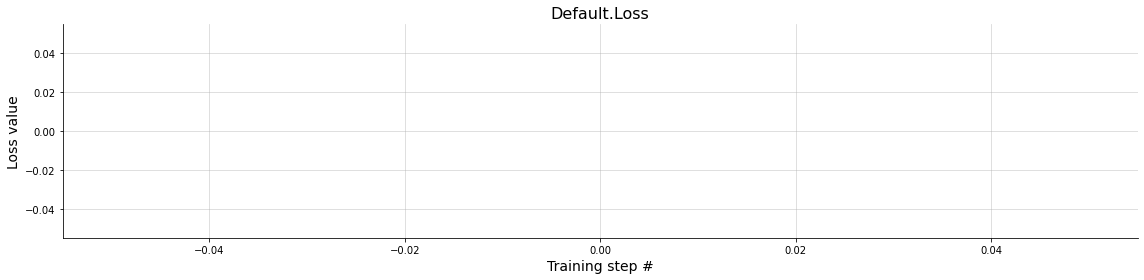

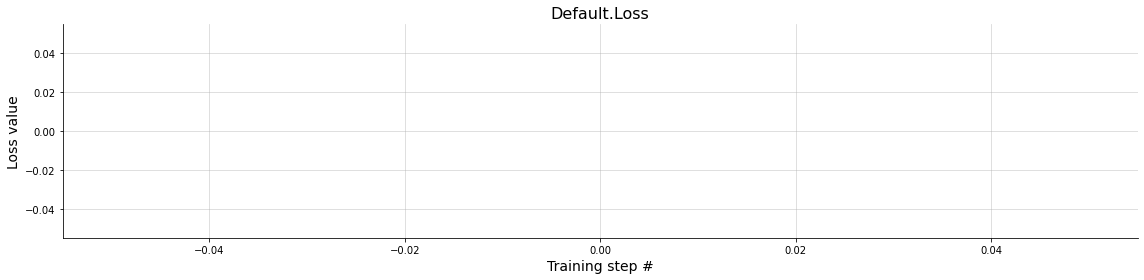

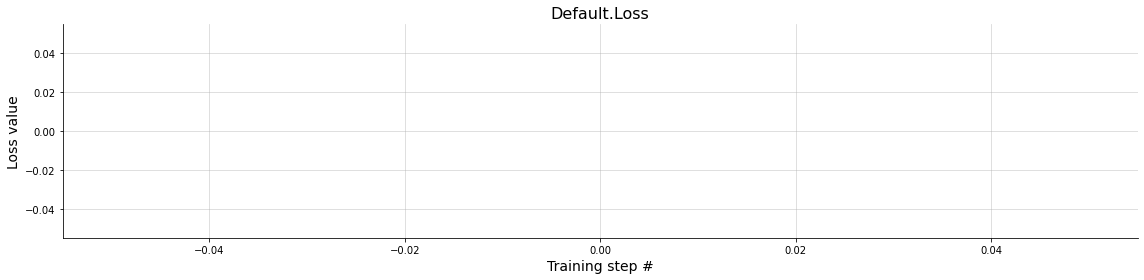

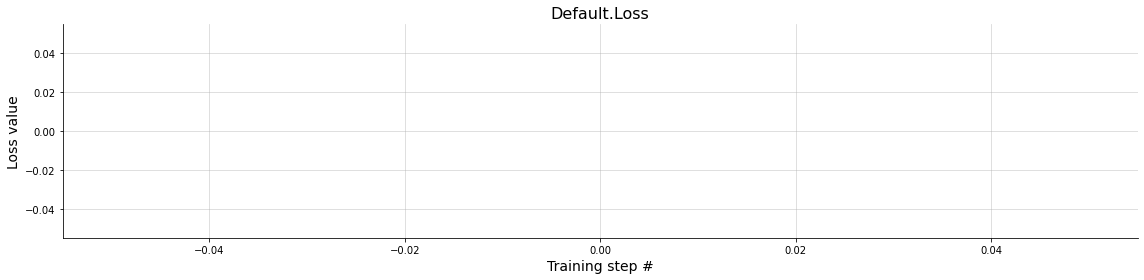

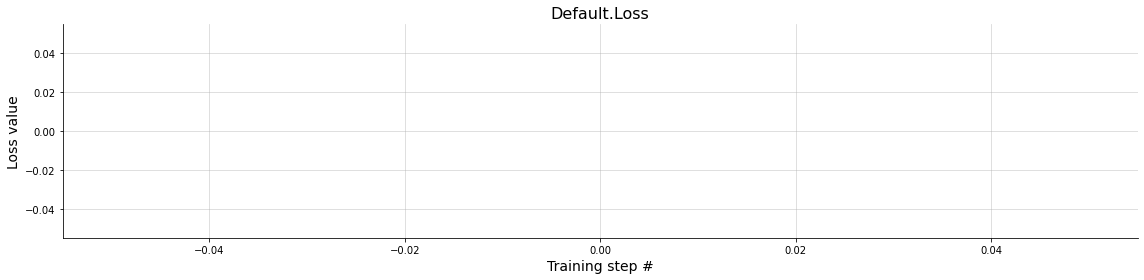

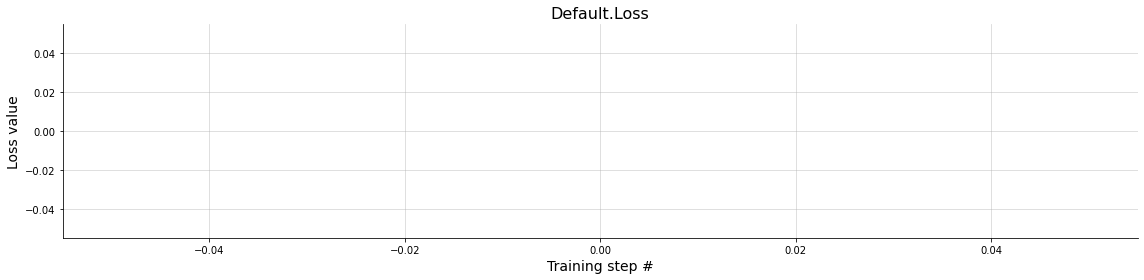

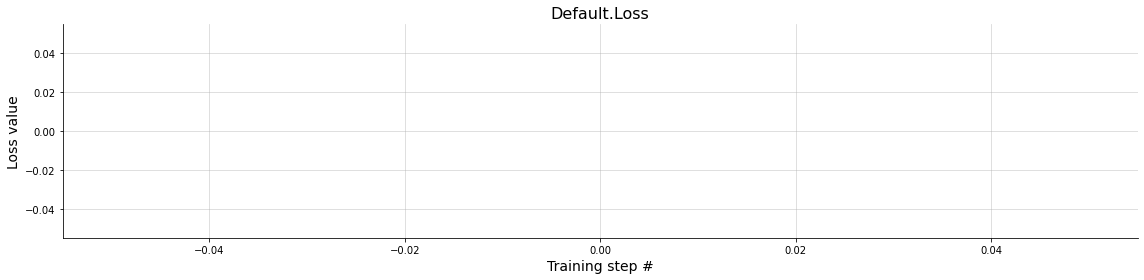

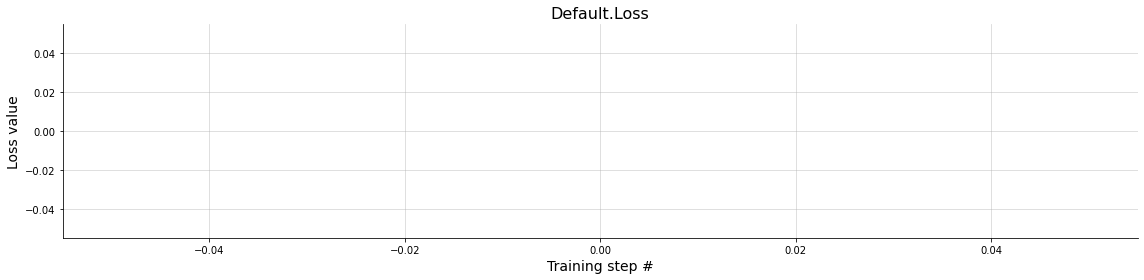

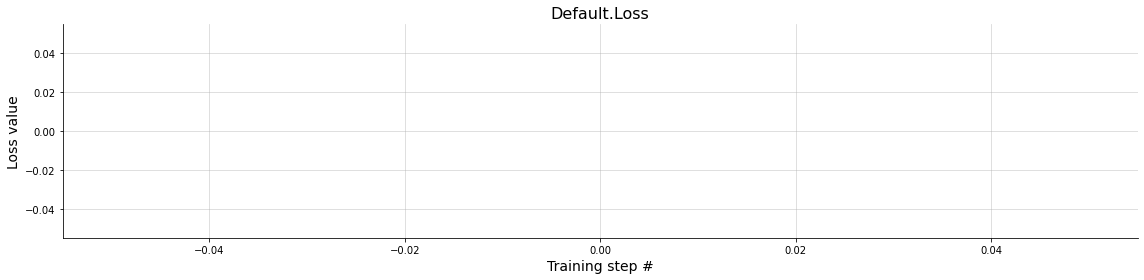

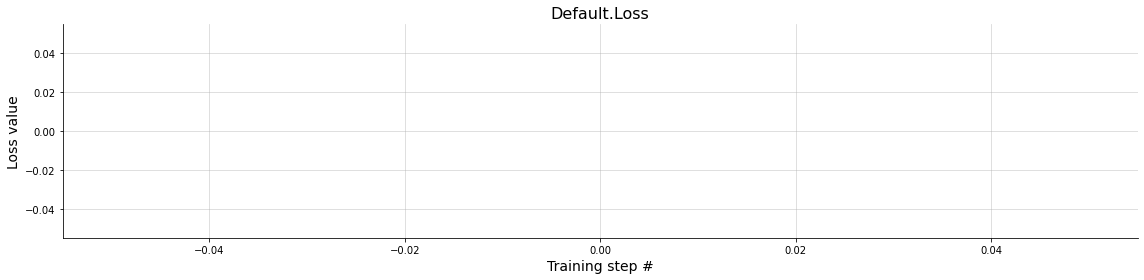

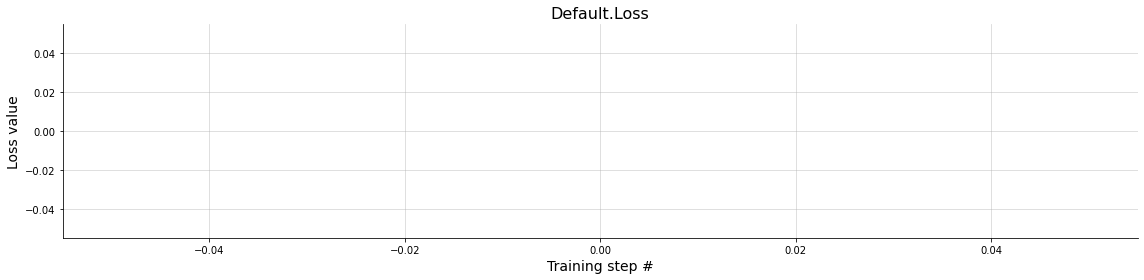

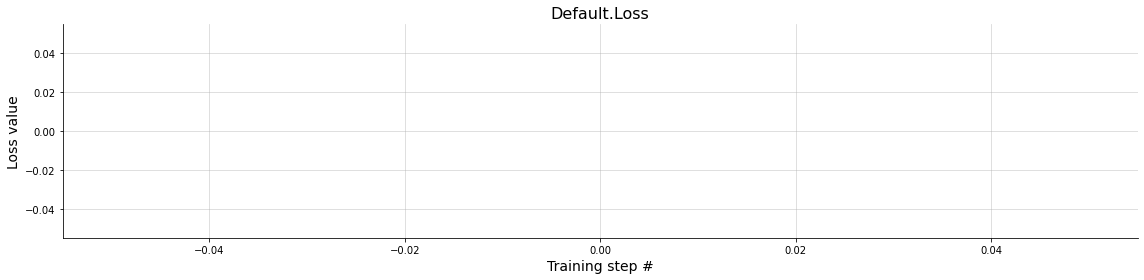

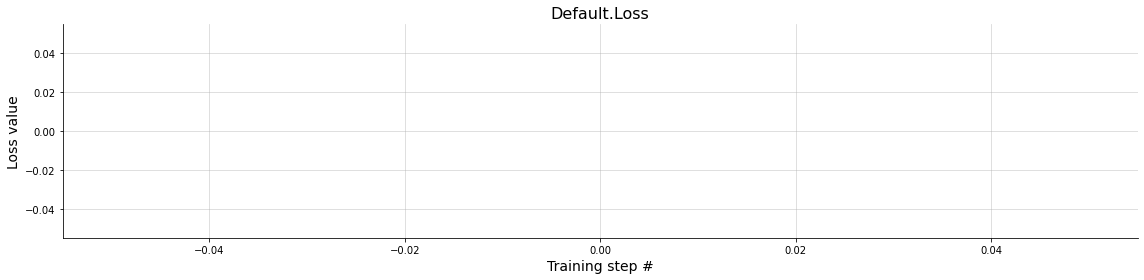

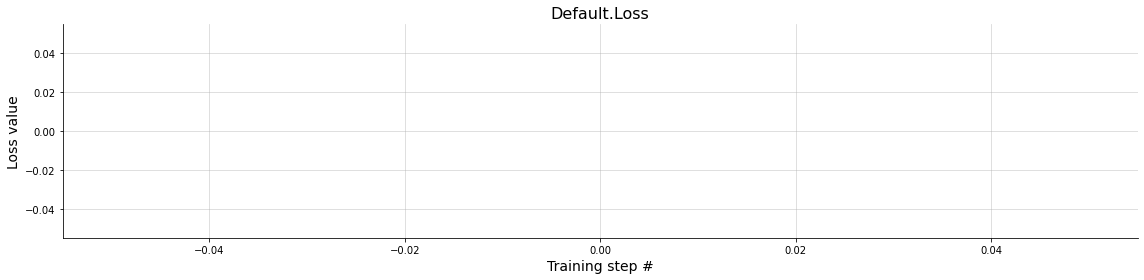

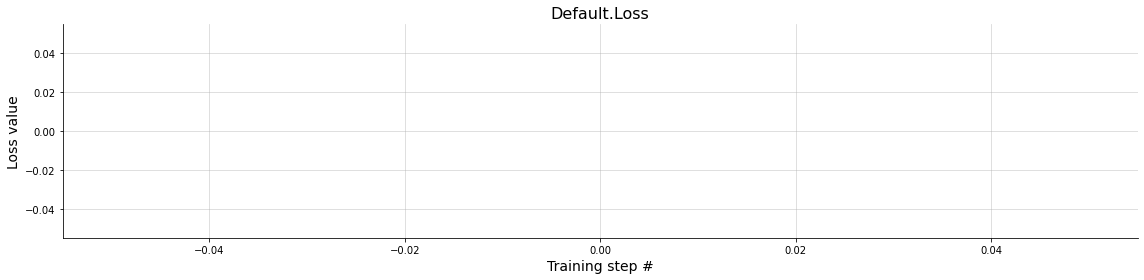

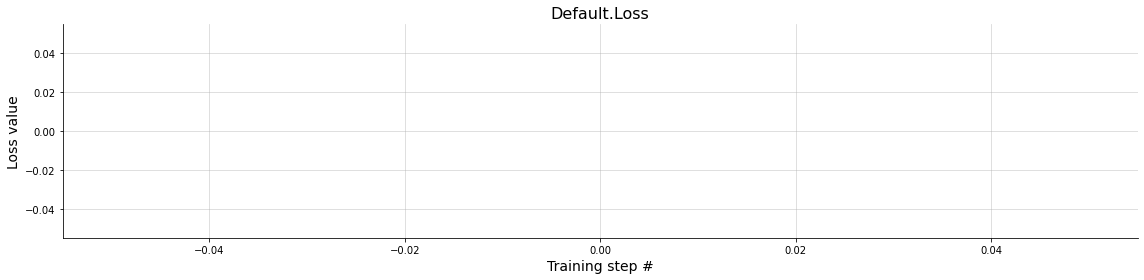

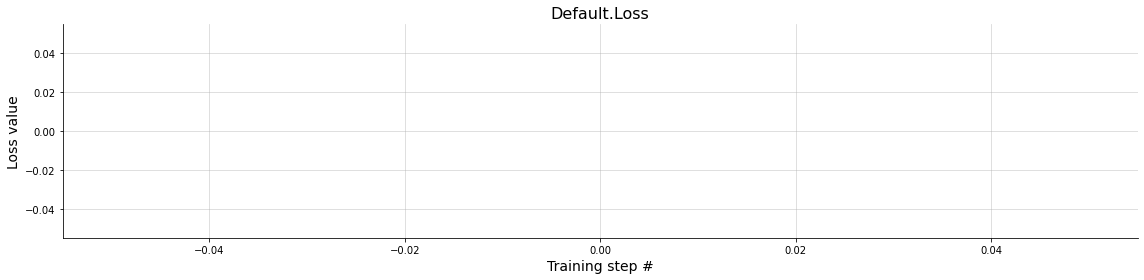

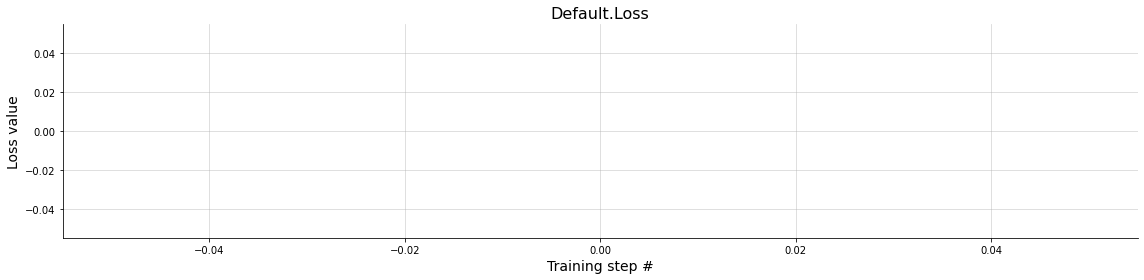

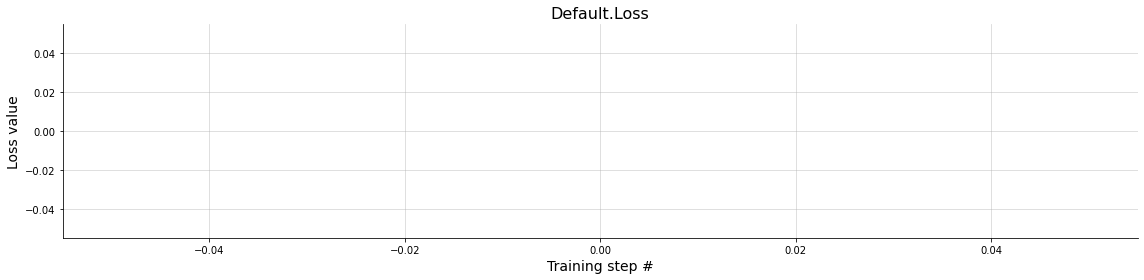

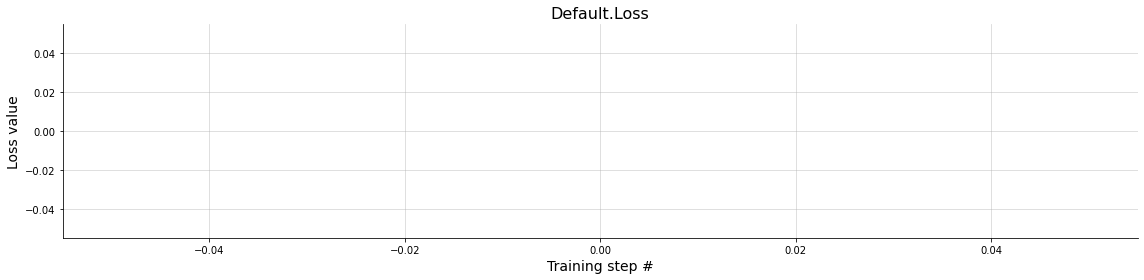

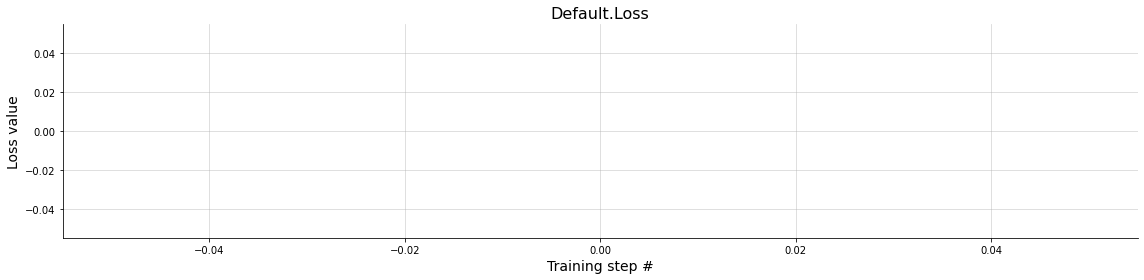

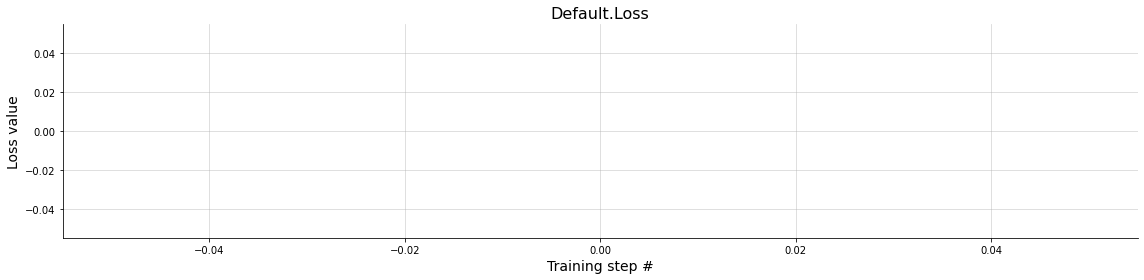

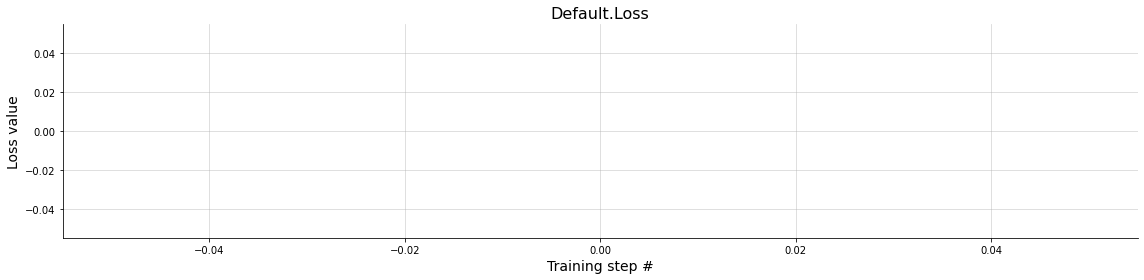

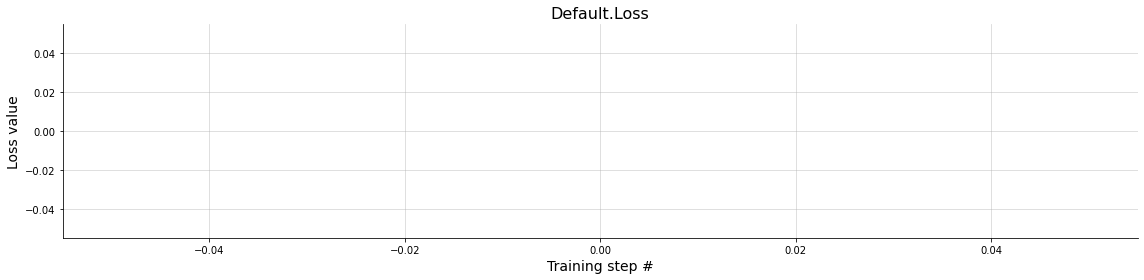

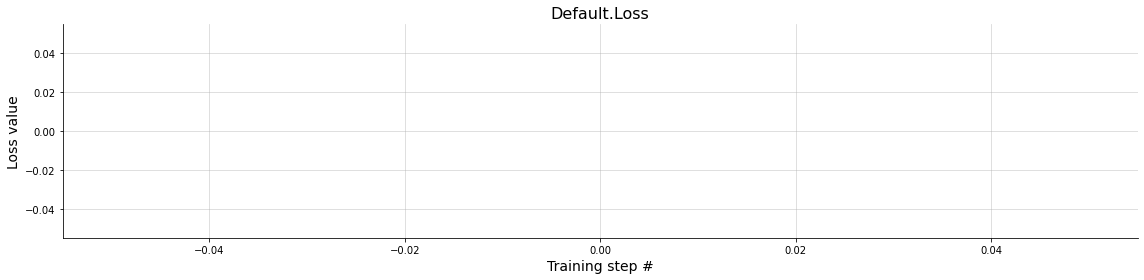

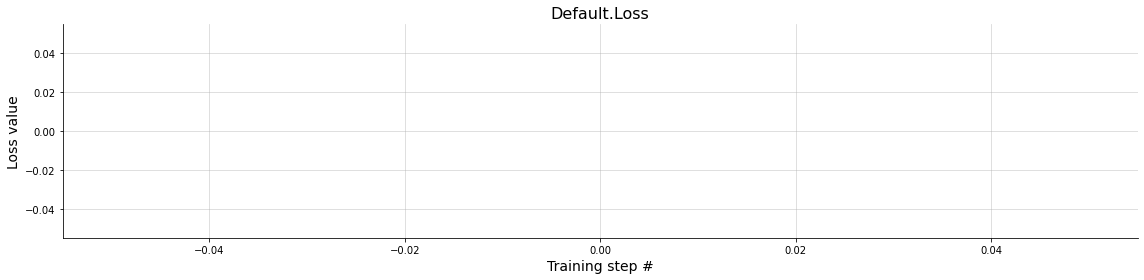

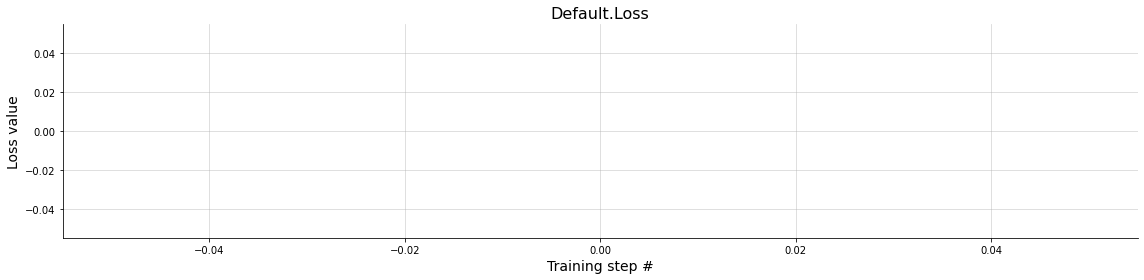

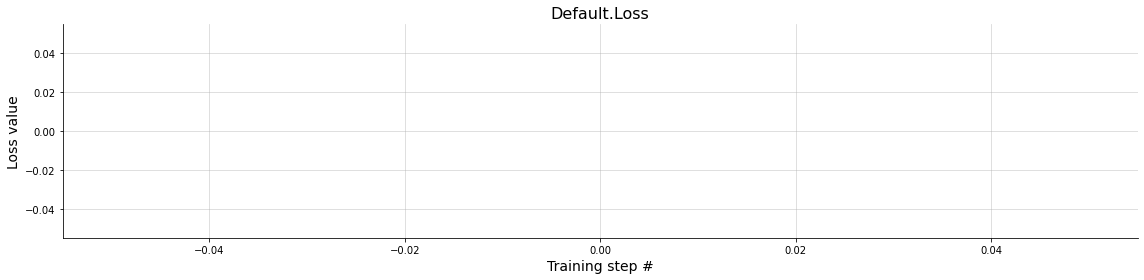

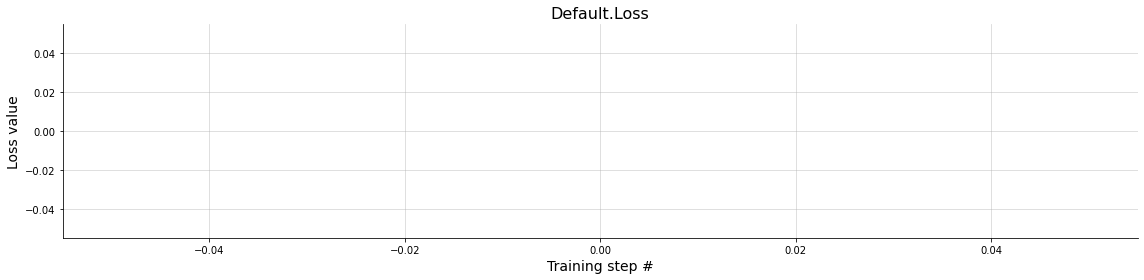

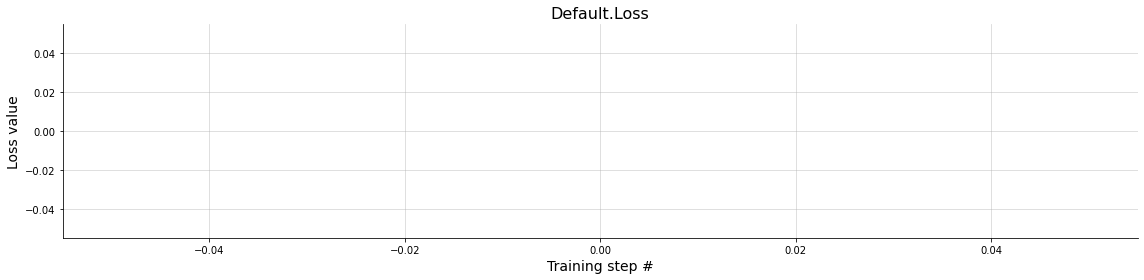

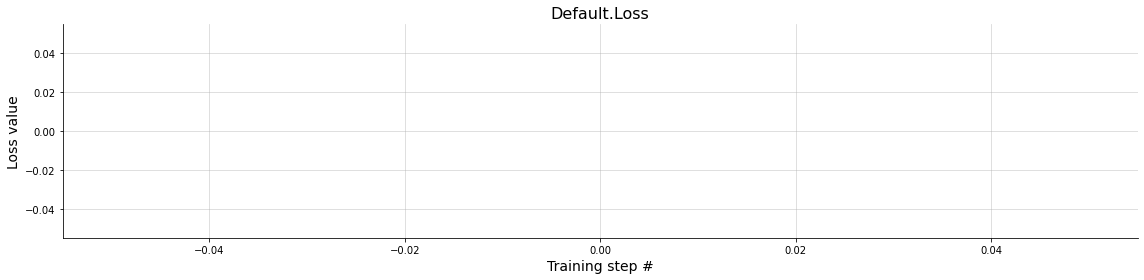

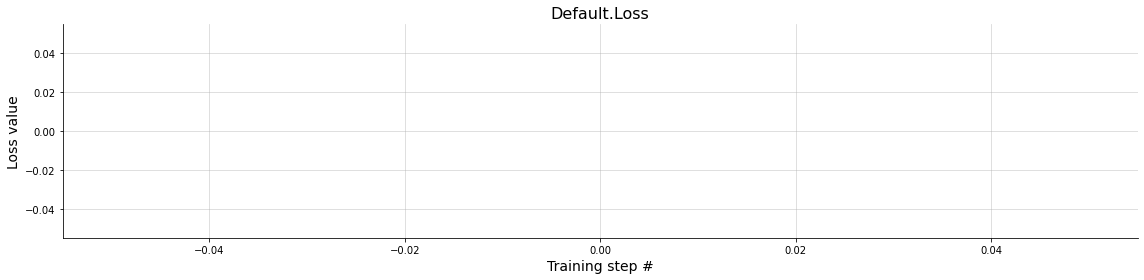

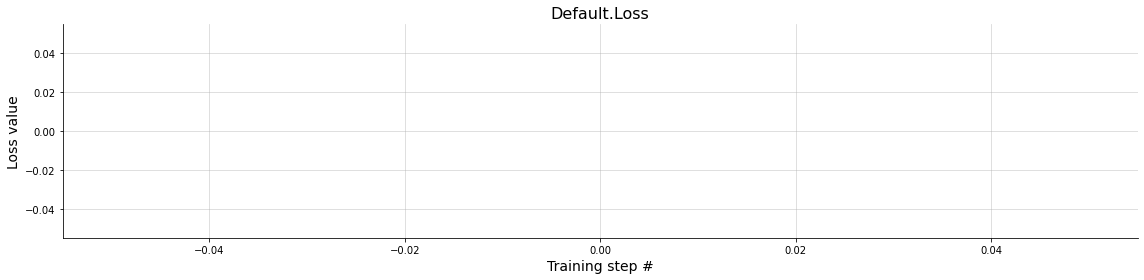

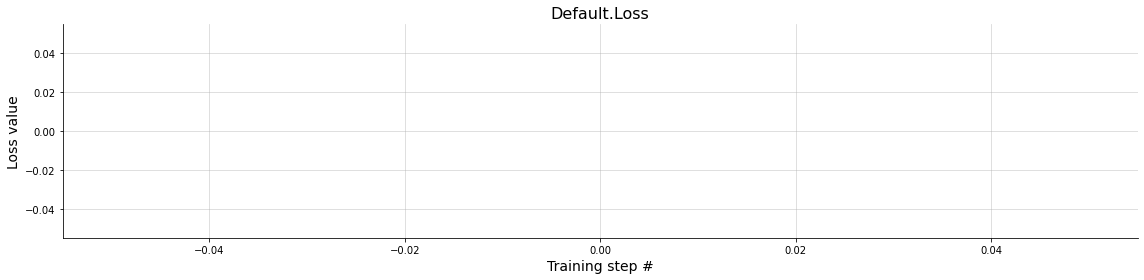

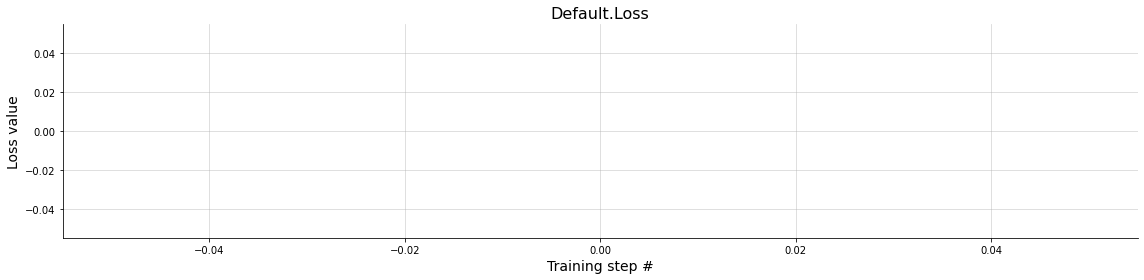

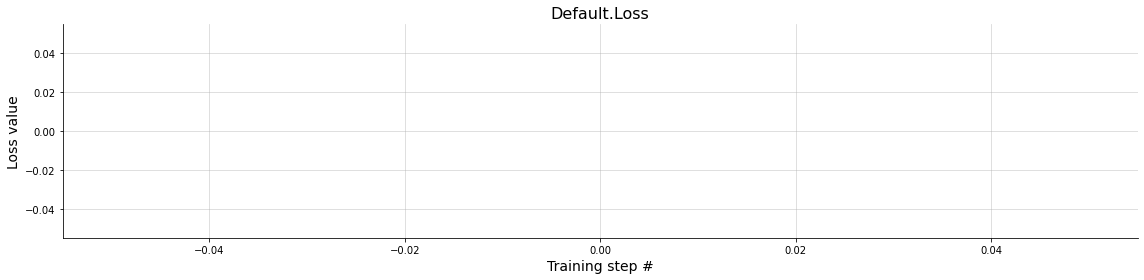

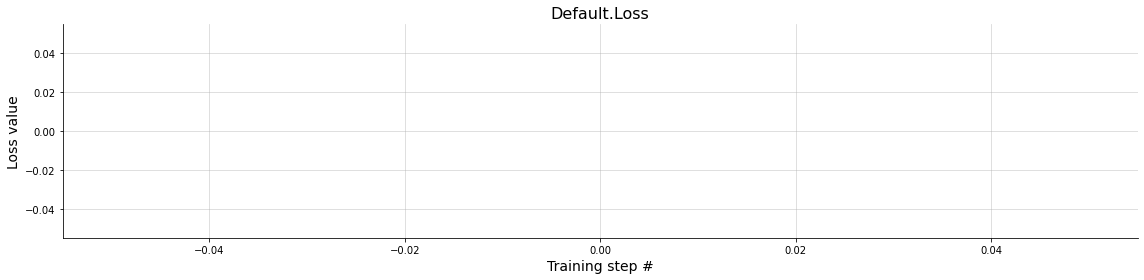

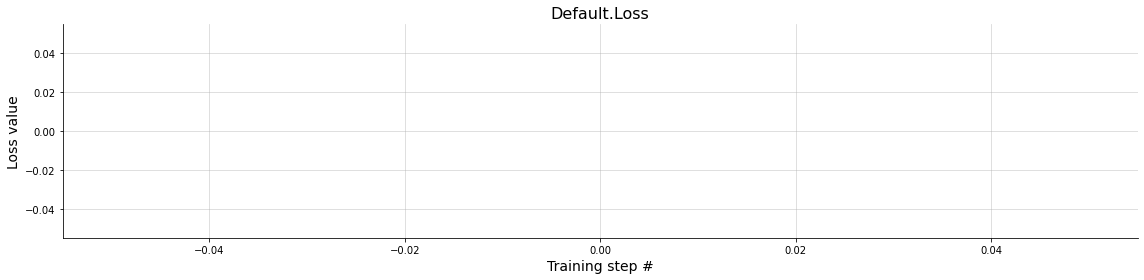

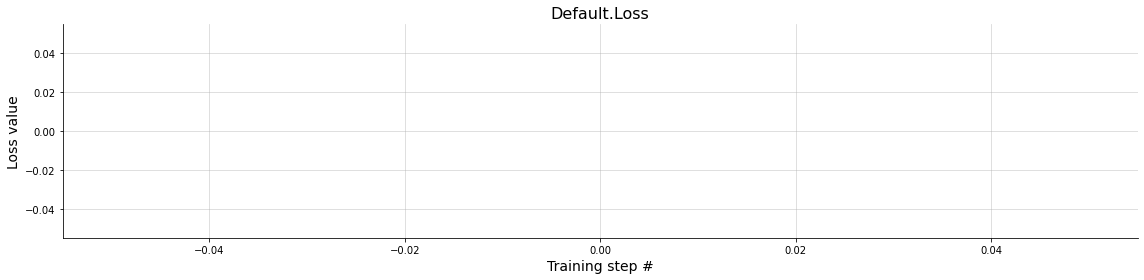

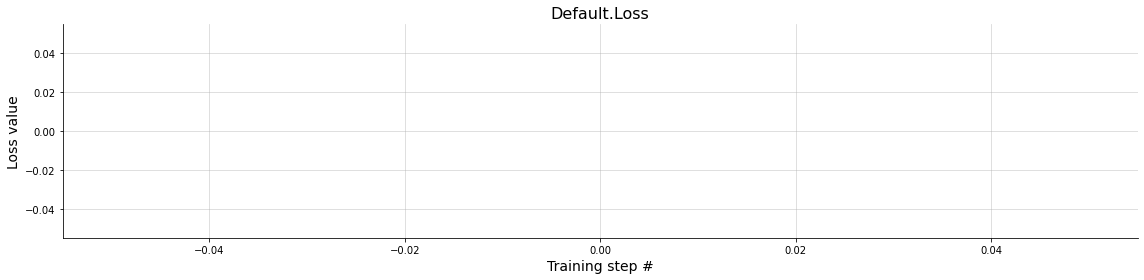

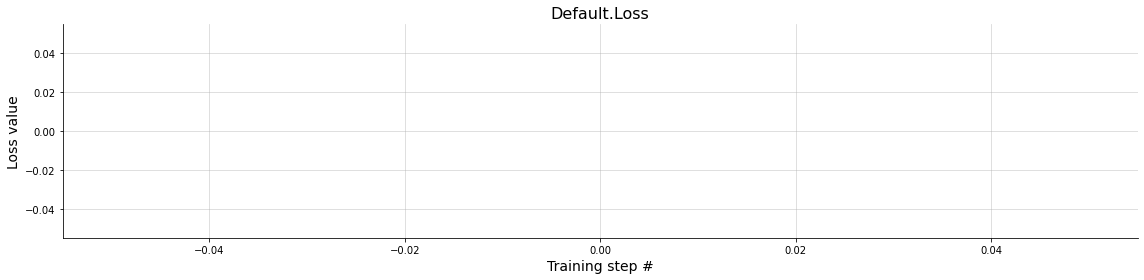

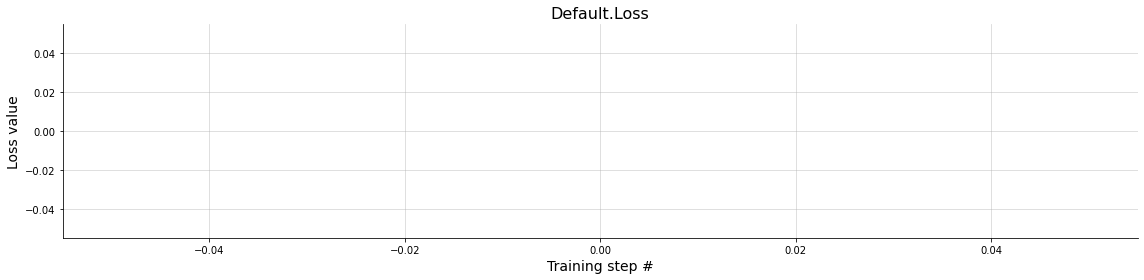

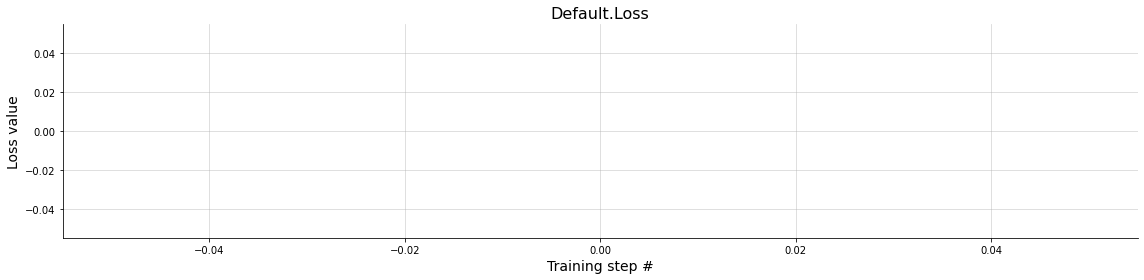

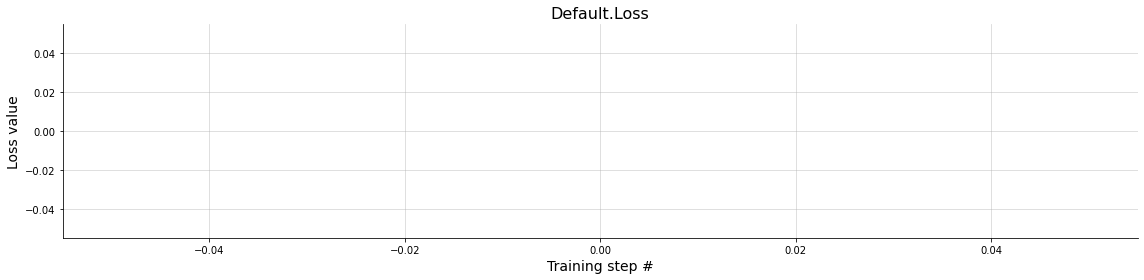

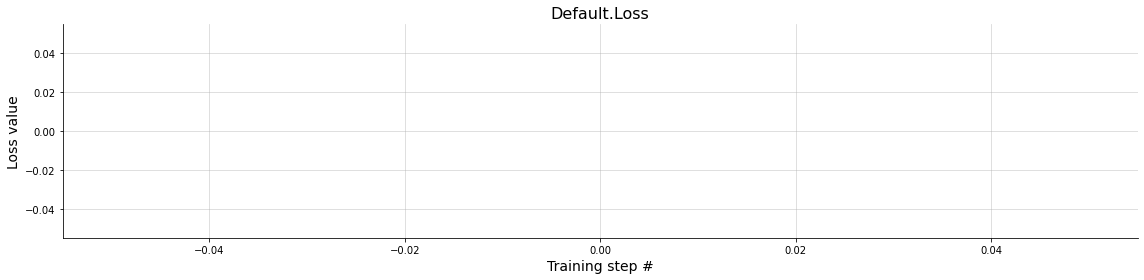

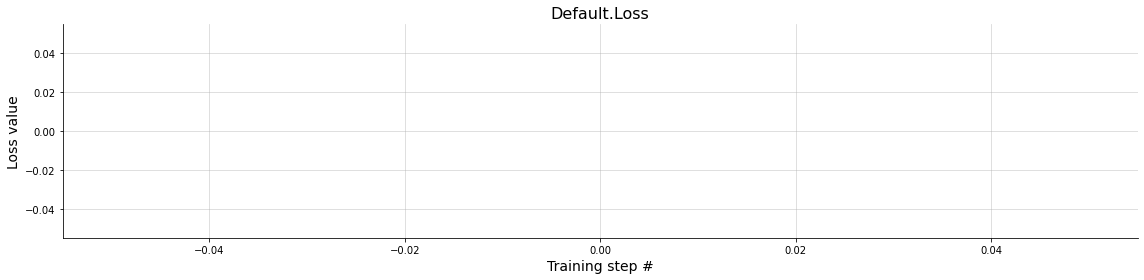

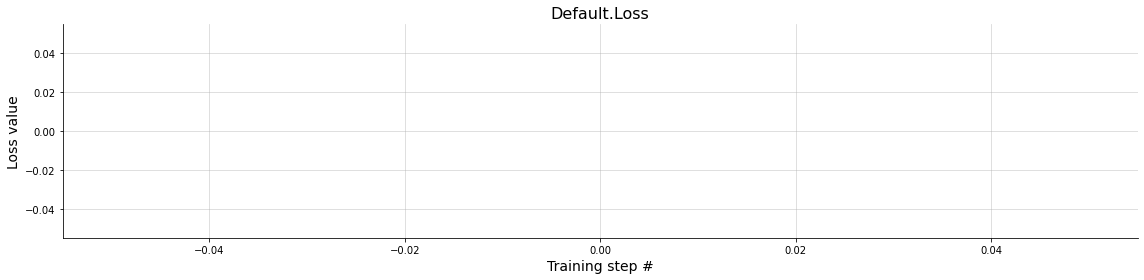

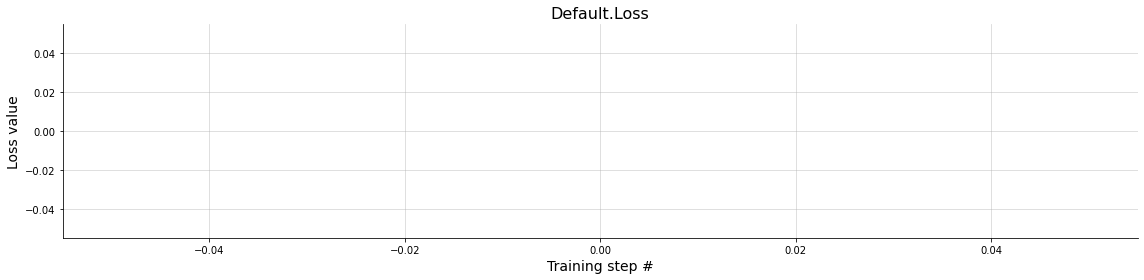

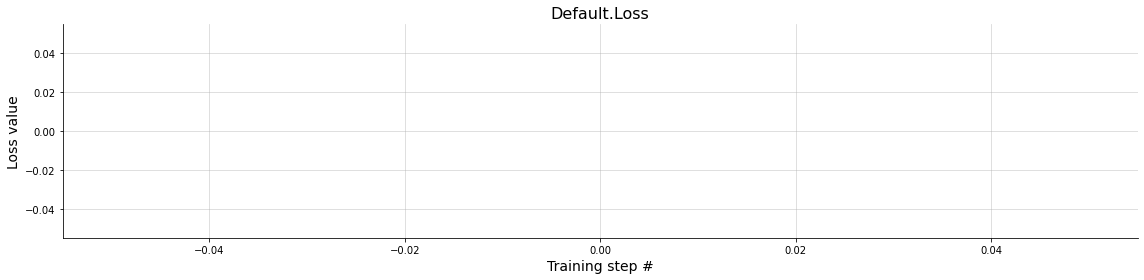

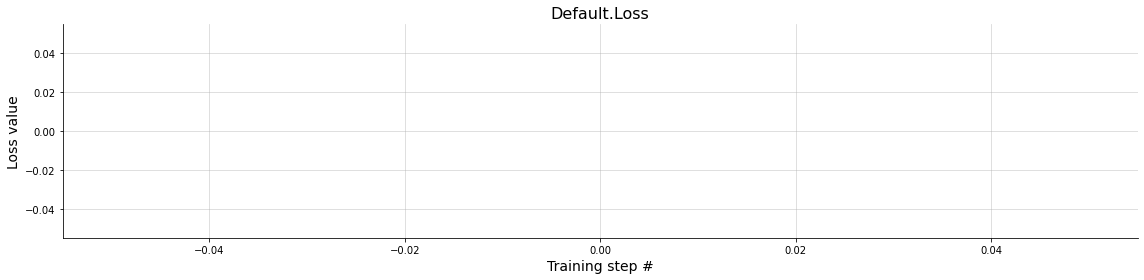

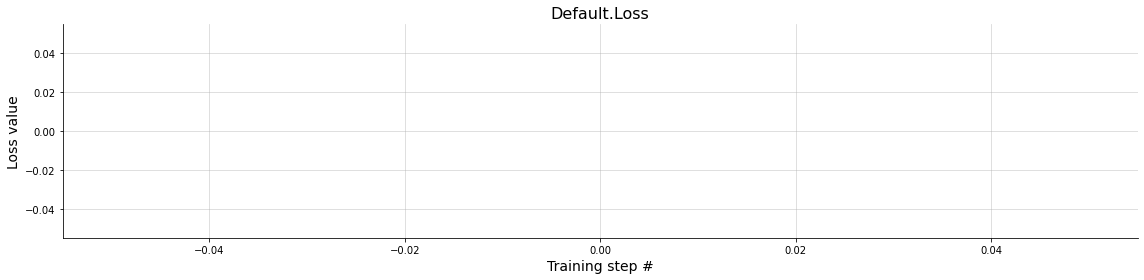

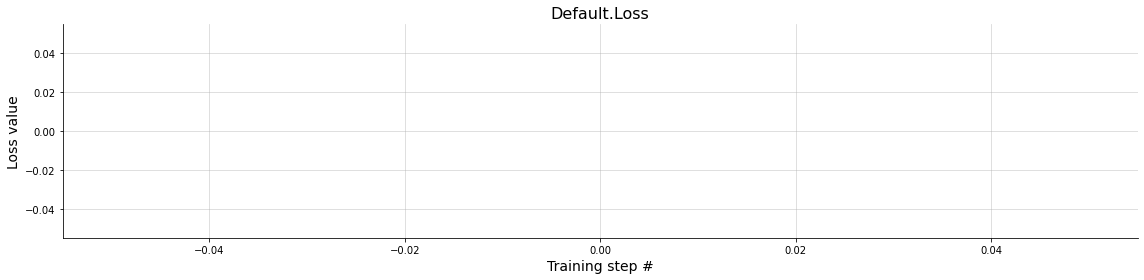

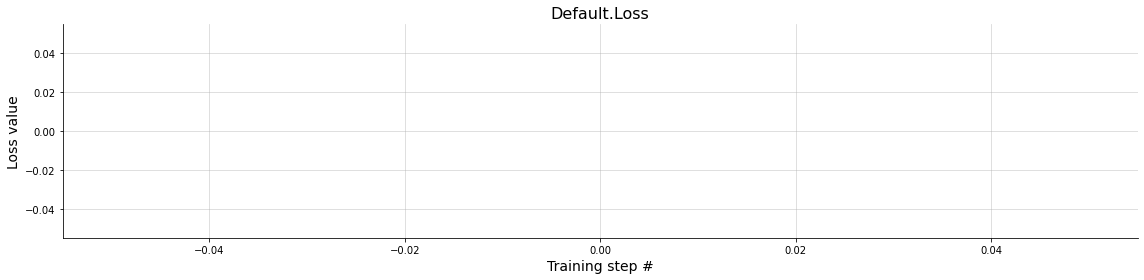

In [68]:
losses = trainer_ecg.loss_history.get_plottable()
stepsize= 1000
#for i in range(int(15000/stepsize)):
for i in range(int(80000/stepsize)):
    fig = diag.plot_losses(losses[i*stepsize:(i+1)*stepsize])

# LR adjustments triggered at 4979 its, 7349 its, 13169 its and 15410 its (=stop)

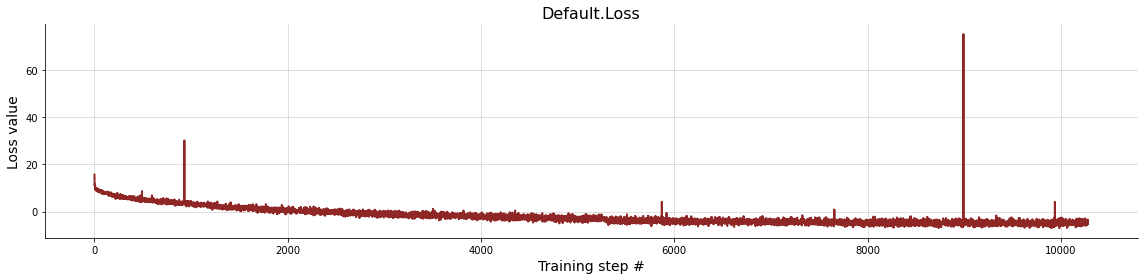

In [69]:
fig = diag.plot_losses(losses)

In [70]:
#fig_2 = trainer_ecg.diagnose_latent2d()

In [71]:
#fig_3 = trainer_ecg.diagnose_sbc_histograms()

In [72]:
# g, axarr2 = plt.subplots(7, 7, figsize=(20, 10))

# for ax in axarr2.flat:
#     q = trainer_ecg.configurator(model_ecg(batch_size=1))
#     p = amortizer_ecg.sample(q, n_samples=1)
#     y = model_ecg.simulator(p)['sim_data'][0]
#     ax.plot(y)
# g.tight_layout()

/tmp/ipykernel_4836/3223817925.py:73: RuntimeWarning: divide by zero encountered in true_divide
  z += d[i]*np.exp(-(delta_theta(x,y,theta[i]))**2 / (2*b[i]*b[i]))


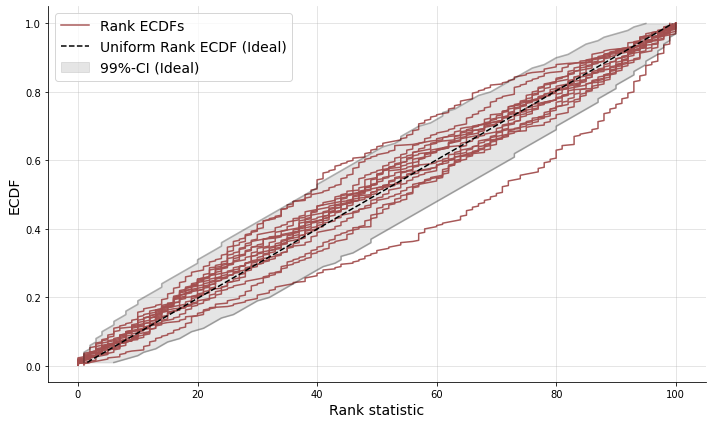

In [73]:
valid_sim_data_raw = model_ecg(batch_size=300)
#valid_sim_data_raw = model_ecg(batch_size=1000)
valid_sim_data = trainer_ecg.configurator(valid_sim_data_raw)
posterior_samples = amortizer_ecg.sample(valid_sim_data, n_samples=100)
#posterior_samples = amortizer_ecg.sample(valid_sim_data, n_samples=300)
fig = diag.plot_sbc_ecdf(posterior_samples, valid_sim_data['parameters'])

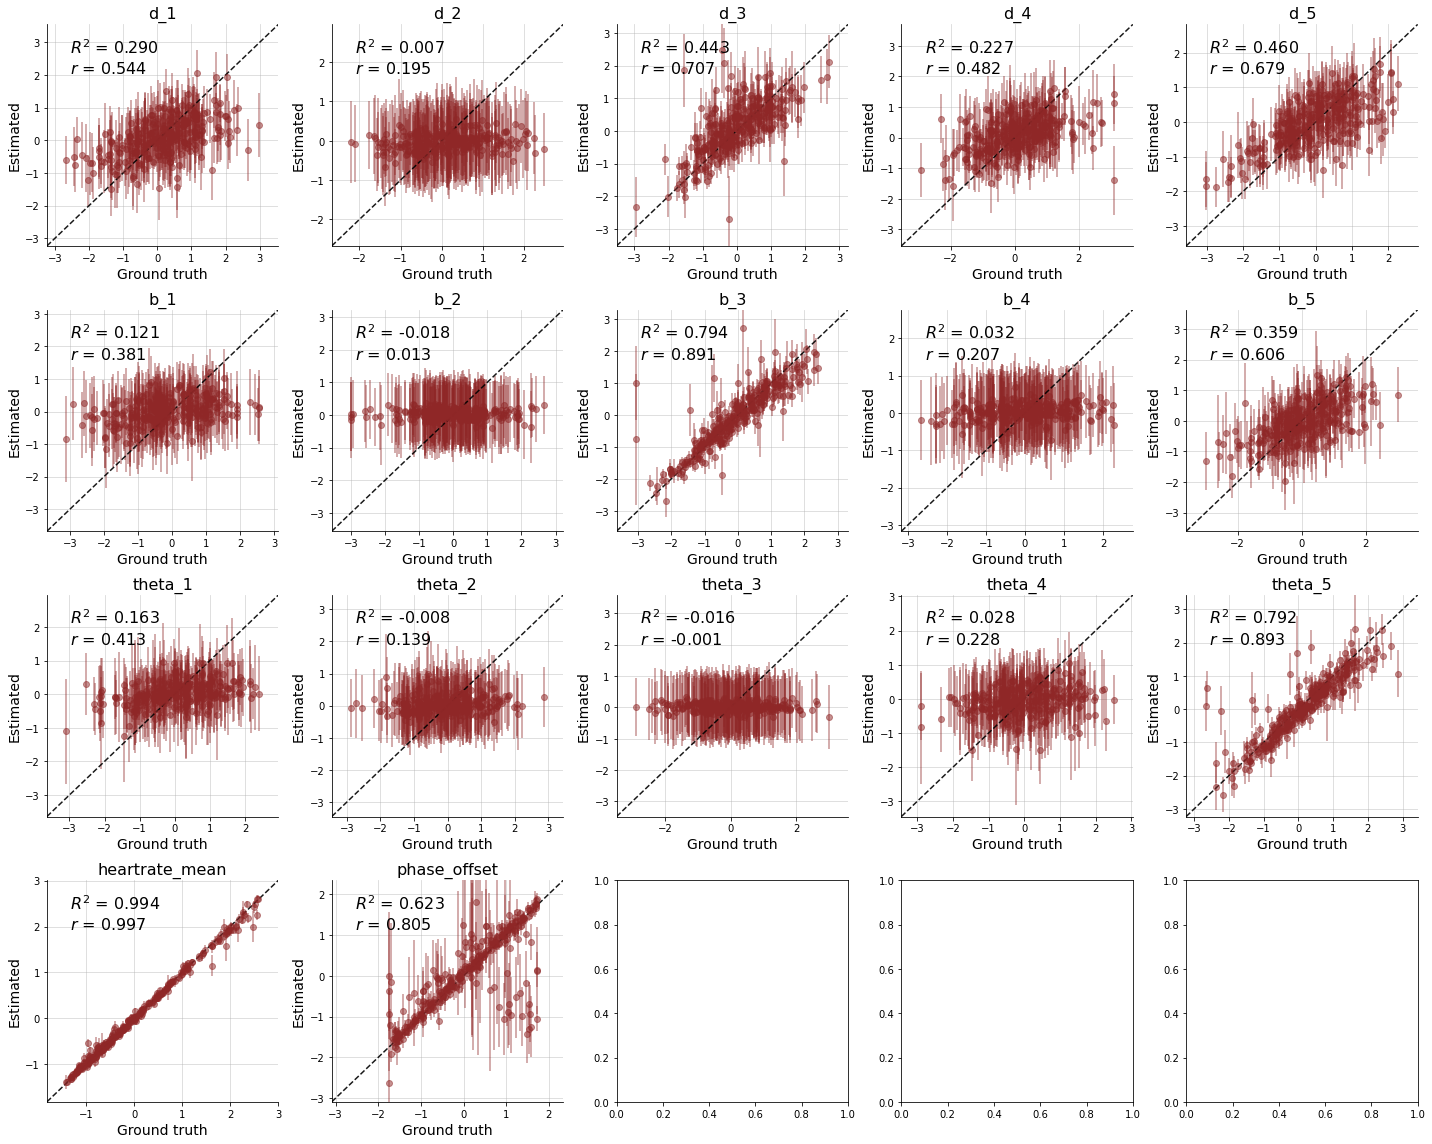

In [74]:
fig = diag.plot_recovery(posterior_samples, valid_sim_data['parameters'], param_names=prior_ecg.param_names, n_col=5)

In [75]:
posterior_samples_unnorm = prior_means + posterior_samples * prior_stds
#fig = diag.plot_posterior_2d(posterior_samples_unnorm[0], param_names=prior_ecg.param_names)

In [76]:
#fig = diag.plot_posterior_2d(posterior_samples_unnorm[0], prior=prior_ecg)


 Resimulation 0:


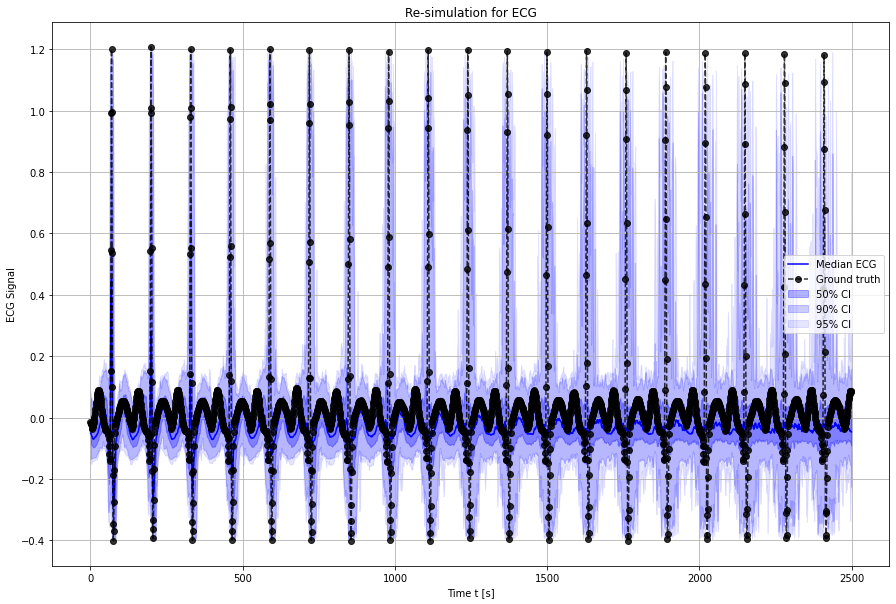


 Resimulation 1:


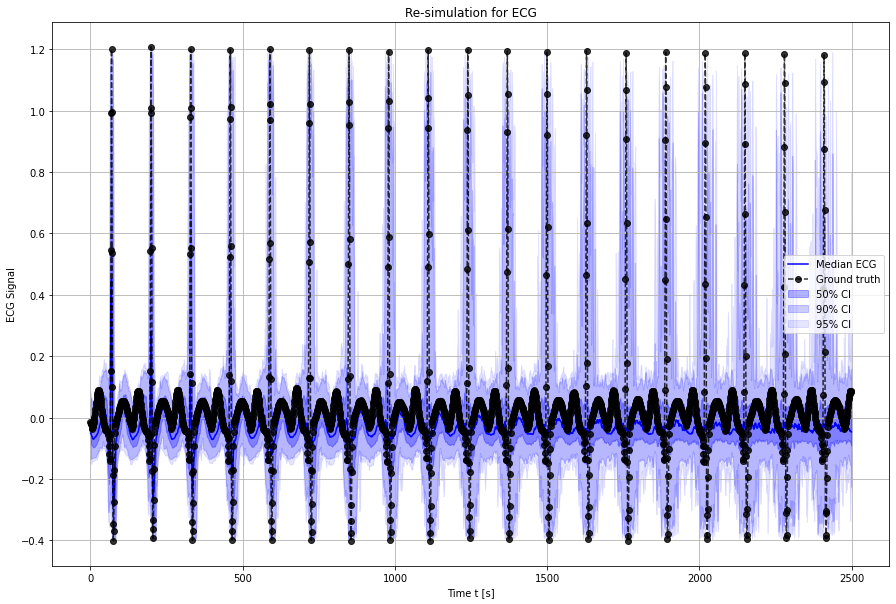


 Resimulation 2:


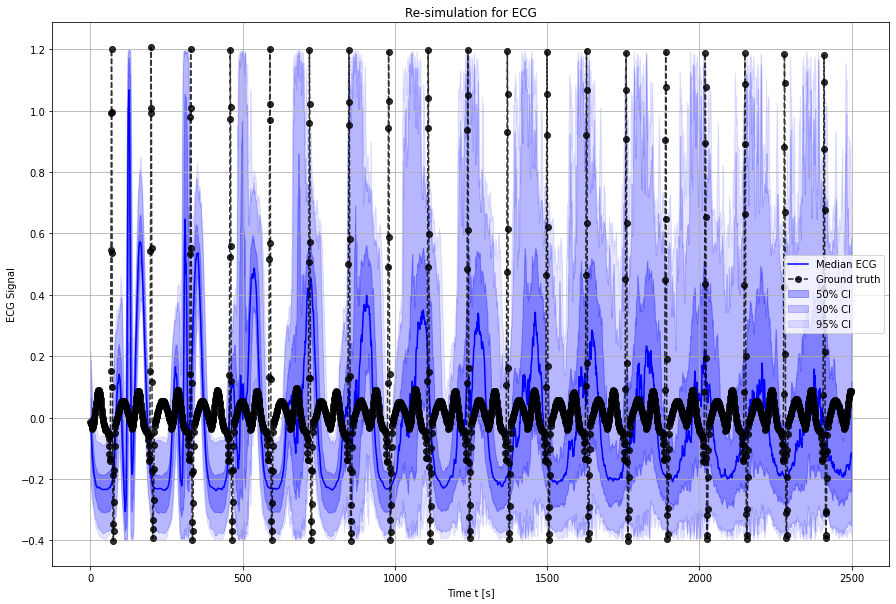


 Resimulation 3:


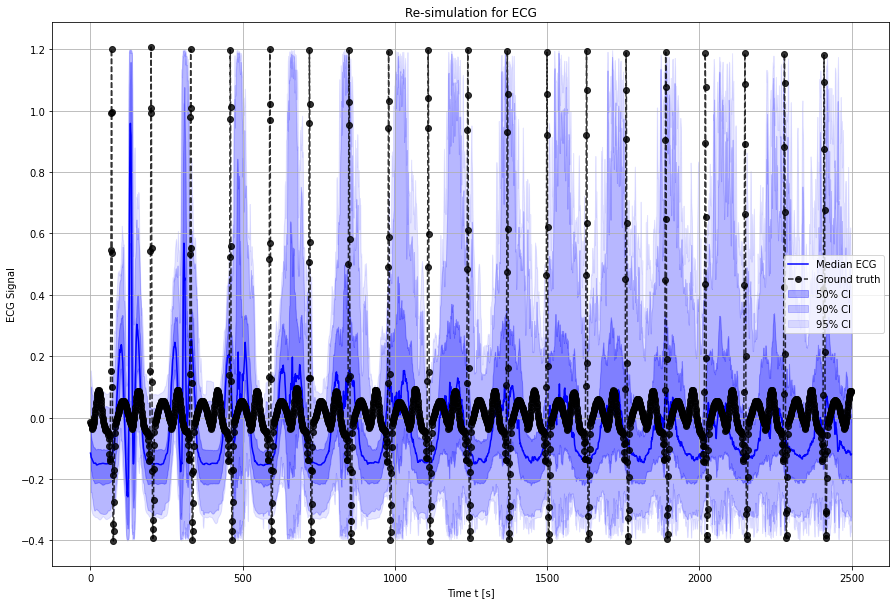


 Resimulation 4:


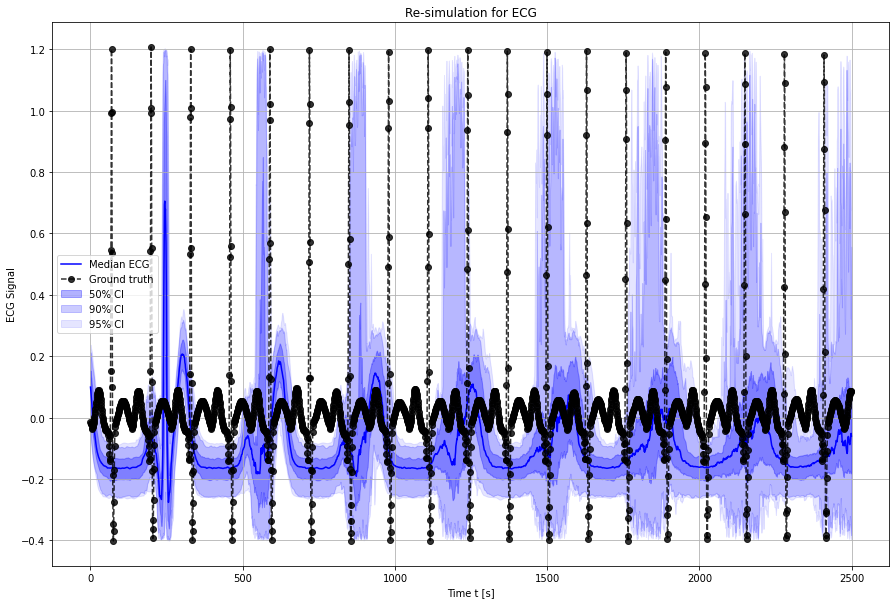


 Resimulation 5:


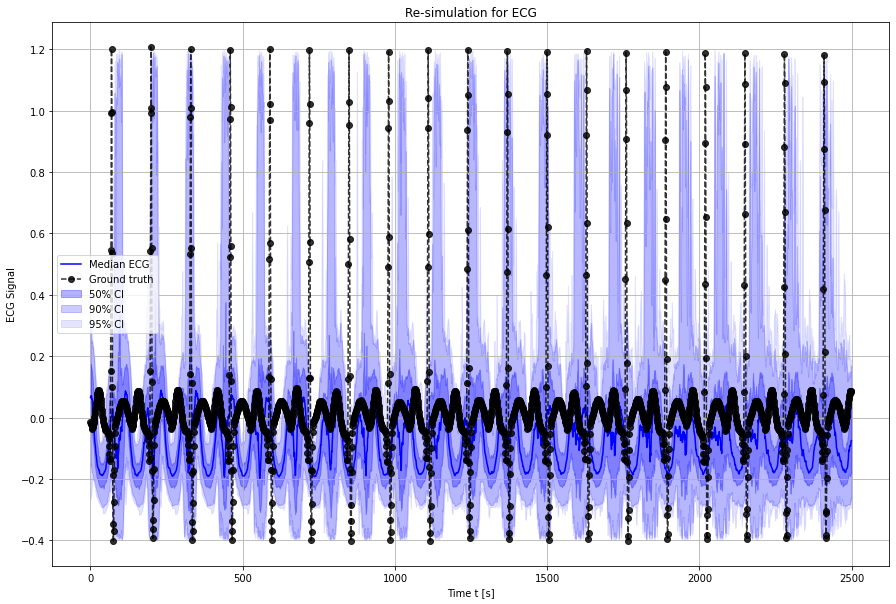


 Resimulation 6:


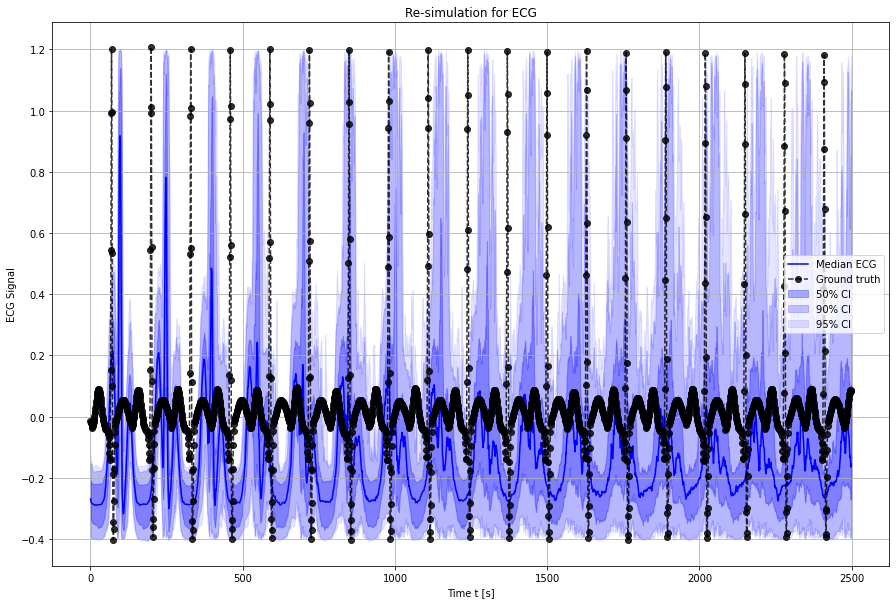


 Resimulation 7:


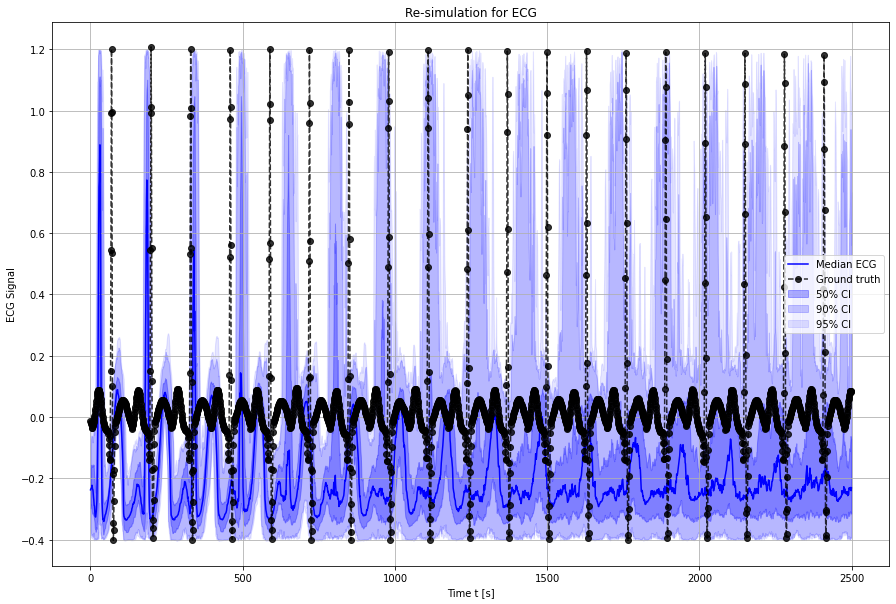


 Resimulation 8:


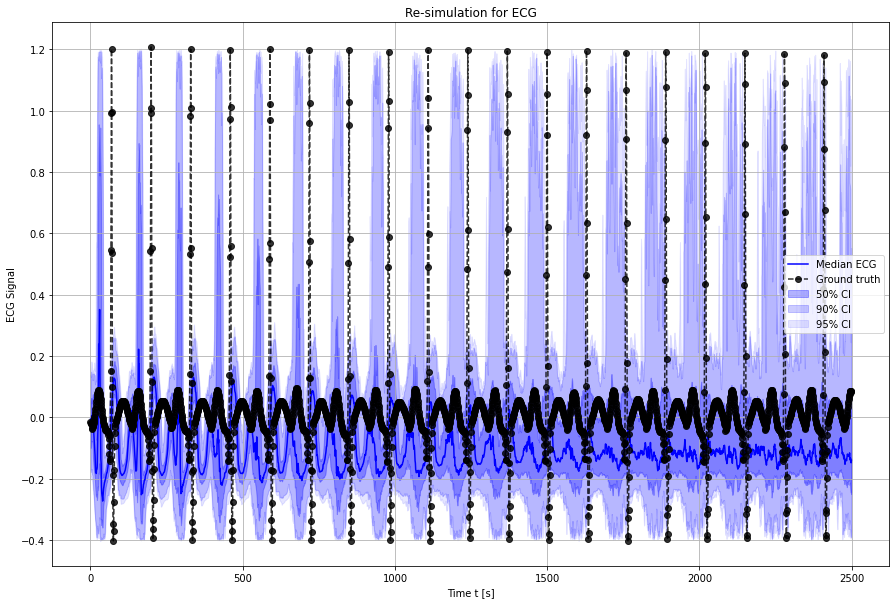


 Resimulation 9:


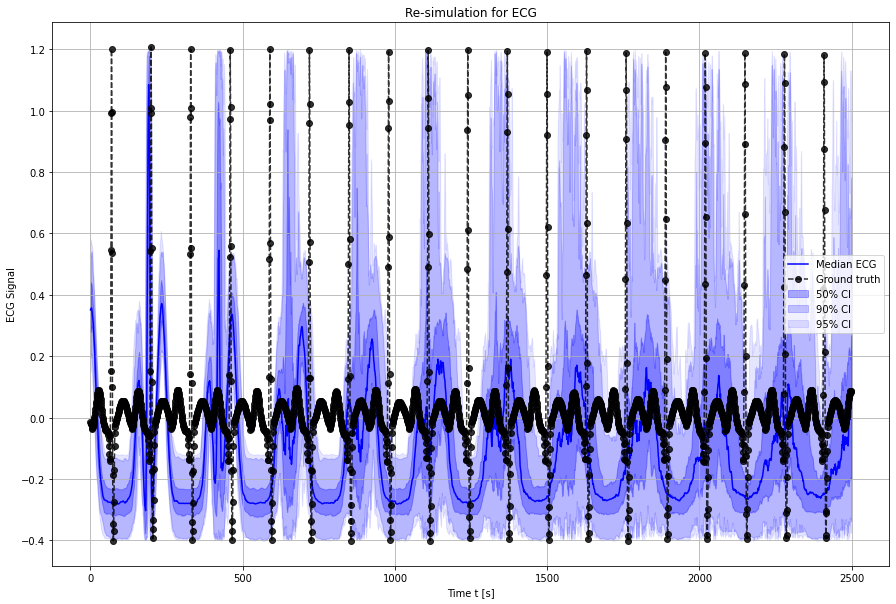

In [95]:
time_points = np.arange(2500)

for i in range(10):
    try:
        resim = simulate_batch(posterior_samples_unnorm[i,:], params_model, params_sim, param_list, baseline_wander=False)
    except:
        pass    
    print(f"\n Resimulation {i}:")
    
    # compute quantiles
    qt_50 = np.quantile(resim, q=[0.25, 0.75], axis=0)
    qt_90 = np.quantile(resim, q=[0.05, 0.95], axis=0)
    qt_95 = np.quantile(resim, q=[0.025, 0.975], axis=0)

    # plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax.plot(time_points, np.median(resim, axis=0), label='Median ECG', color='b')
    ax.plot(time_points, valid_sim_data_raw['sim_data'][0, :], marker='o', label='Ground truth', color='k', linestyle='--', alpha=0.8)
    ax.fill_between(time_points, qt_50[0], qt_50[1], color='b', alpha=0.3, label='50% CI')
    ax.fill_between(time_points, qt_90[0], qt_90[1], color='b', alpha=0.2, label='90% CI')
    ax.fill_between(time_points, qt_95[0], qt_95[1], color='b', alpha=0.1, label='95% CI')
    ax.grid(True)
    ax.set_title("Re-simulation for ECG")
    ax.set_xlabel("Time t [s]")
    ax.set_ylabel("ECG Signal")
    ax.legend()
    plt.show()

# for i in range(10):
#     resim = simulate_one(posterior_samples_unnorm[0,i], params_model, params_sim, param_list, baseline_wander=False)

#     # plot
#     fig, ax = plt.subplots(1, 1, figsize=(15, 10))
#     ax.plot(time_points, resim, label='Resimulated ECG', color='b')
#     ax.plot(time_points, valid_sim_data_raw['sim_data'][0, :], marker='o', label='Ground truth', color='k', linestyle='--', alpha=0.8)
#     ax.set_title("Re-simulation for ECG")
#     ax.set_xlabel("Time t [s]")
#     ax.set_ylabel("ECG Signal")
#     ax.legend()
#     plt.show()

In [78]:
## Offene Fragen
# 1. Welche Parameter sollten variiert werdden (b,theta,a,f_2, Simulation)?
# 2. Wie sollte variiert werden (Verteilung, Streuung)?
# Ziel: Zunächst einmal gesunde Fälle priorisieren. Ggf. mehrere Modelle nutzen (unterschiedliche Pathologien)
# -> Model selection
# Einheit für Periode gleich halten (gleiche Zeitschrittgröße); Signallänge (/Anzahl der Perioden)
# erstmal fix mit CNN, dann mit LSTM variabel

# Weiß man, wie hoch die Rauschamplitude ist? Wenn ja, als Parameter an das NN übergeben

# Kalibrierungsproblemerklärung: zu wenig trainiert, zu kleines Netz

In [79]:
# 1. Adjustable learning rate stärker parametrisierbar (u. an-/abstellbar) machen? (Aktuell zu frühes Stoppen)
# -> Aktuelle Fassung von letzter Woche testen!

# 2. Debugging/Fehlersuche wenn das Modell rät (true vs. estimated horizontal)? Workflow?
# -> Korrelation +/-1 zwischen Komponenten
# -> Info-Verlust im Modell? 
# -> PyABC direkt auf Summary Statistic (Vorsicht, langsam!)
# -> LSTM 500 hidden units für 4-5 Parameter (erst als Regression ohne BayesFlow testen, dann als 
# Summary Net nutzen)
# -> unter der Voraussetzung guter Ergebnisse: pre-trained networks verwenden
# -> Trainings-Tempo: ein paar Tausend Simulationen sollten aussagekräftige Trends liefern
# -> Diagnostik mittels true vs estimated: ggf. Median statt Mittelwert testen

# 3. Summary net: Wahl von n_summary? Größe und Art des Netzes (in Relation zu n_summary/dem Problem)?
# -> >= Anzahl params (e.g. x4)
# -> PCA des summary space (-> überparametrisierter latent space erkennen (Detecting Model Misspecification ... arXiv 2021 (Radev last)))

# 4. Preprocessing (ja/nein, wenn ja was)?
# -> Fokus auf over-/underflow vermeiden (Skalierung)
# -> einzelner Herzschlag ggf unterinformativ
# -> Downsampling
# -> Transformation (e.g. Fourier)

# 5. Nutzung von Kontext-Informationen? (Hilfreich? Wenn ja, wie?)
# -> z.B. sampling frequency
# -> Nützlich, wenn sich Kontext verändert (z.B. zwei verschiedene sampling frequencies je nach Batch)

# 6. Offline-Training ohne dass Memory ausgeht
# -> Loop über Training; ggf Simulationdataset helper_class anpassen


In [80]:
# Zeitabhängige Parameter: erst omega, dann ggf weitere (wirft auch Fragen zu Priors auf) -> super statistics
# Vergleich: segmentiertes Signal ohne super statistics vs. Gesamtsignal mit
# Ggf. anderes Fit-Verfahren als BayesFlow als Baseline (mechanical engineering?)
# Reale Daten -> Simulation gap / model misspecification (später)
# Wunschliste:
# Prior-Veränderung günstig auffangen

In [81]:
# Fragen
# 1. Es gibt keine Prior aus der Literatur. Lohnt es sich, empirisch welche zu bauen? (Konkret: reale Daten
#    mit den Parametern fitten)
# 2. Ist es sinnvoll, das komplett triviale Problem (keine Basislinien-Wanderung) als Startpunkt zu wählen?
#    (Stichwort: Simulationsgeschwindigkeit)
# 3. Im aktuellen Modell sind die Veränderungen zu gering. Sollte man die Herzfrequenz (erheblich) breiter
#    streuen lassen? Wenn ja, was für Verteilungen eignen sich? Sollte man auf der Basis von Prof. Hessers
#    Vorgaben auch die anderen Parameter breiter streuen und dann rejection sampling betreiben (Zitat: 
#    "Wichtig ist, dass die R-Zacke immer viel größer ist als die P und T-Wellen und dass sie auch 
#    viel schmäler ist.")?



# 1. Daten fitten, Marginalverteilung der Posterior über Daten lernen
# = neuer Prior
# Iterate until prior converges (SMPT)
# "Neuro-empirical Bayes" -> jetzt Prior-

# Prior setzen
# BF trainieren mit Prior
# Inferenz mit realen Daten
# Sample zu realen Daten Posterior
# Trainiere INN auf Posterior Samples
# (neuer Prior: entweder fit über Punkte mit Gauss oder so oder INN)
# Wiederholen
# Ggf. als Baseline: naives Fitting der realen Daten

# 3. Um überhaupt BF trainieren zu können, 3. umsetzen. 

In [82]:
#min_shifted = 0
#mean_shifted = 25
#max_shifted = 160

In [83]:
def naive_error(params, targets=[40, 200, 65]):
    integrand = partial(scipy.stats.lognorm.pdf, s=params[0], loc=targets[2], scale=params[1])
    lower_int = scipy.integrate.quad(integrand, targets[0], targets[2])[0]
    upper_int = scipy.integrate.quad(integrand, targets[2], targets[1])[0]
    return (lower_int-upper_int)**2
#     y_target = scipy.stats.lognorm.pdf(targets, s=params[0], loc=targets[1], scale=params[1])
#     x_general = np.linspace(0, targets[1]+50, 1000)
#     y_general = scipy.stats.lognorm.pdf(x_general, s=params[0], loc=targets[1], scale=params[1])
#     y_max = max(y_general)
#     return y_target[0]**2 + y_target[1]**2

def fit_naively(x_min, x_max, x_mean):
    opt = scipy.optimize.minimize(fun=partial(naive_error,targets=[x_min,x_max,x_mean]),x0=[1,1])
    return(opt)

#opt = fit_naively(40, 200, 65)
    

In [84]:
# x = np.linspace(-250,250,1000)
# y = scipy.stats.lognorm.pdf(x, s=sol[0], loc=65, scale=sol[1])
# fig_2d = plt.figure(figsize=(10,8))
# ax_2d = plt.axes()
# ax_2d.plot(x,y)

In [85]:
def lnormpar(x1, xn, xbar, n, start=[0,1]):
    opt = scipy.optimize.minimize(fun=partial(nll,x1=x1,xn=xn,xbar=xbar,n=n), x0=start)
    return opt
    
def nll(theta,x1,xn,xbar,n):
    mu = theta[0]
    sigma = theta[1]
    z1 = (np.log(x1)-mu)/sigma
    z2 = (np.log(xn)-mu)/sigma
    # mean and variance of (x_1,x_n)-truncated lognormal
    dnorm = scipy.stats.norm.logpdf
    pnorm = scipy.stats.norm.cdf
    dlnorm = scipy.stats.lognorm.logpdf
    plnorm = scipy.stats.lognorm.cdf
    
    mu1_trunc = np.exp(mu + (sigma**2)/2)* (pnorm(z2 - sigma) - pnorm(z1 - sigma))/(pnorm(z2) - pnorm(z1))
    mu2_trunc = np.exp(2*mu + 2*(sigma**2))*(pnorm(z2 - 2*sigma) - pnorm(z1 - 2*sigma))/(pnorm(z2) - pnorm(z1))
    var_trunc = mu2_trunc - mu1_trunc**2
    # joint density of x1, xn, xbar
    ll = np.sum(dlnorm([x1,xn], s=sigma, loc=mu)) + (n-2)*np.log(plnorm(xn, s=sigma, loc=mu)\
        - plnorm(x1, s=sigma, loc=mu)) + dnorm(xbar, (x1 + xn + (n-2)*mu1_trunc)/n, np.sqrt(var_trunc/(n-2)))
    return -ll

#results = lnormpar(x1=100,xn=10000,xbar=1000,n=10)

#   # maximise the log likelihood
#   opt <- optim(start, nll, hessian=TRUE)
#   # extract parameter estimates
#   res <- cbind(opt$par, sqrt(diag(solve(opt$hessian))))
#   rownames(res) <- c("mu","sigma")
#   colnames(res) <- c("Estimate","Std. Error")
#   res


In [86]:
#x = np.linspace(0,5,1000)

In [87]:
# def heartrate_lognormal(batch_size):
#     sample_unscaled = scipy.stats.lognorm.rvs(s=1, loc=0, scale=3, size=batch_size)
#     return sample_unscaled*20+40

In [88]:
# bla = heartrate_lognormal(50000)
# fig_2d = plt.figure(figsize=(8,6))
# ax_2d = plt.axes()
# ax_2d.set_xlim([0,500])
# plt.hist(bla, bins=1000)

In [89]:
# x = np.linspace(0,8,1000)
# y = scipy.stats.lognorm.pdf(x, s=0.75, loc=0, scale=1.5)
# fig_2d = plt.figure(figsize=(10,8))
# ax_2d = plt.axes()
# ax_2d.plot(x,y)

In [90]:
# mu = 4.14
# sigma = 0.25

# mu_l = np.log(mu**2 / np.sqrt(mu**2 + sigma**2))
# sigma_l = np.sqrt(np.log(1 + (mu/sigma)**2))

In [ ]:
# period: 4000 (increased from 1k)
# tolerance: -0.01 (possibly shrunk)
# cooldown_factor: 1.5 (reduced from 2 to fit period size)
# num_resets: 8
# reduction_factor: 0.5 ? 0.25?